In [247]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from typing import List

import numpy as np
import cv2

import torch
import torch.linalg as LA

from camera_transition import CameraTransition
from models import (
    ActorImprovedValue,
    CriticTD,
    ActorModel,
    CriticModel)
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [248]:
def torch_rodrigues(mat):
    U, _, V_T = LA.svd(mat)
    R = U @ V_T
    r1 = R[:, 2, 1] - R[:, 1, 2]
    r2 = R[:, 0, 2] - R[:, 2, 0]
    r3 = R[:, 1, 0] - R[:, 0, 1]

    r = torch.stack((r1, r2, r3), 1)
    s = LA.norm(r, dim=1) / 2
    c = (R[:, 0, 0] + R[:, 1, 1] + R[:, 2, 2] - 1) / 2
    c = torch.clip(c, -1., 1.)
    theta = torch.acos(c)
    vth = 1 / (2 * s)
    r = r.T * vth * theta
    return r.T

In [249]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

camera_mat = torch.tensor([
    [633.09029639, 0., 629.06462963],
    [0., 638.7544391, 362.74013262],
    [0., 0., 1.]
])
target_points = torch.tensor([
    [822.75,     362.25],
    [755.25,     476.25],
    [624.75,     476.25],
    [554.25,     366.75],
    [618.75,     273.75],
    [755.25,     270.75]
    ])
points_env = torch.tensor([
    [2, 0, 4],
    [1, 1.66, 4],
    [-1, 1.66, 4],
    [-2, 0, 4],
    [-1, -1.66, 4],
    [1, -1.66, 4],
])

camera_transition = CameraTransition(
    device,
    camera_mat,
    target_points,
    points_env,
    100.
)

In [250]:
optimizer_critic_kind = torch.optim.Adam
optimizer_critic_parameters = {
    'lr': 5e-6,
    'weight_decay': 1e-5
}

optimizer_actor_kind = torch.optim.Adam
optimizer_actor_parameters = {
    "lr" : 1e-4,
    "weight_decay" : 1e-5
}

critic_iterations = 2000
critic_batch_size = 4000

actor_iterations = 2000
actor_batch_size = 2000

epochs = 10

In [251]:
actor = ActorModel().to(device)
critic = CriticModel().to(device)

critic_temporal_difference = CriticTD(actor, critic, camera_transition).to(device)
actor_improved_value = ActorImprovedValue(actor, critic, camera_transition).to(device)

In [252]:
def visualize_scatter(orig_coords, old_coords, new_coords, save_dir='photos', i=1):
    plt.scatter( orig_coords[:, 0], orig_coords[:, 1], c=range(6), marker='x')
    plt.scatter( old_coords[:, 0], old_coords[:, 1], c=range(6), marker='o')
    plt.scatter( new_coords[:, 0], new_coords[:, 1], c=range(6), marker='^')
    plt.xlim(-10, 1280)
    plt.ylim(-20, 720)
    plt.axis('off')
    plt.savefig(f'{save_dir}\\{i}.png')
    plt.axis('on')
    plt.show()

In [253]:
def get_start_position(bs):
    x = torch.hstack([torch.Tensor(np.random.uniform(-2, 2, (bs, 3)).astype(np.float64)),
                         torch.Tensor(np.random.uniform(-.4, .4, (bs, 3)).astype(np.float64))])
    x[:, 3:5] = 0
    return x

SCALES = torch.tensor([0.1, 0.1, 0.1, 0.5, 0.5, 0.5])
def critic_epoch(optimizer: torch.optim.Optimizer,
                 model: CriticTD, 
                 iterations: int, 
                 batch_size: int) -> List[float]:
    losses = []
    for iteration in tqdm(range(iterations), "Critic epoch"):
        # Поменять на наши ограничения позиции
#         scales = SCALES
#         X = (torch.rand((batch_size, 6)) * scales * 2 - scales).to(device)
        X = get_start_position(batch_size).to(device)
        optimizer.zero_grad()
        loss = model(X)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    print("Critic mean loss:", np.mean(losses), "[%f --> %f]" % (np.mean(losses[0:10]), np.mean(losses[-10:-1])))
    return losses

def actor_epoch(optimizer: torch.optim.Optimizer,
                 model: CriticTD, 
                 iterations: int, 
                 batch_size: int) -> List[float]:
    values = []
    for iteration in tqdm(range(iterations), "Actor epoch"):
        X = get_start_position(batch_size).to(device)
        optimizer.zero_grad()
        improved_value = model(X)
        improved_value.backward()
        optimizer.step()
        values.append(improved_value.detach().cpu().numpy())
    print("Actor mean value:", np.mean(values), "[%f --> %f]" % (np.mean(values[0:10]), np.mean(values[-10:-1])))

    state = X[-1].unsqueeze(0)
#     print('state', state.shape)
    new_state = actor.forward(state)[0]
    ct = camera_transition(state, new_state)
    op = camera_transition._project_points(state).detach().cpu().numpy()
    new = camera_transition._project_points(ct[0]).detach().cpu().numpy()
#     print(op, '\n\n', new)
    visualize_scatter(
        np.array(target_points), 
        np.array(op[0]), 
        np.array(new[0])
    )
    return values

In [254]:
optimizer_actor = optimizer_actor_kind(actor_improved_value.parameters(), **optimizer_actor_parameters)

Critic epoch: 100%|██████████| 2000/2000 [00:17<00:00, 116.48it/s]


Critic mean loss: 21540870000000.0 [21317761892352.000000 --> 21379176988672.000000]


Actor epoch: 100%|██████████| 2000/2000 [00:24<00:00, 80.27it/s]


Actor mean value: 4547236.0 [4640005.000000 --> 4544672.000000]


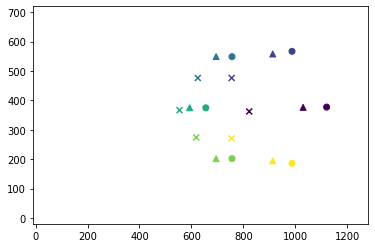

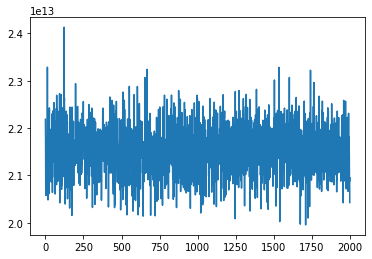

Critic epoch: 100%|██████████| 2000/2000 [00:17<00:00, 114.72it/s]it]


Critic mean loss: 20670033000000.0 [20645568053248.000000 --> 20476074131456.000000]


Actor epoch: 100%|██████████| 2000/2000 [00:28<00:00, 70.56it/s]


Actor mean value: 4545275.0 [4556066.500000 --> 4526815.000000]


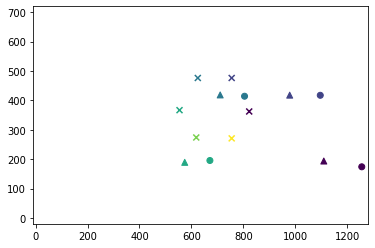

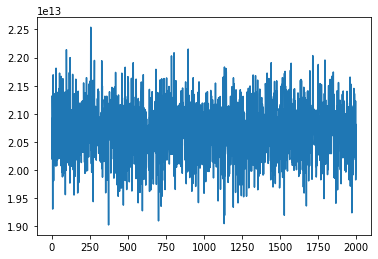

Critic epoch: 100%|██████████| 2000/2000 [00:17<00:00, 113.12it/s]it]


Critic mean loss: 20656972000000.0 [20627637403648.000000 --> 20737603665920.000000]


Actor epoch: 100%|██████████| 2000/2000 [00:28<00:00, 69.24it/s]


Actor mean value: 4543813.5 [4561091.500000 --> 4576874.000000]


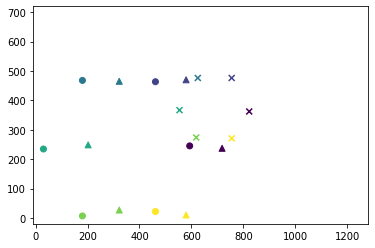

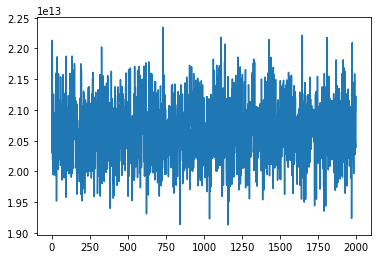

Critic epoch: 100%|██████████| 2000/2000 [00:17<00:00, 113.69it/s]it]


Critic mean loss: 20669557000000.0 [20456918745088.000000 --> 20969395585024.000000]


Actor epoch: 100%|██████████| 2000/2000 [00:27<00:00, 73.11it/s]


Actor mean value: 4543883.5 [4543304.500000 --> 4542925.500000]


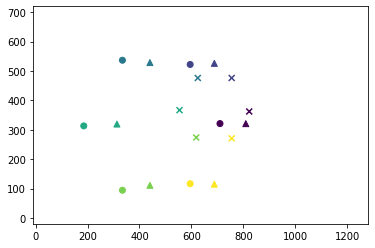

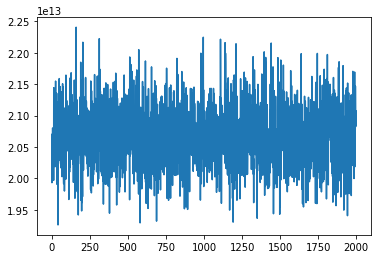

Critic epoch: 100%|██████████| 2000/2000 [00:16<00:00, 118.80it/s]it]


Critic mean loss: 20661162000000.0 [20841869869056.000000 --> 20659247775744.000000]


Actor epoch: 100%|██████████| 2000/2000 [00:28<00:00, 69.88it/s]


Actor mean value: 4543972.0 [4549268.500000 --> 4520828.500000]


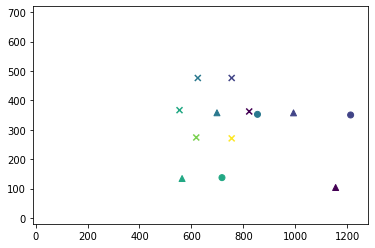

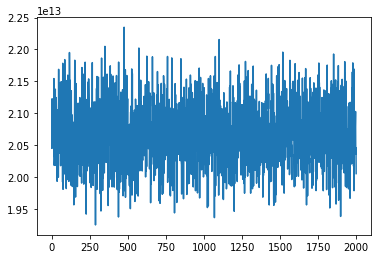

Critic epoch: 100%|██████████| 2000/2000 [00:16<00:00, 124.73it/s]it]


Critic mean loss: 20667580000000.0 [21007406465024.000000 --> 20520003174400.000000]


Actor epoch: 100%|██████████| 2000/2000 [00:28<00:00, 71.35it/s]


Actor mean value: 4544728.0 [4540814.000000 --> 4576095.000000]


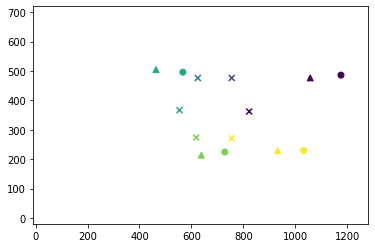

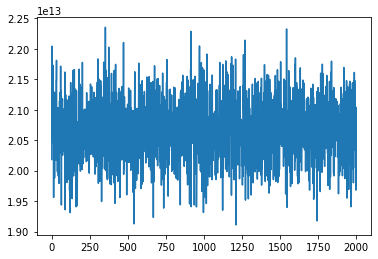

Critic epoch: 100%|██████████| 2000/2000 [00:18<00:00, 109.84it/s]it]


Critic mean loss: 20653057000000.0 [20829830119424.000000 --> 20472561401856.000000]


Actor epoch: 100%|██████████| 2000/2000 [00:23<00:00, 85.65it/s]

Actor mean value: 4546040.0 [4551470.500000 --> 4541624.000000]


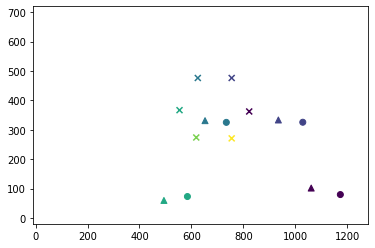

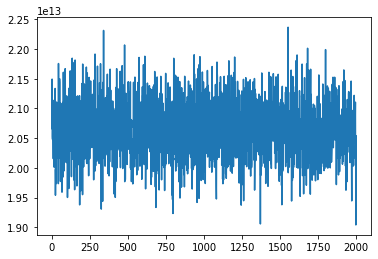

Critic epoch: 100%|██████████| 2000/2000 [00:16<00:00, 119.94it/s]it]


Critic mean loss: 20654600000000.0 [20823272325120.000000 --> 21100165595136.000000]


Actor epoch: 100%|██████████| 2000/2000 [00:36<00:00, 54.52it/s]


Actor mean value: 4546761.5 [4537897.000000 --> 4537694.500000]


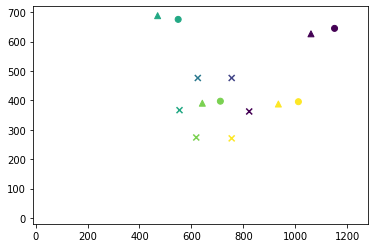

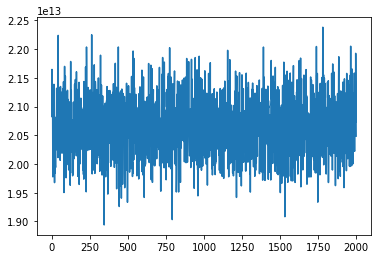

Critic epoch: 100%|██████████| 2000/2000 [00:18<00:00, 109.15it/s]it]


Critic mean loss: 20655091000000.0 [20555174510592.000000 --> 20832046809088.000000]


Actor epoch: 100%|██████████| 2000/2000 [00:21<00:00, 94.58it/s]


Actor mean value: 4544212.0 [4564485.000000 --> 4548375.000000]


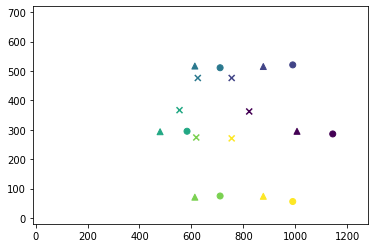

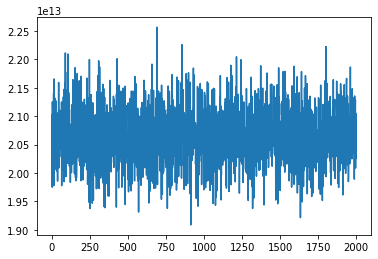

Critic epoch: 100%|██████████| 2000/2000 [00:16<00:00, 123.41it/s]it]


Critic mean loss: 20632645000000.0 [20594059902976.000000 --> 20636952952832.000000]


Actor epoch: 100%|██████████| 2000/2000 [00:24<00:00, 82.22it/s]


Actor mean value: 4543623.5 [4552561.500000 --> 4538398.500000]


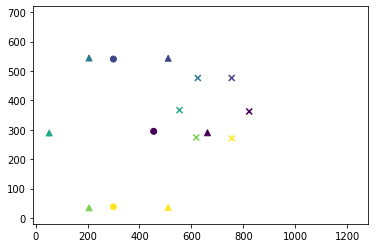

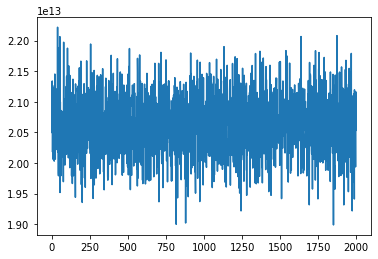

Actor-Critic learning: 100%|██████████| 10/10 [07:28<00:00, 44.87s/it]


In [255]:
for _ in tqdm(range(epochs), "Actor-Critic learning"):
    optimizer_critic = optimizer_critic_kind(critic_temporal_difference.parameters(), **optimizer_critic_parameters)
    losses = np.array(critic_epoch(optimizer_critic,
                                   critic_temporal_difference,
                                   critic_iterations,
                                   actor_batch_size))
    actor_epoch(optimizer_actor,
                actor_improved_value,
                actor_iterations,
                actor_batch_size)
    plt.plot(losses)
    plt.show()

tensor(-2487.1172, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.9500, -1.9580,  0.0714,  0.0000,  0.0000, -0.0108]],
       device='cuda:0', grad_fn=<AddBackward0>)


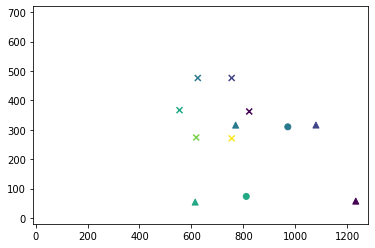

tensor(-2149.1804, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.9176, -1.9079,  0.1116,  0.0000,  0.0000, -0.1557]],
       device='cuda:0', grad_fn=<AddBackward0>)


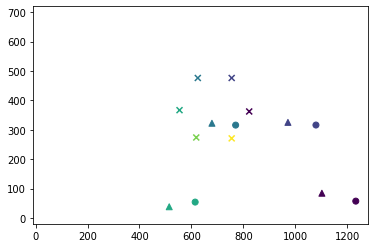

tensor(-2018.2310, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.9001, -1.8533,  0.1476,  0.0000,  0.0000, -0.2265]],
       device='cuda:0', grad_fn=<AddBackward0>)


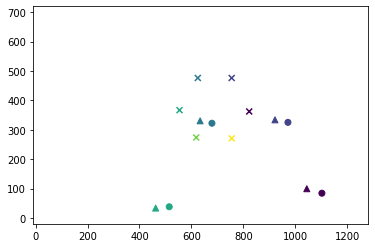

tensor(-1940.0754, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8910, -1.7977,  0.1816,  0.0000,  0.0000, -0.2528]],
       device='cuda:0', grad_fn=<AddBackward0>)


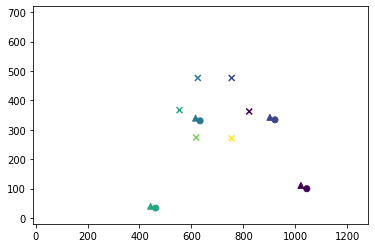

tensor(-1871.9658, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8847, -1.7424,  0.2146,  0.0000,  0.0000, -0.2637]],
       device='cuda:0', grad_fn=<AddBackward0>)


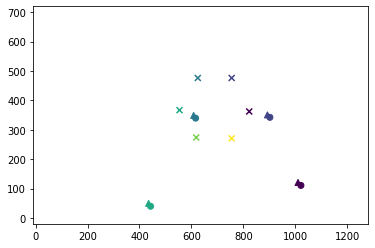

tensor(-1807.9017, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8795, -1.6879,  0.2466,  0.0000,  0.0000, -0.2688]],
       device='cuda:0', grad_fn=<AddBackward0>)


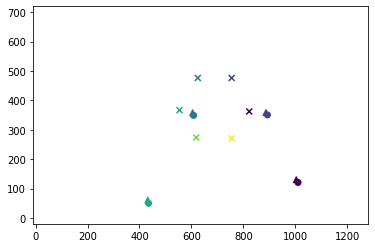

tensor(-1746.7375, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8748, -1.6344,  0.2776,  0.0000,  0.0000, -0.2716]],
       device='cuda:0', grad_fn=<AddBackward0>)


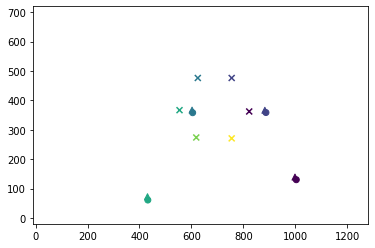

tensor(-1687.9365, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8703, -1.5818,  0.3077,  0.0000,  0.0000, -0.2741]],
       device='cuda:0', grad_fn=<AddBackward0>)


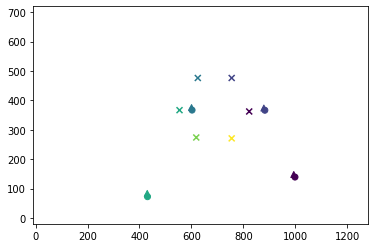

tensor(-1631.2609, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8659, -1.5301,  0.3372,  0.0000,  0.0000, -0.2770]],
       device='cuda:0', grad_fn=<AddBackward0>)


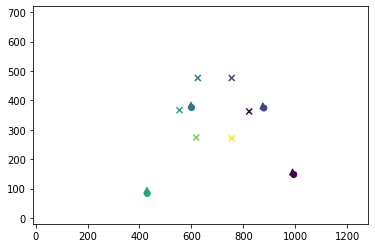

tensor(-1576.9634, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8617, -1.4798,  0.3665,  0.0000,  0.0000, -0.2793]],
       device='cuda:0', grad_fn=<AddBackward0>)


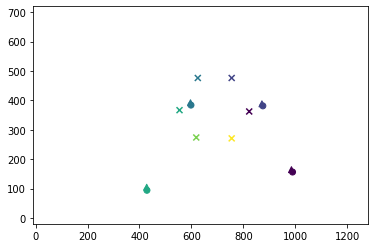

tensor(-1525.0142, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8578, -1.4308,  0.3954,  0.0000,  0.0000, -0.2811]],
       device='cuda:0', grad_fn=<AddBackward0>)


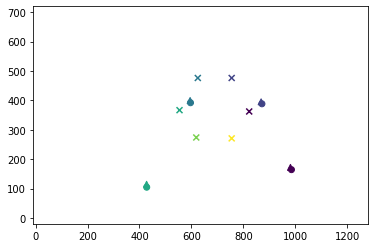

tensor(-1475.3193, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8540, -1.3831,  0.4239,  0.0000,  0.0000, -0.2828]],
       device='cuda:0', grad_fn=<AddBackward0>)


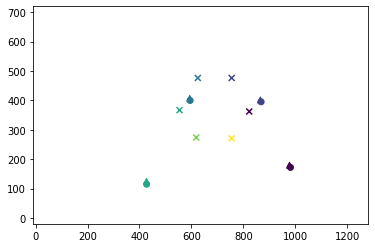

tensor(-1427.8870, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8503, -1.3367,  0.4521,  0.0000,  0.0000, -0.2839]],
       device='cuda:0', grad_fn=<AddBackward0>)


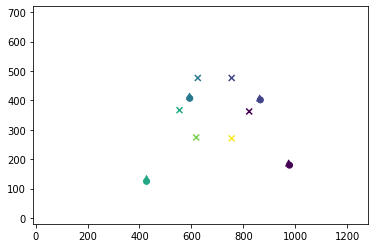

tensor(-1382.4889, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8469, -1.2916,  0.4801,  0.0000,  0.0000, -0.2843]],
       device='cuda:0', grad_fn=<AddBackward0>)


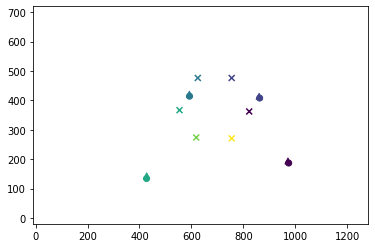

tensor(-1339.1206, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8436, -1.2476,  0.5078,  0.0000,  0.0000, -0.2838]],
       device='cuda:0', grad_fn=<AddBackward0>)


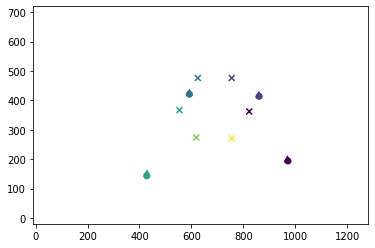

tensor(-1297.8068, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8403, -1.2048,  0.5352,  0.0000,  0.0000, -0.2831]],
       device='cuda:0', grad_fn=<AddBackward0>)


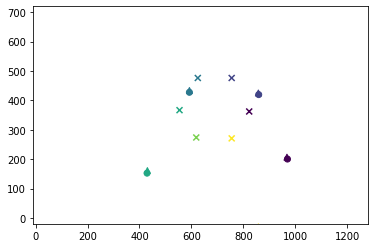

tensor(-1258.4729, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8364, -1.1632,  0.5620,  0.0000,  0.0000, -0.2833]],
       device='cuda:0', grad_fn=<AddBackward0>)


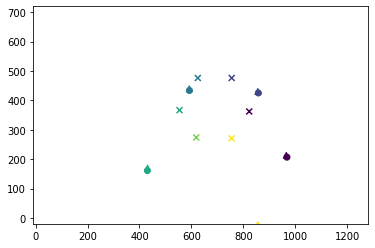

tensor(-1221.0417, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8322, -1.1225,  0.5884,  0.0000,  0.0000, -0.2837]],
       device='cuda:0', grad_fn=<AddBackward0>)


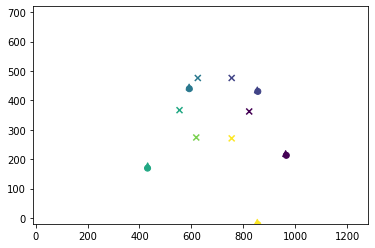

tensor(-1185.3518, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8281, -1.0824,  0.6143,  0.0000,  0.0000, -0.2843]],
       device='cuda:0', grad_fn=<AddBackward0>)


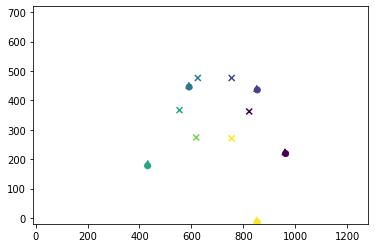

tensor(-1151.6487, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8241, -1.0431,  0.6393,  0.0000,  0.0000, -0.2844]],
       device='cuda:0', grad_fn=<AddBackward0>)


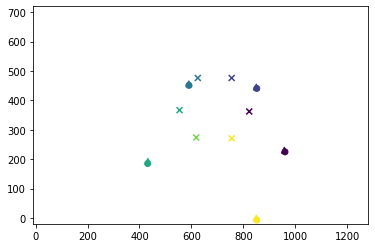

tensor(-1119.9296, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8201, -1.0046,  0.6635,  0.0000,  0.0000, -0.2845]],
       device='cuda:0', grad_fn=<AddBackward0>)


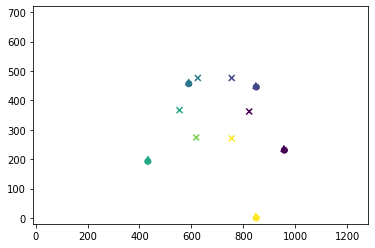

tensor(-1090.3621, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8162, -0.9673,  0.6872,  0.0000,  0.0000, -0.2849]],
       device='cuda:0', grad_fn=<AddBackward0>)


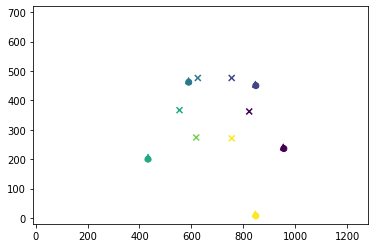

tensor(-1063.0081, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8125, -0.9313,  0.7105,  0.0000,  0.0000, -0.2857]],
       device='cuda:0', grad_fn=<AddBackward0>)


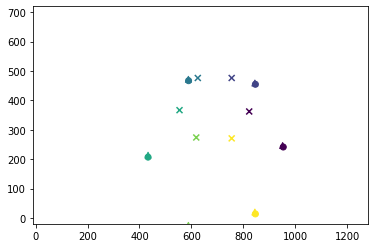

tensor(-1037.6768, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8089, -0.8968,  0.7334,  0.0000,  0.0000, -0.2867]],
       device='cuda:0', grad_fn=<AddBackward0>)


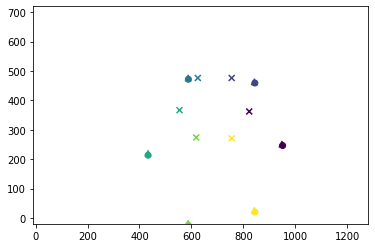

tensor(-1014.1875, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8056, -0.8636,  0.7561,  0.0000,  0.0000, -0.2878]],
       device='cuda:0', grad_fn=<AddBackward0>)


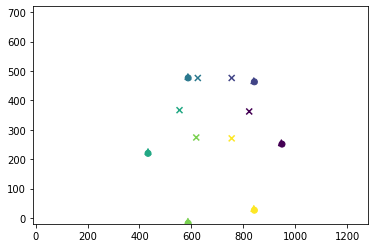

tensor(-992.2347, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8026, -0.8316,  0.7787,  0.0000,  0.0000, -0.2893]],
       device='cuda:0', grad_fn=<AddBackward0>)


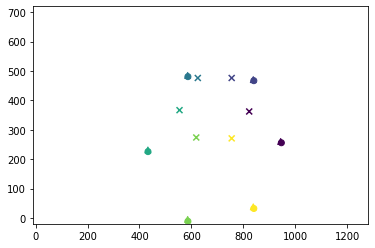

tensor(-971.6151, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7999, -0.8007,  0.8014,  0.0000,  0.0000, -0.2911]],
       device='cuda:0', grad_fn=<AddBackward0>)


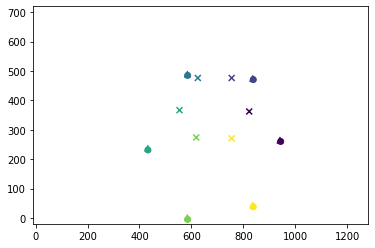

tensor(-952.1530, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7978, -0.7708,  0.8240,  0.0000,  0.0000, -0.2930]],
       device='cuda:0', grad_fn=<AddBackward0>)


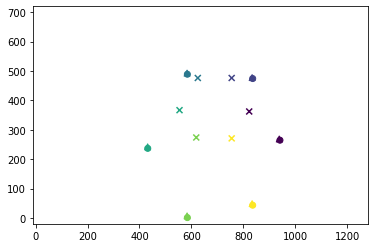

tensor(-933.6022, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7960, -0.7419,  0.8467,  0.0000,  0.0000, -0.2943]],
       device='cuda:0', grad_fn=<AddBackward0>)


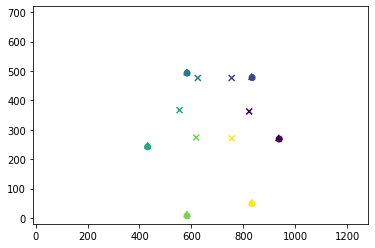

tensor(-915.8625, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7948, -0.7139,  0.8693,  0.0000,  0.0000, -0.2944]],
       device='cuda:0', grad_fn=<AddBackward0>)


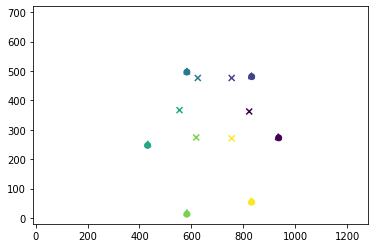

tensor(-898.9792, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7942, -0.6868,  0.8918,  0.0000,  0.0000, -0.2939]],
       device='cuda:0', grad_fn=<AddBackward0>)


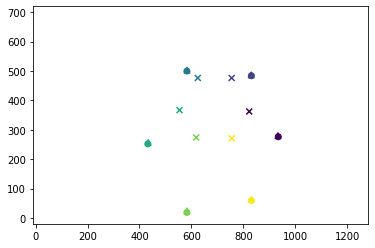

tensor(-883.0154, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7940, -0.6607,  0.9142,  0.0000,  0.0000, -0.2941]],
       device='cuda:0', grad_fn=<AddBackward0>)


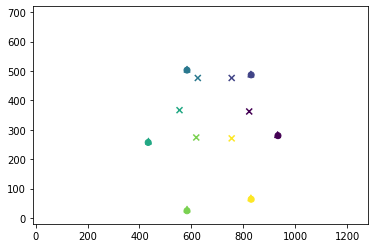

tensor(-867.9116, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7941, -0.6357,  0.9367,  0.0000,  0.0000, -0.2946]],
       device='cuda:0', grad_fn=<AddBackward0>)


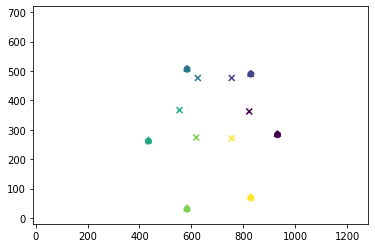

tensor(-853.6522, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7947, -0.6118,  0.9588,  0.0000,  0.0000, -0.2952]],
       device='cuda:0', grad_fn=<AddBackward0>)


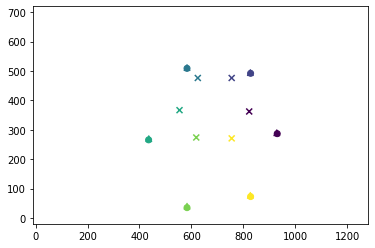

tensor(-840.1486, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7955, -0.5889,  0.9807,  0.0000,  0.0000, -0.2957]],
       device='cuda:0', grad_fn=<AddBackward0>)


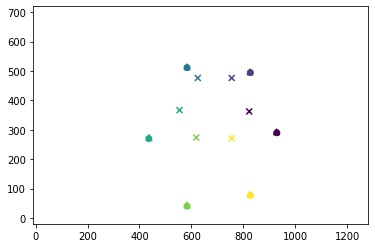

tensor(-827.2505, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7966, -0.5670,  1.0025,  0.0000,  0.0000, -0.2957]],
       device='cuda:0', grad_fn=<AddBackward0>)


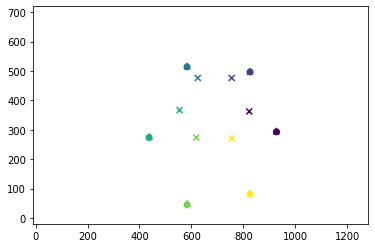

tensor(-814.9402, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7979, -0.5459,  1.0241,  0.0000,  0.0000, -0.2955]],
       device='cuda:0', grad_fn=<AddBackward0>)


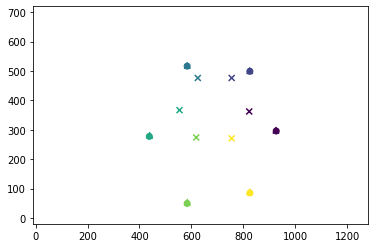

tensor(-803.1821, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7993, -0.5258,  1.0456,  0.0000,  0.0000, -0.2953]],
       device='cuda:0', grad_fn=<AddBackward0>)


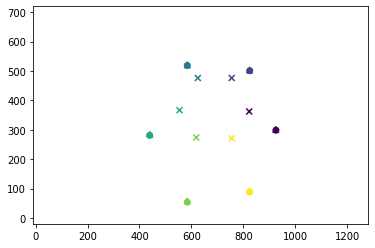

tensor(-791.9331, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8008, -0.5064,  1.0669,  0.0000,  0.0000, -0.2951]],
       device='cuda:0', grad_fn=<AddBackward0>)


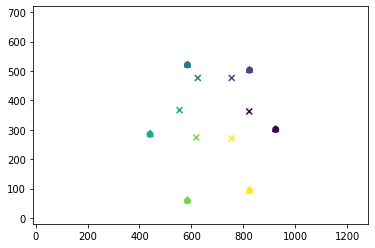

tensor(-781.0875, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8023, -0.4877,  1.0883,  0.0000,  0.0000, -0.2947]],
       device='cuda:0', grad_fn=<AddBackward0>)


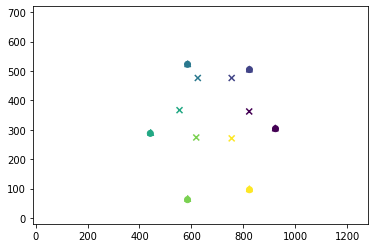

tensor(-770.6260, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8037, -0.4697,  1.1096,  0.0000,  0.0000, -0.2942]],
       device='cuda:0', grad_fn=<AddBackward0>)


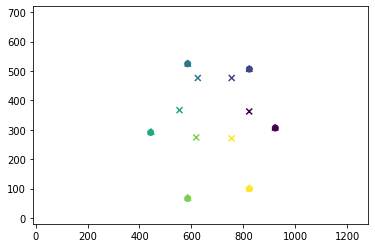

tensor(-760.5132, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8050, -0.4523,  1.1309,  0.0000,  0.0000, -0.2937]],
       device='cuda:0', grad_fn=<AddBackward0>)


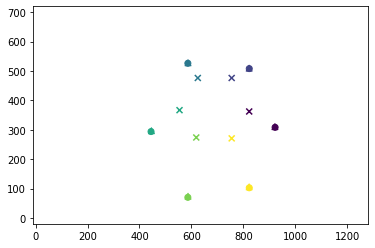

tensor(-750.7228, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8061, -0.4354,  1.1521,  0.0000,  0.0000, -0.2933]],
       device='cuda:0', grad_fn=<AddBackward0>)


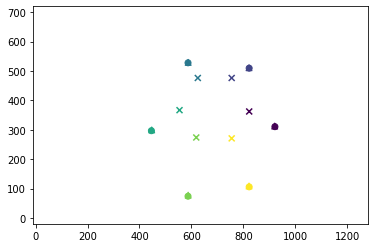

tensor(-741.2285, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8069, -0.4189,  1.1733,  0.0000,  0.0000, -0.2931]],
       device='cuda:0', grad_fn=<AddBackward0>)


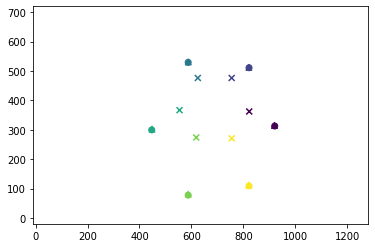

tensor(-732.0146, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8075, -0.4029,  1.1944,  0.0000,  0.0000, -0.2930]],
       device='cuda:0', grad_fn=<AddBackward0>)


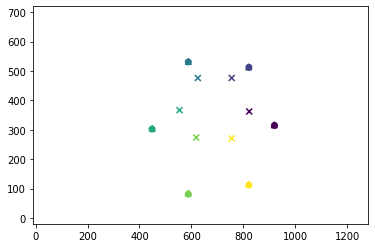

tensor(-723.0682, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8080, -0.3874,  1.2153,  0.0000,  0.0000, -0.2929]],
       device='cuda:0', grad_fn=<AddBackward0>)


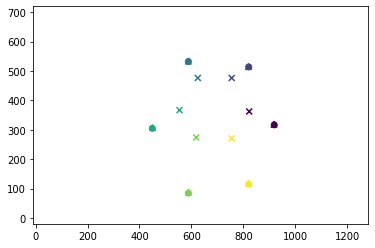

tensor(-714.4271, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8083, -0.3723,  1.2361,  0.0000,  0.0000, -0.2925]],
       device='cuda:0', grad_fn=<AddBackward0>)


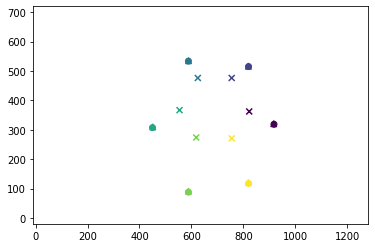

tensor(-706.0732, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8083, -0.3578,  1.2567,  0.0000,  0.0000, -0.2919]],
       device='cuda:0', grad_fn=<AddBackward0>)


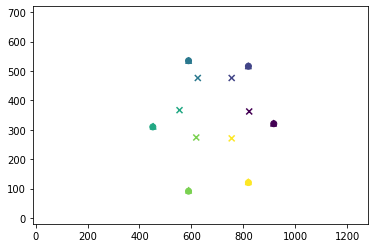

tensor(-697.9900, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8082, -0.3437,  1.2771,  0.0000,  0.0000, -0.2912]],
       device='cuda:0', grad_fn=<AddBackward0>)


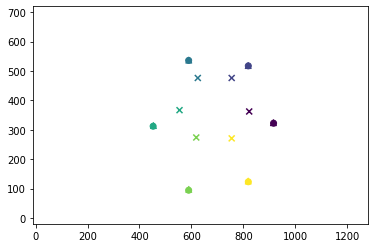

tensor(-690.1625, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8078, -0.3301,  1.2974,  0.0000,  0.0000, -0.2904]],
       device='cuda:0', grad_fn=<AddBackward0>)


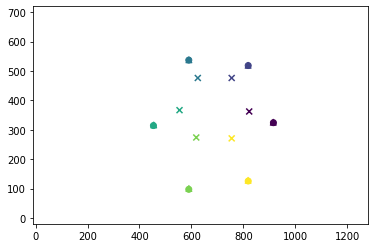

tensor(-682.5779, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8072, -0.3170,  1.3175,  0.0000,  0.0000, -0.2896]],
       device='cuda:0', grad_fn=<AddBackward0>)


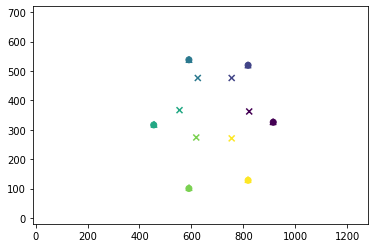

tensor(-675.2236, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8063, -0.3043,  1.3374,  0.0000,  0.0000, -0.2887]],
       device='cuda:0', grad_fn=<AddBackward0>)


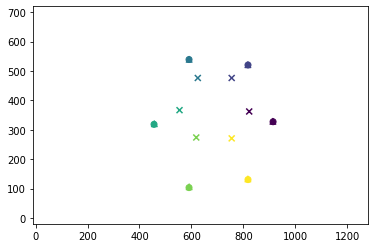

tensor(-668.0931, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8052, -0.2921,  1.3570,  0.0000,  0.0000, -0.2879]],
       device='cuda:0', grad_fn=<AddBackward0>)


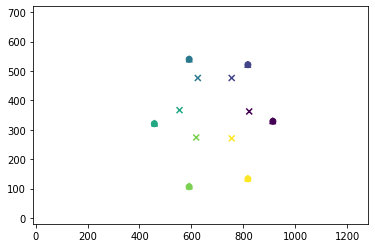

tensor(-661.1545, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8039, -0.2802,  1.3765,  0.0000,  0.0000, -0.2875]],
       device='cuda:0', grad_fn=<AddBackward0>)


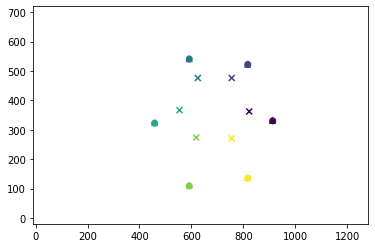

tensor(-654.3901, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8024, -0.2688,  1.3958,  0.0000,  0.0000, -0.2872]],
       device='cuda:0', grad_fn=<AddBackward0>)


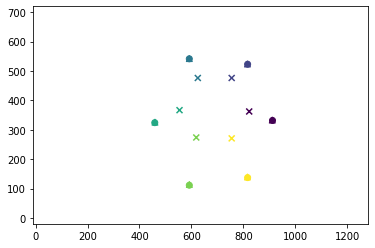

tensor(-647.8000, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.8008, -0.2578,  1.4150,  0.0000,  0.0000, -0.2870]],
       device='cuda:0', grad_fn=<AddBackward0>)


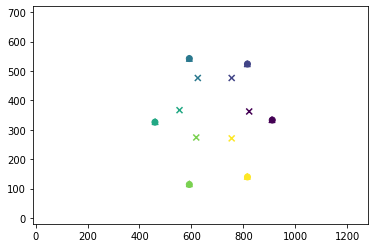

tensor(-641.4136, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7991, -0.2473,  1.4340,  0.0000,  0.0000, -0.2865]],
       device='cuda:0', grad_fn=<AddBackward0>)


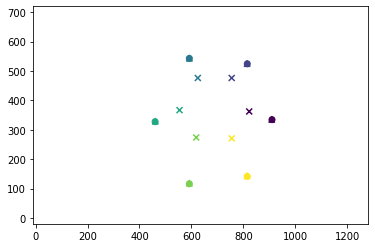

tensor(-635.2169, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7973, -0.2371,  1.4527,  0.0000,  0.0000, -0.2860]],
       device='cuda:0', grad_fn=<AddBackward0>)


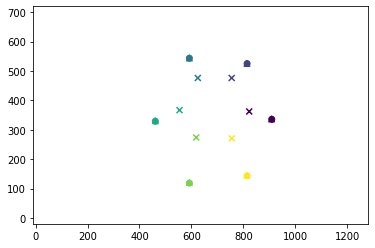

tensor(-629.1967, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7953, -0.2274,  1.4714,  0.0000,  0.0000, -0.2854]],
       device='cuda:0', grad_fn=<AddBackward0>)


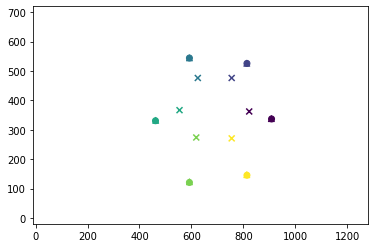

tensor(-623.3413, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7933, -0.2180,  1.4898,  0.0000,  0.0000, -0.2847]],
       device='cuda:0', grad_fn=<AddBackward0>)


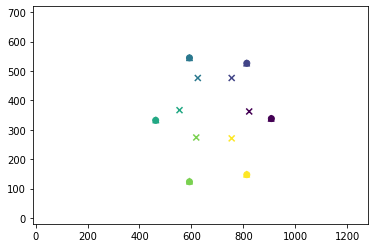

tensor(-617.6430, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7911, -0.2090,  1.5080,  0.0000,  0.0000, -0.2841]],
       device='cuda:0', grad_fn=<AddBackward0>)


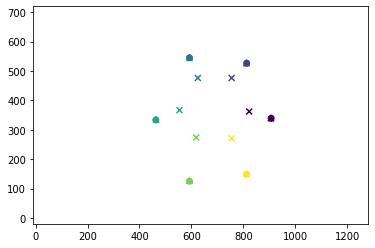

tensor(-612.0865, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7889, -0.2004,  1.5261,  0.0000,  0.0000, -0.2834]],
       device='cuda:0', grad_fn=<AddBackward0>)


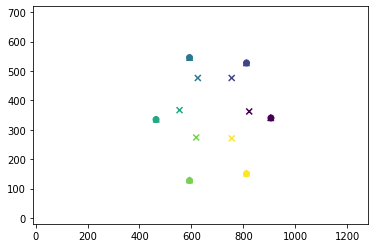

tensor(-606.6671, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7865, -0.1922,  1.5440,  0.0000,  0.0000, -0.2828]],
       device='cuda:0', grad_fn=<AddBackward0>)


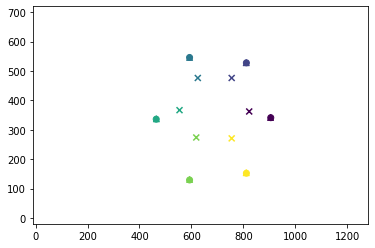

tensor(-601.3413, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7841, -0.1842,  1.5618,  0.0000,  0.0000, -0.2824]],
       device='cuda:0', grad_fn=<AddBackward0>)


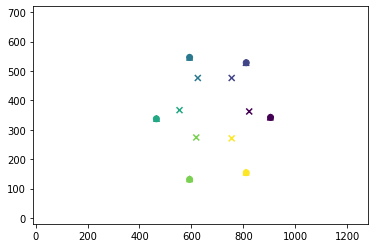

tensor(-596.1085, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7818, -0.1765,  1.5796,  0.0000,  0.0000, -0.2822]],
       device='cuda:0', grad_fn=<AddBackward0>)


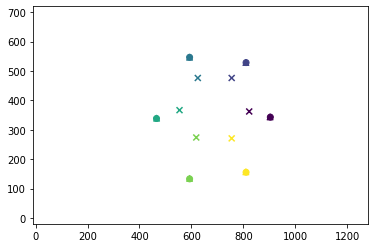

tensor(-590.9736, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7795, -0.1691,  1.5972,  0.0000,  0.0000, -0.2820]],
       device='cuda:0', grad_fn=<AddBackward0>)


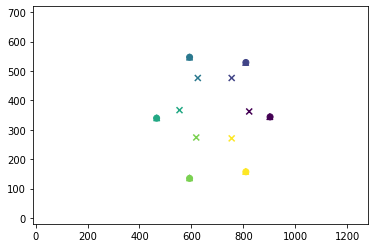

tensor(-585.9360, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7774, -0.1619,  1.6148,  0.0000,  0.0000, -0.2819]],
       device='cuda:0', grad_fn=<AddBackward0>)


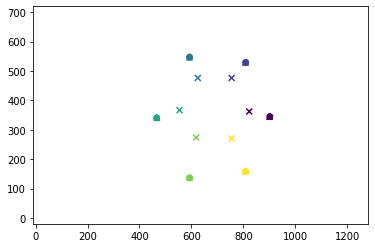

tensor(-580.9875, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7752, -0.1549,  1.6324,  0.0000,  0.0000, -0.2817]],
       device='cuda:0', grad_fn=<AddBackward0>)


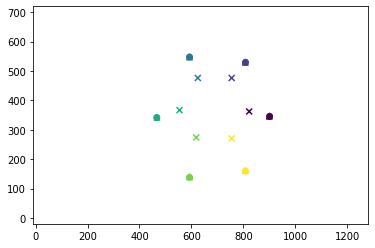

tensor(-576.1122, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7732, -0.1482,  1.6499,  0.0000,  0.0000, -0.2815]],
       device='cuda:0', grad_fn=<AddBackward0>)


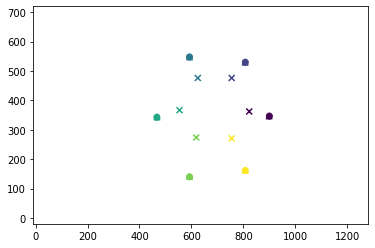

tensor(-571.3398, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7711, -0.1415,  1.6673,  0.0000,  0.0000, -0.2810]],
       device='cuda:0', grad_fn=<AddBackward0>)


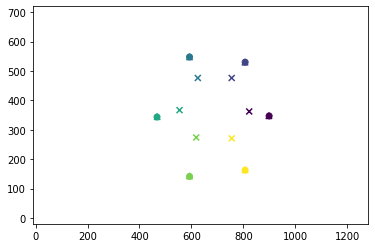

tensor(-566.6747, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7689, -0.1350,  1.6845,  0.0000,  0.0000, -0.2805]],
       device='cuda:0', grad_fn=<AddBackward0>)


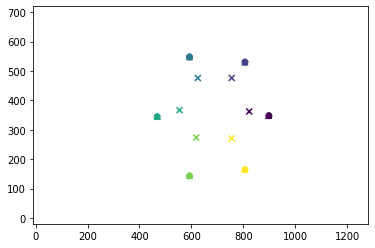

tensor(-562.1099, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7667, -0.1287,  1.7015,  0.0000,  0.0000, -0.2799]],
       device='cuda:0', grad_fn=<AddBackward0>)


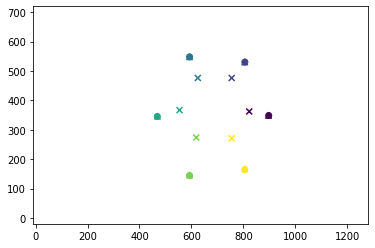

tensor(-557.6415, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7643, -0.1224,  1.7183,  0.0000,  0.0000, -0.2793]],
       device='cuda:0', grad_fn=<AddBackward0>)


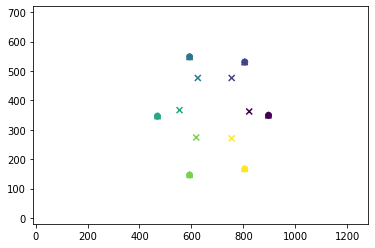

tensor(-553.2661, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7619, -0.1163,  1.7350,  0.0000,  0.0000, -0.2786]],
       device='cuda:0', grad_fn=<AddBackward0>)


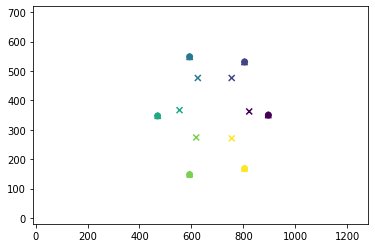

tensor(-548.9810, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7594, -0.1103,  1.7514,  0.0000,  0.0000, -0.2779]],
       device='cuda:0', grad_fn=<AddBackward0>)


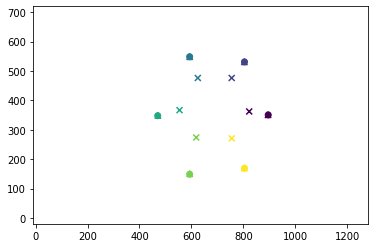

tensor(-544.7842, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7568, -0.1045,  1.7677,  0.0000,  0.0000, -0.2772]],
       device='cuda:0', grad_fn=<AddBackward0>)


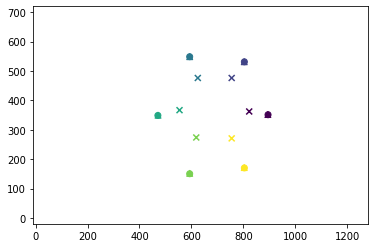

tensor(-540.6759, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7541, -0.0987,  1.7838,  0.0000,  0.0000, -0.2765]],
       device='cuda:0', grad_fn=<AddBackward0>)


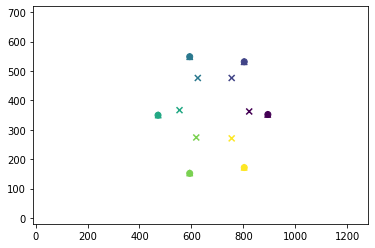

tensor(-536.6535, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7513, -0.0931,  1.7997,  0.0000,  0.0000, -0.2757]],
       device='cuda:0', grad_fn=<AddBackward0>)


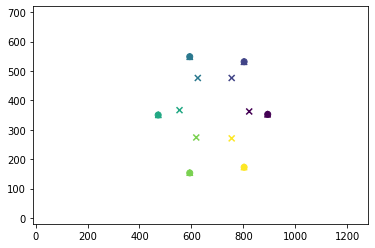

tensor(-532.7229, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7484, -0.0876,  1.8154,  0.0000,  0.0000, -0.2748]],
       device='cuda:0', grad_fn=<AddBackward0>)


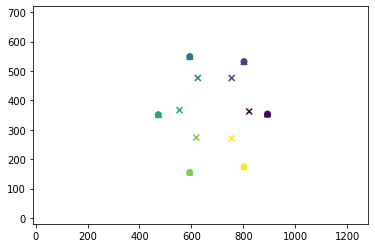

tensor(-528.9074, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7455, -0.0823,  1.8309,  0.0000,  0.0000, -0.2736]],
       device='cuda:0', grad_fn=<AddBackward0>)


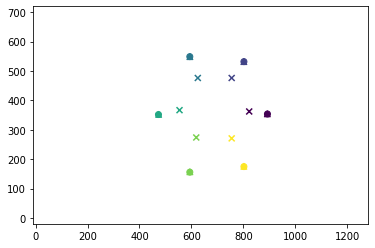

tensor(-525.1929, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7426, -0.0771,  1.8461,  0.0000,  0.0000, -0.2724]],
       device='cuda:0', grad_fn=<AddBackward0>)


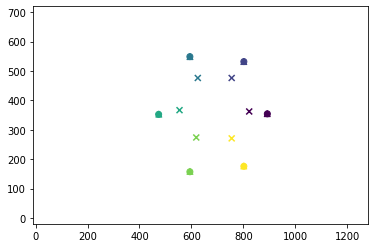

tensor(-521.5726, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7397, -0.0722,  1.8611,  0.0000,  0.0000, -0.2711]],
       device='cuda:0', grad_fn=<AddBackward0>)


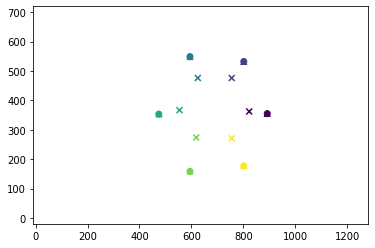

tensor(-518.0420, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7368, -0.0674,  1.8759,  0.0000,  0.0000, -0.2698]],
       device='cuda:0', grad_fn=<AddBackward0>)


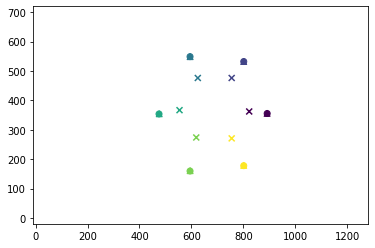

tensor(-514.5970, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7338, -0.0628,  1.8904,  0.0000,  0.0000, -0.2685]],
       device='cuda:0', grad_fn=<AddBackward0>)


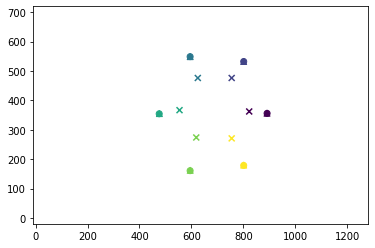

tensor(-511.2354, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7308, -0.0584,  1.9048,  0.0000,  0.0000, -0.2672]],
       device='cuda:0', grad_fn=<AddBackward0>)


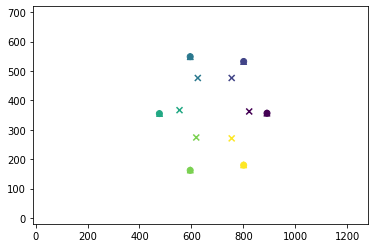

tensor(-507.9533, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7277, -0.0541,  1.9189,  0.0000,  0.0000, -0.2659]],
       device='cuda:0', grad_fn=<AddBackward0>)


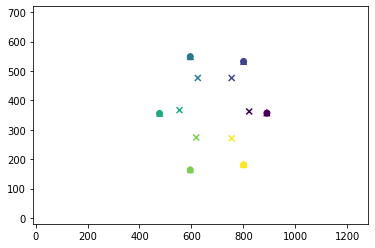

tensor(-504.7489, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7247, -0.0499,  1.9328,  0.0000,  0.0000, -0.2647]],
       device='cuda:0', grad_fn=<AddBackward0>)


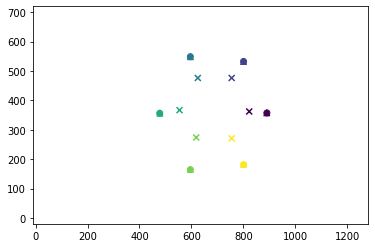

tensor(-501.6191, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7215, -0.0459,  1.9465,  0.0000,  0.0000, -0.2634]],
       device='cuda:0', grad_fn=<AddBackward0>)


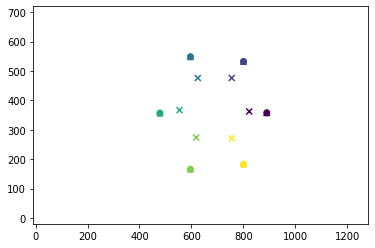

tensor(-498.5617, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7184, -0.0421,  1.9599,  0.0000,  0.0000, -0.2621]],
       device='cuda:0', grad_fn=<AddBackward0>)


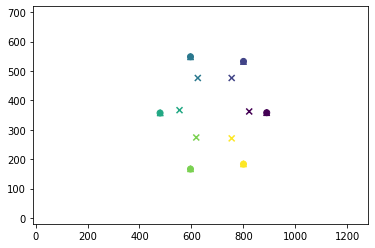

tensor(-495.5746, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7152, -0.0383,  1.9732,  0.0000,  0.0000, -0.2608]],
       device='cuda:0', grad_fn=<AddBackward0>)


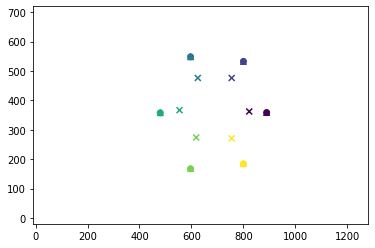

tensor(-492.6555, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7120, -0.0347,  1.9863,  0.0000,  0.0000, -0.2596]],
       device='cuda:0', grad_fn=<AddBackward0>)


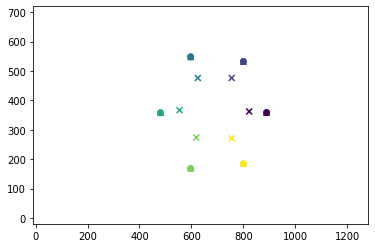

tensor(-489.8020, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7088, -0.0312,  1.9992,  0.0000,  0.0000, -0.2583]],
       device='cuda:0', grad_fn=<AddBackward0>)


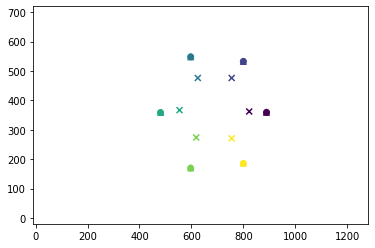

tensor(-487.0129, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7055, -0.0279,  2.0119,  0.0000,  0.0000, -0.2570]],
       device='cuda:0', grad_fn=<AddBackward0>)


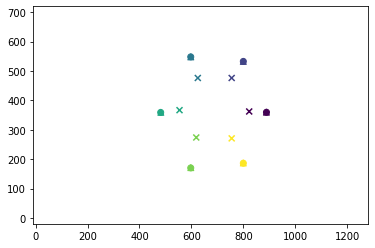

tensor(-484.2856, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.7022, -0.0246,  2.0244,  0.0000,  0.0000, -0.2558]],
       device='cuda:0', grad_fn=<AddBackward0>)


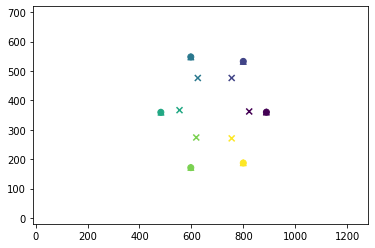

tensor(-481.6188, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.6989, -0.0215,  2.0367,  0.0000,  0.0000, -0.2545]],
       device='cuda:0', grad_fn=<AddBackward0>)


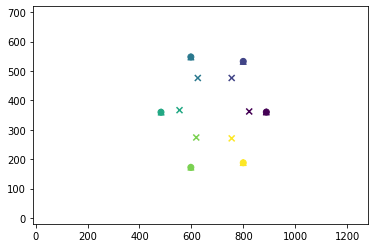

tensor(-479.0192, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.6956, -0.0185,  2.0488,  0.0000,  0.0000, -0.2532]],
       device='cuda:0', grad_fn=<AddBackward0>)


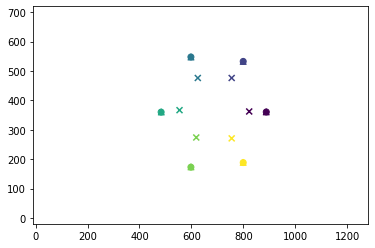

tensor(-476.4868, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.6923, -0.0157,  2.0607,  0.0000,  0.0000, -0.2518]],
       device='cuda:0', grad_fn=<AddBackward0>)


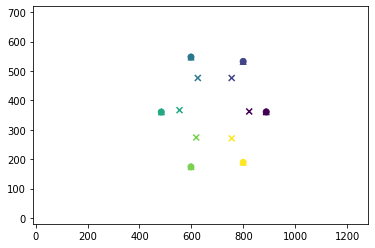

tensor(-474.0131, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.6890, -0.0131,  2.0725,  0.0000,  0.0000, -0.2503]],
       device='cuda:0', grad_fn=<AddBackward0>)


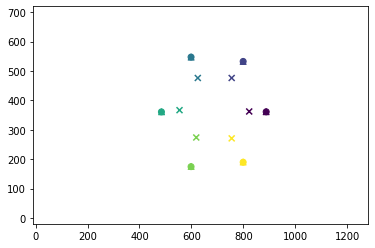

tensor(-471.6179, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.6857, -0.0107,  2.0840,  0.0000,  0.0000, -0.2488]],
       device='cuda:0', grad_fn=<AddBackward0>)


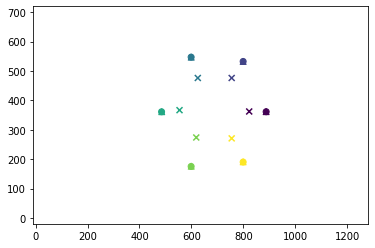

tensor(-469.2943, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.6823, -0.0084,  2.0953,  0.0000,  0.0000, -0.2473]],
       device='cuda:0', grad_fn=<AddBackward0>)


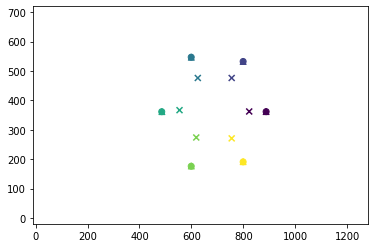

tensor(-467.0372, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.6789, -0.0063,  2.1063,  0.0000,  0.0000, -0.2458]],
       device='cuda:0', grad_fn=<AddBackward0>)


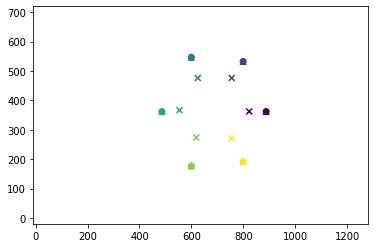

tensor(-464.8331, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.6755, -0.0043,  2.1172,  0.0000,  0.0000, -0.2443]],
       device='cuda:0', grad_fn=<AddBackward0>)


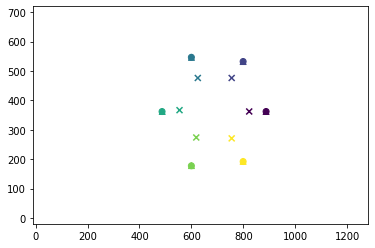

tensor(-462.6505, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.6719, -0.0024,  2.1278,  0.0000,  0.0000, -0.2430]],
       device='cuda:0', grad_fn=<AddBackward0>)


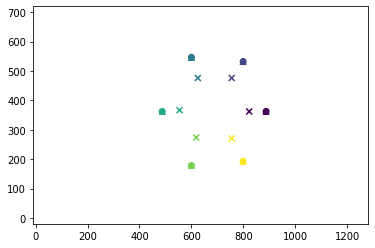

tensor(-460.5042, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.6684e+00, -4.2253e-04,  2.1383e+00,  0.0000e+00,  0.0000e+00,
         -2.4177e-01]], device='cuda:0', grad_fn=<AddBackward0>)


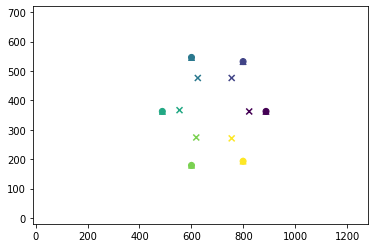

tensor(-458.3997, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.6647e+00,  1.4918e-03,  2.1486e+00,  0.0000e+00,  0.0000e+00,
         -2.4055e-01]], device='cuda:0', grad_fn=<AddBackward0>)


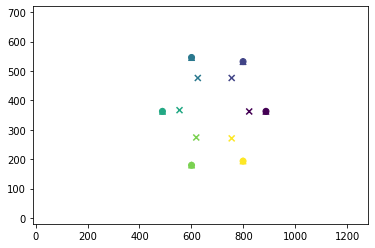

tensor(-456.3377, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.6611,  0.0034,  2.1587,  0.0000,  0.0000, -0.2393]],
       device='cuda:0', grad_fn=<AddBackward0>)


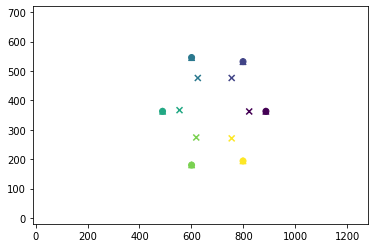

tensor(-454.3185, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.6573,  0.0053,  2.1689,  0.0000,  0.0000, -0.2378]],
       device='cuda:0', grad_fn=<AddBackward0>)


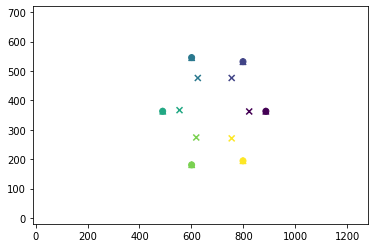

tensor(-452.3070, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.6535,  0.0071,  2.1791,  0.0000,  0.0000, -0.2363]],
       device='cuda:0', grad_fn=<AddBackward0>)


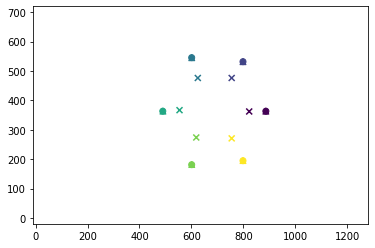

tensor(-450.3056, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.6496,  0.0090,  2.1894,  0.0000,  0.0000, -0.2347]],
       device='cuda:0', grad_fn=<AddBackward0>)


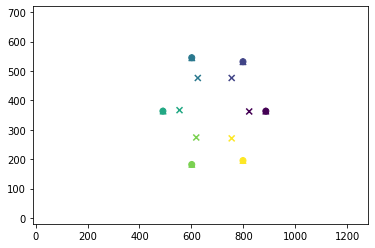

tensor(-448.3084, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.6458,  0.0107,  2.1998,  0.0000,  0.0000, -0.2329]],
       device='cuda:0', grad_fn=<AddBackward0>)


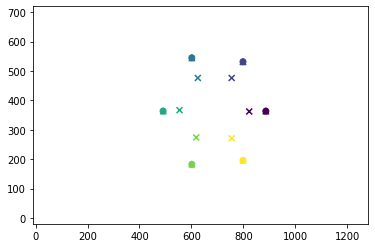

tensor(-446.3073, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.6419,  0.0125,  2.2103,  0.0000,  0.0000, -0.2311]],
       device='cuda:0', grad_fn=<AddBackward0>)


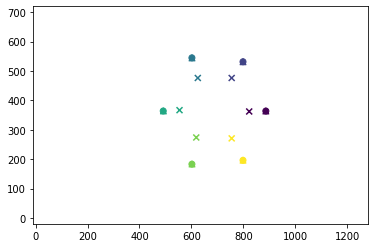

tensor(-444.3001, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.6380,  0.0142,  2.2209,  0.0000,  0.0000, -0.2293]],
       device='cuda:0', grad_fn=<AddBackward0>)


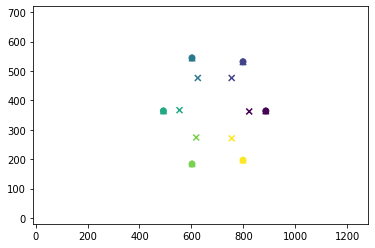

tensor(-442.2904, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.6341,  0.0159,  2.2316,  0.0000,  0.0000, -0.2276]],
       device='cuda:0', grad_fn=<AddBackward0>)


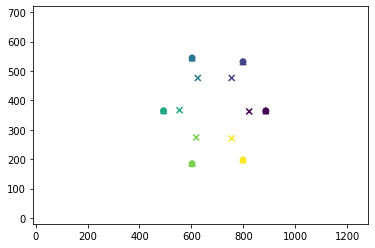

tensor(-440.2808, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.6301,  0.0175,  2.2424,  0.0000,  0.0000, -0.2258]],
       device='cuda:0', grad_fn=<AddBackward0>)


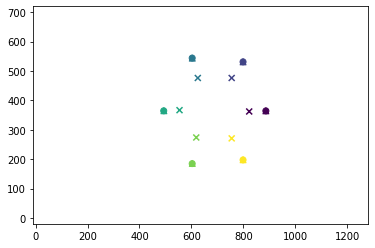

tensor(-438.2713, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.6261,  0.0191,  2.2532,  0.0000,  0.0000, -0.2240]],
       device='cuda:0', grad_fn=<AddBackward0>)


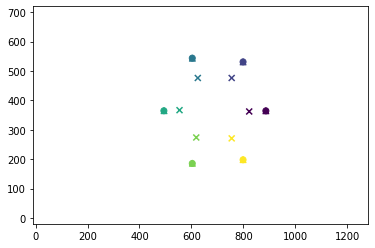

tensor(-436.2625, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.6220,  0.0207,  2.2641,  0.0000,  0.0000, -0.2221]],
       device='cuda:0', grad_fn=<AddBackward0>)


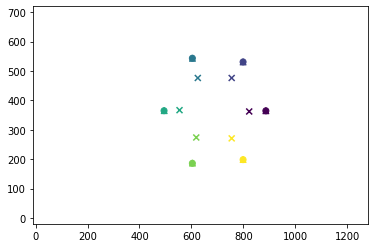

tensor(-434.2545, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.6180,  0.0222,  2.2751,  0.0000,  0.0000, -0.2203]],
       device='cuda:0', grad_fn=<AddBackward0>)


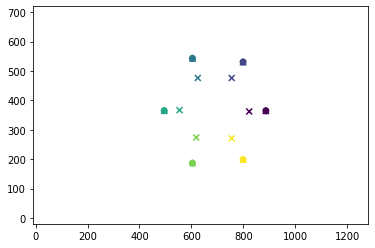

tensor(-432.2471, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.6139,  0.0237,  2.2862,  0.0000,  0.0000, -0.2185]],
       device='cuda:0', grad_fn=<AddBackward0>)


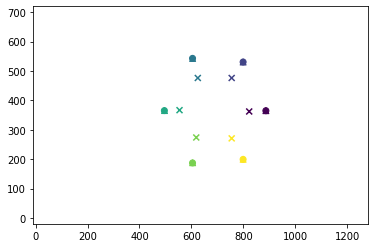

tensor(-430.2452, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.6097,  0.0252,  2.2973,  0.0000,  0.0000, -0.2166]],
       device='cuda:0', grad_fn=<AddBackward0>)


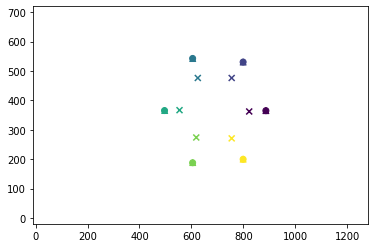

tensor(-428.2488, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.6055,  0.0266,  2.3084,  0.0000,  0.0000, -0.2147]],
       device='cuda:0', grad_fn=<AddBackward0>)


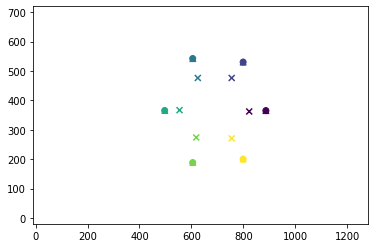

tensor(-426.2572, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.6011,  0.0279,  2.3196,  0.0000,  0.0000, -0.2128]],
       device='cuda:0', grad_fn=<AddBackward0>)


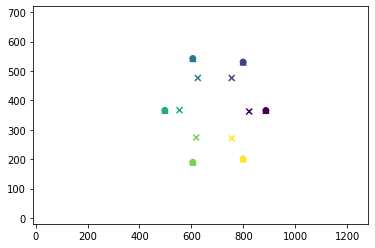

tensor(-424.2710, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.5967,  0.0292,  2.3309,  0.0000,  0.0000, -0.2109]],
       device='cuda:0', grad_fn=<AddBackward0>)


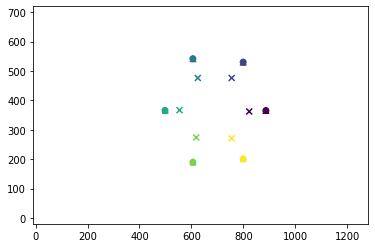

tensor(-422.2893, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.5922,  0.0305,  2.3422,  0.0000,  0.0000, -0.2089]],
       device='cuda:0', grad_fn=<AddBackward0>)


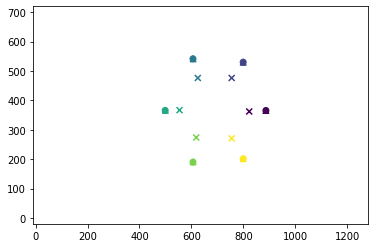

tensor(-420.3126, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.5875,  0.0317,  2.3535,  0.0000,  0.0000, -0.2070]],
       device='cuda:0', grad_fn=<AddBackward0>)


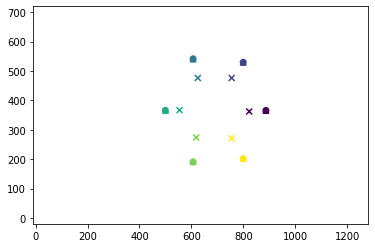

tensor(-418.3404, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.5828,  0.0329,  2.3649,  0.0000,  0.0000, -0.2050]],
       device='cuda:0', grad_fn=<AddBackward0>)


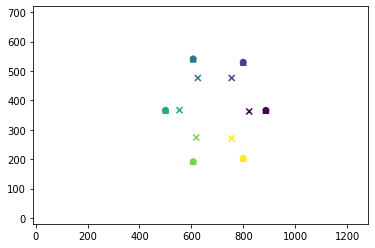

tensor(-416.3735, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.5781,  0.0340,  2.3764,  0.0000,  0.0000, -0.2029]],
       device='cuda:0', grad_fn=<AddBackward0>)


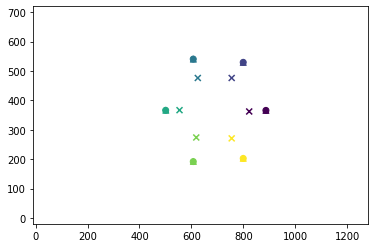

tensor(-414.4113, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.5732,  0.0351,  2.3879,  0.0000,  0.0000, -0.2009]],
       device='cuda:0', grad_fn=<AddBackward0>)


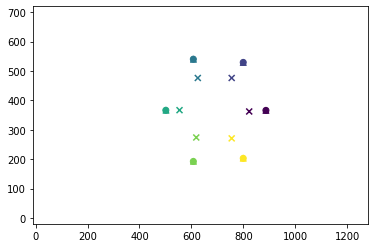

tensor(-412.4541, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.5682,  0.0361,  2.3994,  0.0000,  0.0000, -0.1988]],
       device='cuda:0', grad_fn=<AddBackward0>)


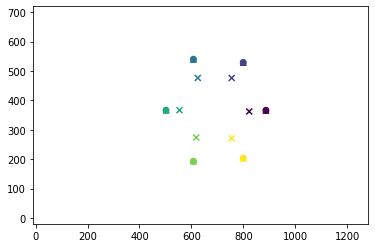

tensor(-410.5022, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.5632,  0.0371,  2.4110,  0.0000,  0.0000, -0.1968]],
       device='cuda:0', grad_fn=<AddBackward0>)


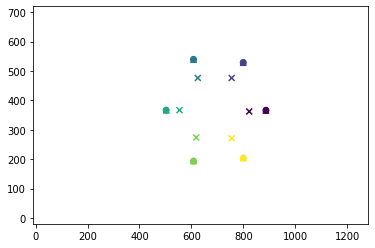

tensor(-408.5551, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.5581,  0.0381,  2.4227,  0.0000,  0.0000, -0.1947]],
       device='cuda:0', grad_fn=<AddBackward0>)


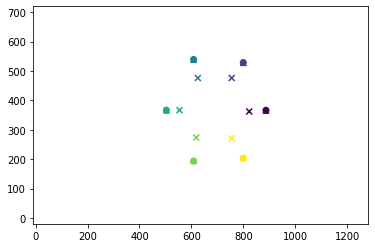

tensor(-406.6135, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.5528,  0.0391,  2.4344,  0.0000,  0.0000, -0.1925]],
       device='cuda:0', grad_fn=<AddBackward0>)


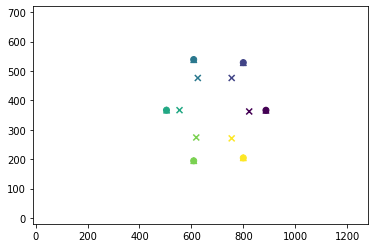

tensor(-404.6771, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.5475,  0.0400,  2.4461,  0.0000,  0.0000, -0.1904]],
       device='cuda:0', grad_fn=<AddBackward0>)


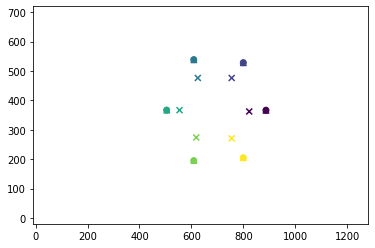

tensor(-402.7465, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.5422,  0.0409,  2.4579,  0.0000,  0.0000, -0.1882]],
       device='cuda:0', grad_fn=<AddBackward0>)


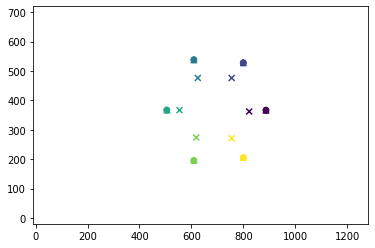

tensor(-400.8350, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.5367,  0.0417,  2.4698,  0.0000,  0.0000, -0.1859]],
       device='cuda:0', grad_fn=<AddBackward0>)


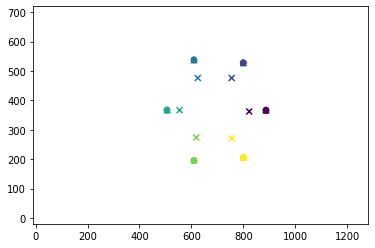

tensor(-398.9334, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.5311,  0.0425,  2.4817,  0.0000,  0.0000, -0.1837]],
       device='cuda:0', grad_fn=<AddBackward0>)


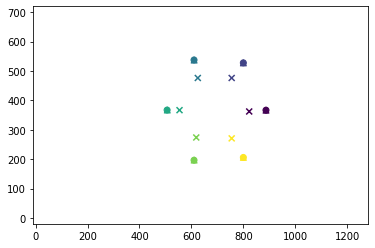

tensor(-397.0781, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.5255,  0.0433,  2.4937,  0.0000,  0.0000, -0.1812]],
       device='cuda:0', grad_fn=<AddBackward0>)


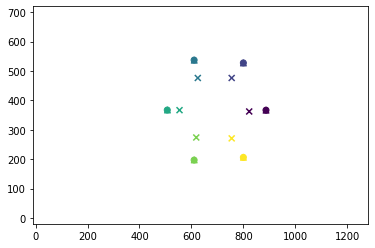

tensor(-395.2616, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.5197,  0.0441,  2.5057,  0.0000,  0.0000, -0.1786]],
       device='cuda:0', grad_fn=<AddBackward0>)


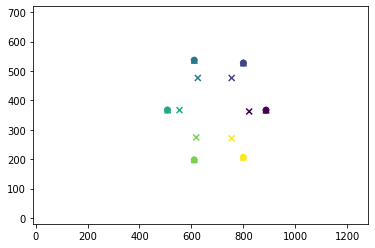

tensor(-393.4656, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.5138,  0.0448,  2.5178,  0.0000,  0.0000, -0.1760]],
       device='cuda:0', grad_fn=<AddBackward0>)


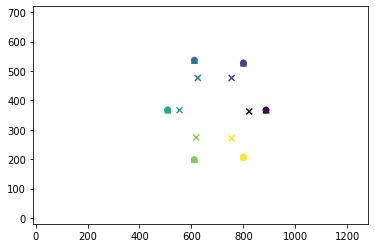

tensor(-391.6749, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.5078,  0.0454,  2.5299,  0.0000,  0.0000, -0.1733]],
       device='cuda:0', grad_fn=<AddBackward0>)


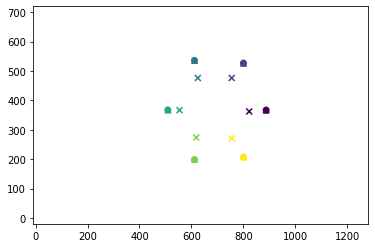

tensor(-389.8722, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.5016,  0.0460,  2.5421,  0.0000,  0.0000, -0.1707]],
       device='cuda:0', grad_fn=<AddBackward0>)


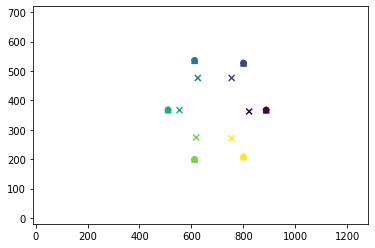

tensor(-388.0733, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.4953,  0.0467,  2.5543,  0.0000,  0.0000, -0.1680]],
       device='cuda:0', grad_fn=<AddBackward0>)


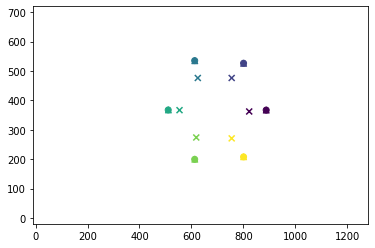

tensor(-386.2851, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.4888,  0.0473,  2.5665,  0.0000,  0.0000, -0.1654]],
       device='cuda:0', grad_fn=<AddBackward0>)


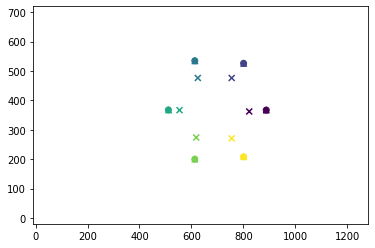

tensor(-384.5101, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.4822,  0.0478,  2.5788,  0.0000,  0.0000, -0.1627]],
       device='cuda:0', grad_fn=<AddBackward0>)


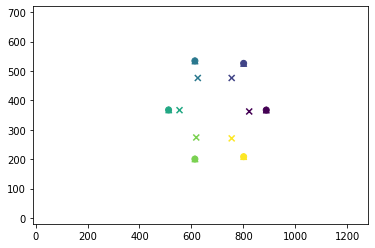

tensor(-382.7482, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.4754,  0.0484,  2.5910,  0.0000,  0.0000, -0.1599]],
       device='cuda:0', grad_fn=<AddBackward0>)


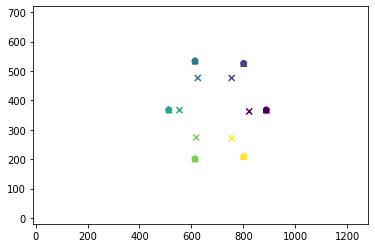

tensor(-381.0008, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.4685,  0.0489,  2.6033,  0.0000,  0.0000, -0.1572]],
       device='cuda:0', grad_fn=<AddBackward0>)


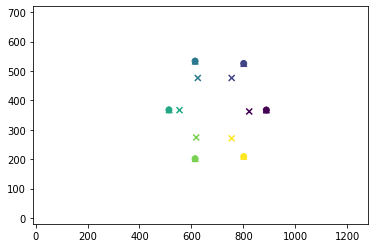

tensor(-379.2679, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.4615,  0.0494,  2.6156,  0.0000,  0.0000, -0.1544]],
       device='cuda:0', grad_fn=<AddBackward0>)


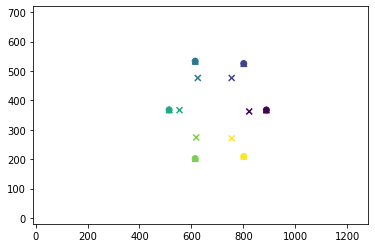

tensor(-377.5495, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.4543,  0.0499,  2.6280,  0.0000,  0.0000, -0.1515]],
       device='cuda:0', grad_fn=<AddBackward0>)


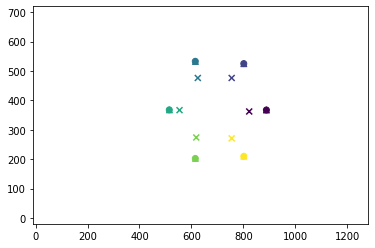

tensor(-375.8464, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.4470,  0.0504,  2.6403,  0.0000,  0.0000, -0.1487]],
       device='cuda:0', grad_fn=<AddBackward0>)


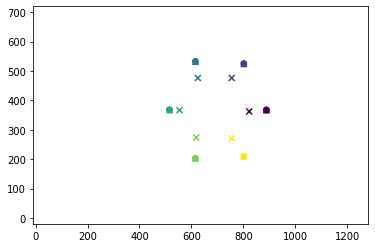

tensor(-374.1575, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.4395,  0.0509,  2.6527,  0.0000,  0.0000, -0.1457]],
       device='cuda:0', grad_fn=<AddBackward0>)


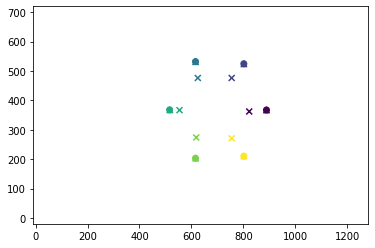

tensor(-372.4842, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.4319,  0.0513,  2.6651,  0.0000,  0.0000, -0.1428]],
       device='cuda:0', grad_fn=<AddBackward0>)


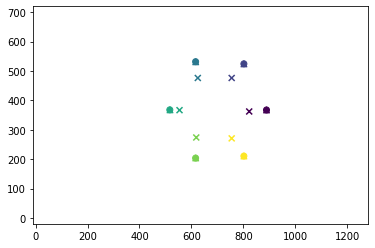

tensor(-370.8260, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.4241,  0.0517,  2.6775,  0.0000,  0.0000, -0.1398]],
       device='cuda:0', grad_fn=<AddBackward0>)


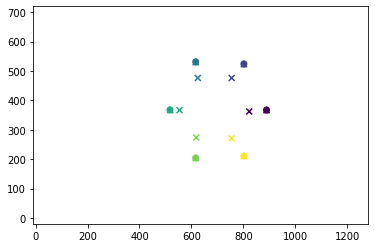

tensor(-369.1836, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.4161,  0.0521,  2.6899,  0.0000,  0.0000, -0.1368]],
       device='cuda:0', grad_fn=<AddBackward0>)


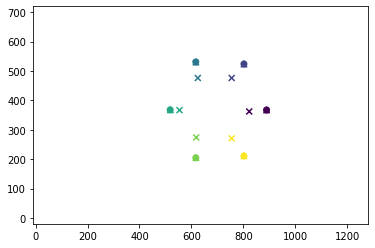

tensor(-367.5624, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.4081,  0.0525,  2.7023,  0.0000,  0.0000, -0.1337]],
       device='cuda:0', grad_fn=<AddBackward0>)


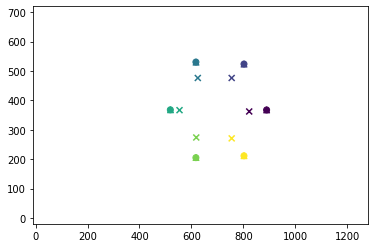

tensor(-365.9674, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.3999,  0.0530,  2.7147,  0.0000,  0.0000, -0.1306]],
       device='cuda:0', grad_fn=<AddBackward0>)


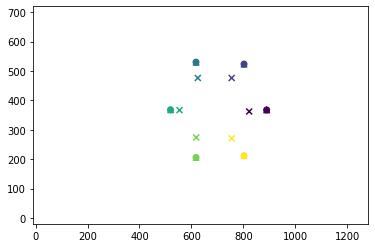

tensor(-364.3961, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.3915,  0.0537,  2.7270,  0.0000,  0.0000, -0.1275]],
       device='cuda:0', grad_fn=<AddBackward0>)


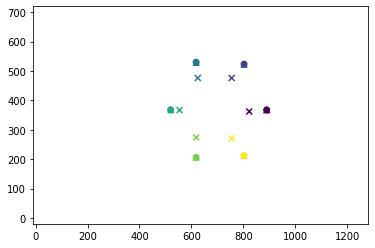

tensor(-362.8513, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.3831,  0.0545,  2.7393,  0.0000,  0.0000, -0.1243]],
       device='cuda:0', grad_fn=<AddBackward0>)


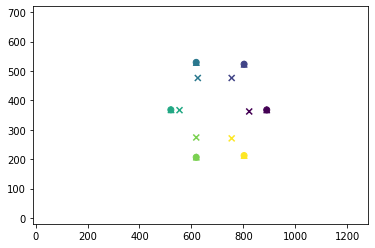

tensor(-361.3340, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.3745,  0.0553,  2.7515,  0.0000,  0.0000, -0.1212]],
       device='cuda:0', grad_fn=<AddBackward0>)


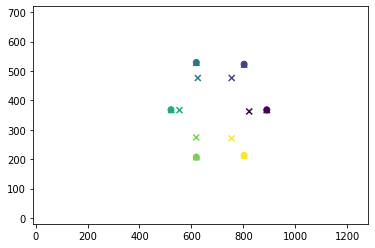

tensor(-359.8448, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.3658,  0.0563,  2.7637,  0.0000,  0.0000, -0.1180]],
       device='cuda:0', grad_fn=<AddBackward0>)


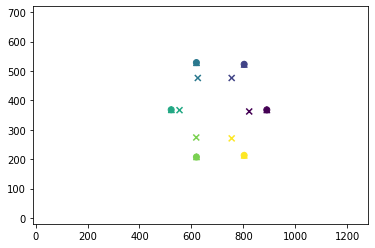

tensor(-358.3838, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.3569,  0.0574,  2.7758,  0.0000,  0.0000, -0.1147]],
       device='cuda:0', grad_fn=<AddBackward0>)


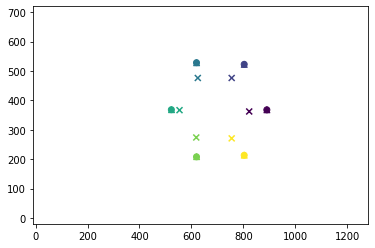

tensor(-356.9515, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.3480,  0.0587,  2.7879,  0.0000,  0.0000, -0.1114]],
       device='cuda:0', grad_fn=<AddBackward0>)


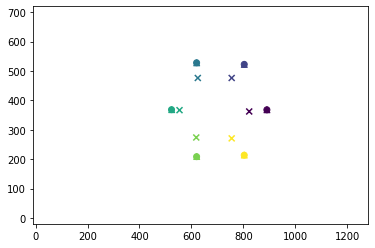

tensor(-355.5273, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.3389,  0.0600,  2.7998,  0.0000,  0.0000, -0.1082]],
       device='cuda:0', grad_fn=<AddBackward0>)


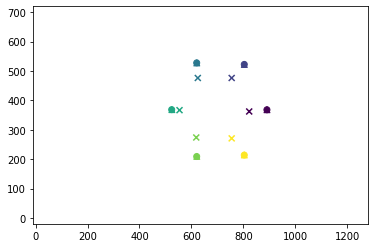

tensor(-354.0597, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.3297,  0.0615,  2.8117,  0.0000,  0.0000, -0.1051]],
       device='cuda:0', grad_fn=<AddBackward0>)


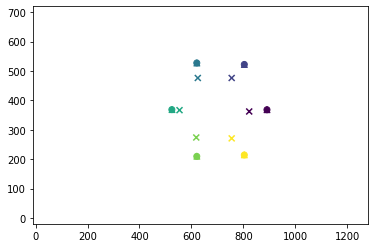

tensor(-352.5890, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.3205,  0.0630,  2.8235,  0.0000,  0.0000, -0.1020]],
       device='cuda:0', grad_fn=<AddBackward0>)


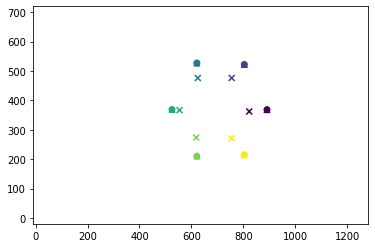

tensor(-351.1322, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.3112,  0.0647,  2.8352,  0.0000,  0.0000, -0.0990]],
       device='cuda:0', grad_fn=<AddBackward0>)


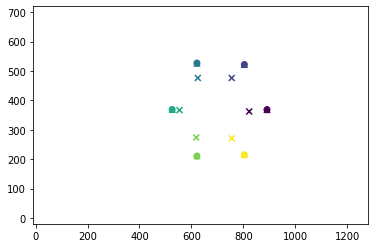

tensor(-349.6979, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.3018,  0.0665,  2.8468,  0.0000,  0.0000, -0.0959]],
       device='cuda:0', grad_fn=<AddBackward0>)


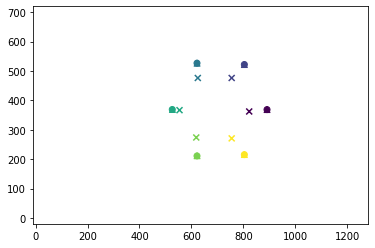

tensor(-348.2894, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.2924,  0.0684,  2.8582,  0.0000,  0.0000, -0.0929]],
       device='cuda:0', grad_fn=<AddBackward0>)


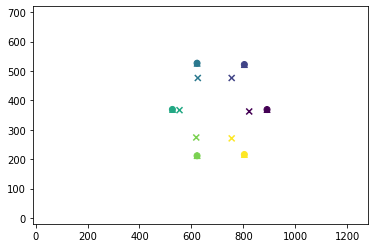

tensor(-346.9081, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.2829,  0.0704,  2.8696,  0.0000,  0.0000, -0.0898]],
       device='cuda:0', grad_fn=<AddBackward0>)


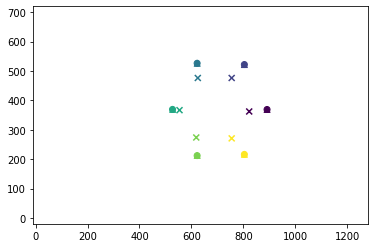

tensor(-345.5550, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.2734,  0.0725,  2.8808,  0.0000,  0.0000, -0.0868]],
       device='cuda:0', grad_fn=<AddBackward0>)


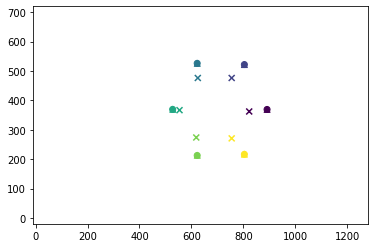

tensor(-344.2309, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.2638,  0.0746,  2.8919,  0.0000,  0.0000, -0.0838]],
       device='cuda:0', grad_fn=<AddBackward0>)


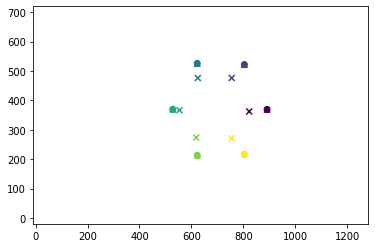

tensor(-342.9356, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.2542,  0.0769,  2.9030,  0.0000,  0.0000, -0.0807]],
       device='cuda:0', grad_fn=<AddBackward0>)


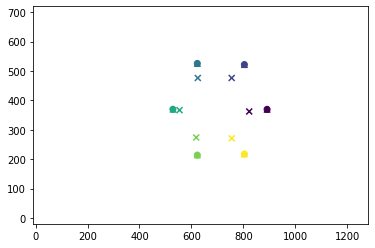

tensor(-341.6697, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.2446,  0.0793,  2.9139,  0.0000,  0.0000, -0.0777]],
       device='cuda:0', grad_fn=<AddBackward0>)


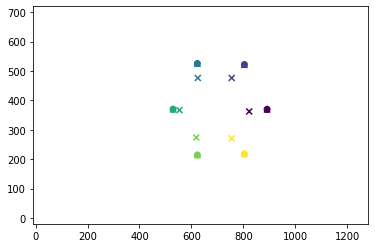

tensor(-340.4335, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.2349,  0.0817,  2.9247,  0.0000,  0.0000, -0.0746]],
       device='cuda:0', grad_fn=<AddBackward0>)


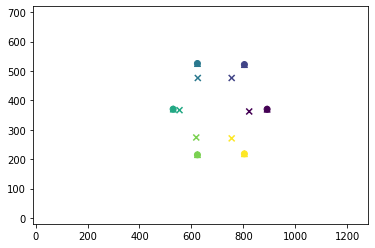

tensor(-339.2272, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.2251,  0.0842,  2.9353,  0.0000,  0.0000, -0.0716]],
       device='cuda:0', grad_fn=<AddBackward0>)


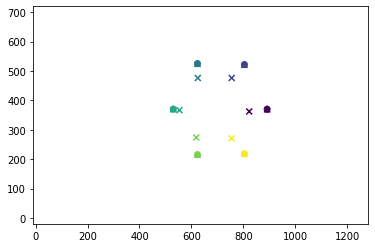

tensor(-338.0510, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.2153,  0.0869,  2.9459,  0.0000,  0.0000, -0.0685]],
       device='cuda:0', grad_fn=<AddBackward0>)


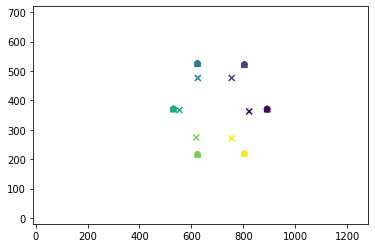

tensor(-336.9051, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.2055,  0.0896,  2.9563,  0.0000,  0.0000, -0.0655]],
       device='cuda:0', grad_fn=<AddBackward0>)


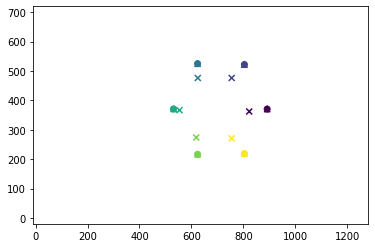

tensor(-335.7905, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.1957,  0.0923,  2.9667,  0.0000,  0.0000, -0.0624]],
       device='cuda:0', grad_fn=<AddBackward0>)


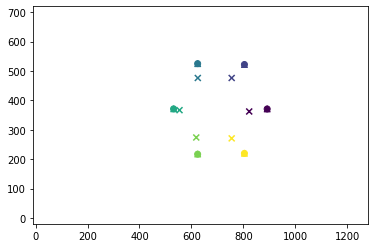

tensor(-334.7067, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.1858,  0.0952,  2.9769,  0.0000,  0.0000, -0.0594]],
       device='cuda:0', grad_fn=<AddBackward0>)


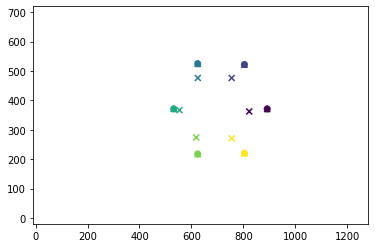

tensor(-333.5932, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.1759,  0.0981,  2.9870,  0.0000,  0.0000, -0.0564]],
       device='cuda:0', grad_fn=<AddBackward0>)


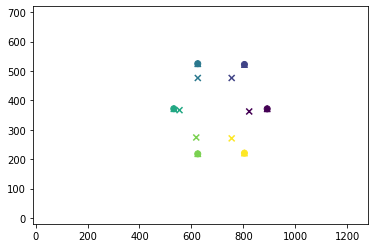

tensor(-332.4571, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.1660,  0.1012,  2.9970,  0.0000,  0.0000, -0.0536]],
       device='cuda:0', grad_fn=<AddBackward0>)


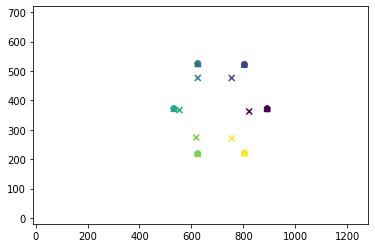

tensor(-331.3264, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.1560,  0.1043,  3.0070,  0.0000,  0.0000, -0.0508]],
       device='cuda:0', grad_fn=<AddBackward0>)


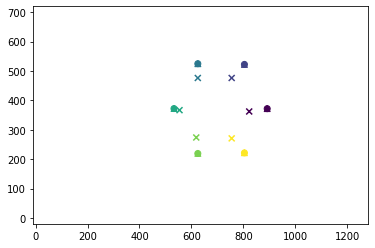

tensor(-330.2130, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.1461,  0.1076,  3.0169,  0.0000,  0.0000, -0.0480]],
       device='cuda:0', grad_fn=<AddBackward0>)


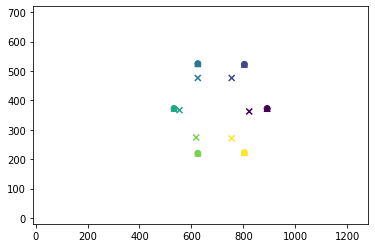

tensor(-329.1221, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.1363,  0.1109,  3.0267,  0.0000,  0.0000, -0.0452]],
       device='cuda:0', grad_fn=<AddBackward0>)


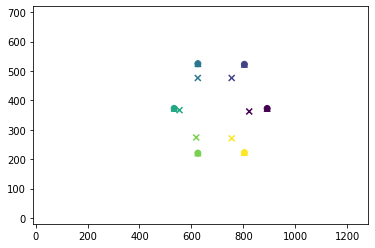

tensor(-328.0573, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.1264,  0.1144,  3.0364,  0.0000,  0.0000, -0.0424]],
       device='cuda:0', grad_fn=<AddBackward0>)


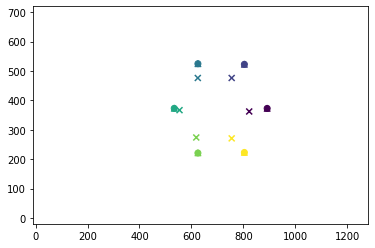

tensor(-327.0188, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.1165,  0.1179,  3.0461,  0.0000,  0.0000, -0.0397]],
       device='cuda:0', grad_fn=<AddBackward0>)


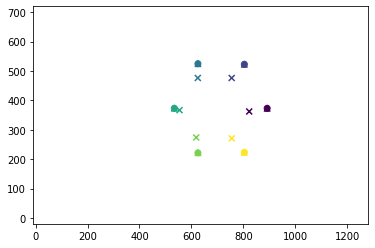

tensor(-326.0085, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.1067,  0.1215,  3.0556,  0.0000,  0.0000, -0.0369]],
       device='cuda:0', grad_fn=<AddBackward0>)


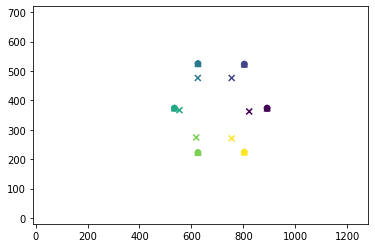

tensor(-325.0268, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.0969,  0.1252,  3.0651,  0.0000,  0.0000, -0.0342]],
       device='cuda:0', grad_fn=<AddBackward0>)


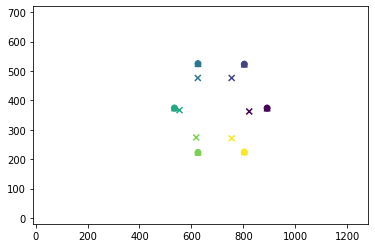

tensor(-324.0739, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.0871,  0.1290,  3.0745,  0.0000,  0.0000, -0.0315]],
       device='cuda:0', grad_fn=<AddBackward0>)


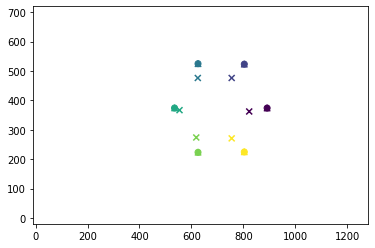

tensor(-323.1505, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.0773,  0.1328,  3.0838,  0.0000,  0.0000, -0.0288]],
       device='cuda:0', grad_fn=<AddBackward0>)


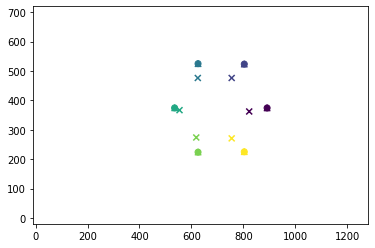

tensor(-322.2571, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.0676,  0.1367,  3.0930,  0.0000,  0.0000, -0.0261]],
       device='cuda:0', grad_fn=<AddBackward0>)


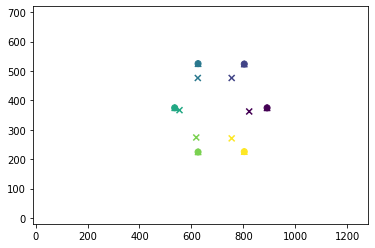

tensor(-321.3935, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.0579,  0.1407,  3.1022,  0.0000,  0.0000, -0.0234]],
       device='cuda:0', grad_fn=<AddBackward0>)


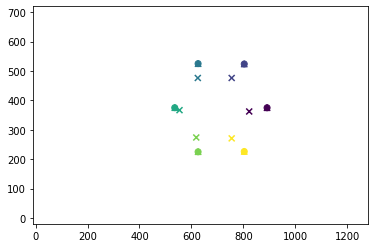

tensor(-320.5944, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.0481,  0.1447,  3.1113,  0.0000,  0.0000, -0.0207]],
       device='cuda:0', grad_fn=<AddBackward0>)


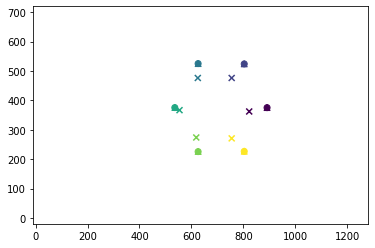

tensor(-319.8360, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.0383,  0.1487,  3.1204,  0.0000,  0.0000, -0.0178]],
       device='cuda:0', grad_fn=<AddBackward0>)


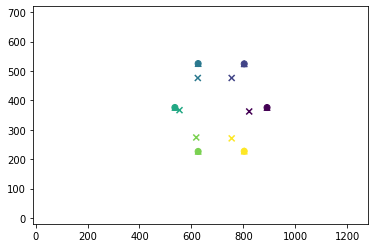

tensor(-319.0678, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.0284,  0.1526,  3.1295,  0.0000,  0.0000, -0.0151]],
       device='cuda:0', grad_fn=<AddBackward0>)


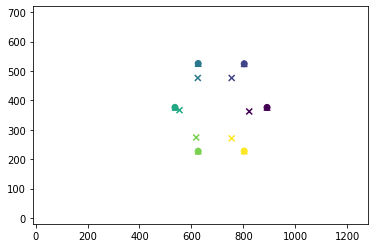

tensor(-318.3043, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.0185,  0.1564,  3.1387,  0.0000,  0.0000, -0.0123]],
       device='cuda:0', grad_fn=<AddBackward0>)


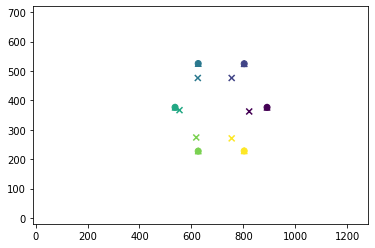

tensor(-317.4745, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 1.0084,  0.1601,  3.1479,  0.0000,  0.0000, -0.0095]],
       device='cuda:0', grad_fn=<AddBackward0>)


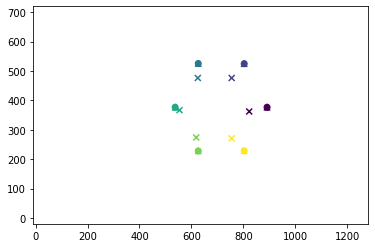

tensor(-316.6105, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 0.9983,  0.1637,  3.1572,  0.0000,  0.0000, -0.0068]],
       device='cuda:0', grad_fn=<AddBackward0>)


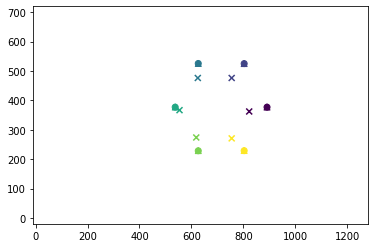

tensor(-315.7350, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 0.9882,  0.1672,  3.1666,  0.0000,  0.0000, -0.0041]],
       device='cuda:0', grad_fn=<AddBackward0>)


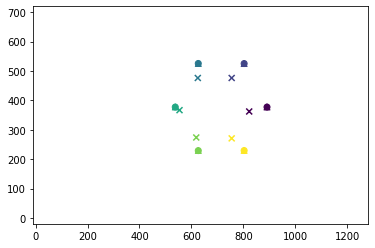

tensor(-314.8572, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[ 9.7795e-01,  1.7062e-01,  3.1760e+00,  0.0000e+00,  0.0000e+00,
         -1.4251e-03]], device='cuda:0', grad_fn=<AddBackward0>)


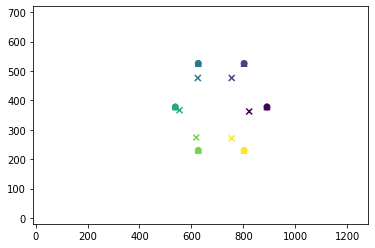

tensor(-313.9804, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[9.6768e-01, 1.7396e-01, 3.1855e+00, 0.0000e+00, 0.0000e+00, 1.3033e-03]],
       device='cuda:0', grad_fn=<AddBackward0>)


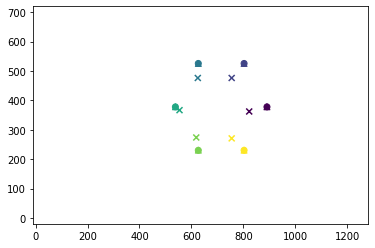

tensor(-313.1062, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.9574, 0.1772, 3.1951, 0.0000, 0.0000, 0.0041]], device='cuda:0',
       grad_fn=<AddBackward0>)


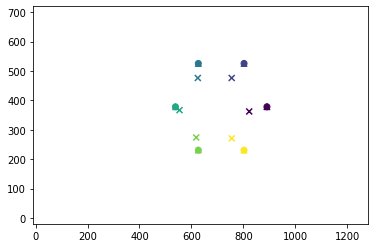

tensor(-312.2351, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.9470, 0.1804, 3.2047, 0.0000, 0.0000, 0.0068]], device='cuda:0',
       grad_fn=<AddBackward0>)


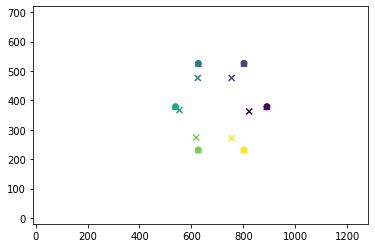

tensor(-311.3671, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.9365, 0.1835, 3.2145, 0.0000, 0.0000, 0.0096]], device='cuda:0',
       grad_fn=<AddBackward0>)


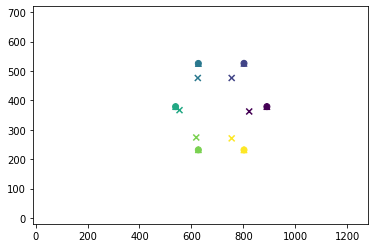

tensor(-310.5023, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.9260, 0.1866, 3.2243, 0.0000, 0.0000, 0.0124]], device='cuda:0',
       grad_fn=<AddBackward0>)


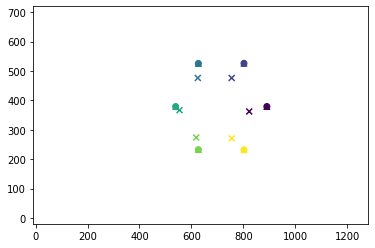

tensor(-309.6408, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.9154, 0.1895, 3.2341, 0.0000, 0.0000, 0.0153]], device='cuda:0',
       grad_fn=<AddBackward0>)


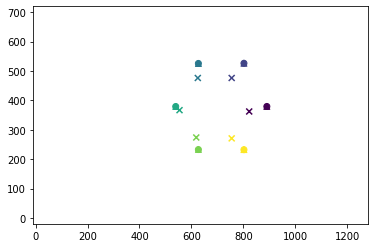

tensor(-308.7825, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.9048, 0.1924, 3.2441, 0.0000, 0.0000, 0.0181]], device='cuda:0',
       grad_fn=<AddBackward0>)


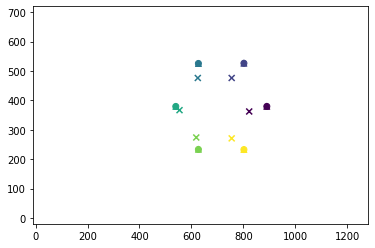

tensor(-307.9762, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.8941, 0.1953, 3.2541, 0.0000, 0.0000, 0.0211]], device='cuda:0',
       grad_fn=<AddBackward0>)


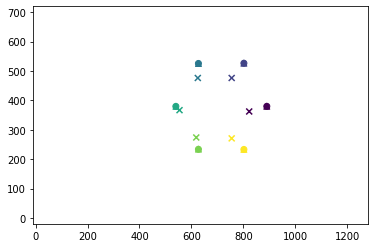

tensor(-307.2002, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.8834, 0.1981, 3.2642, 0.0000, 0.0000, 0.0241]], device='cuda:0',
       grad_fn=<AddBackward0>)


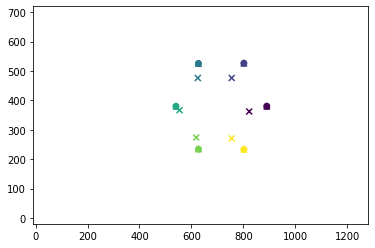

tensor(-306.4413, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.8726, 0.2008, 3.2743, 0.0000, 0.0000, 0.0271]], device='cuda:0',
       grad_fn=<AddBackward0>)


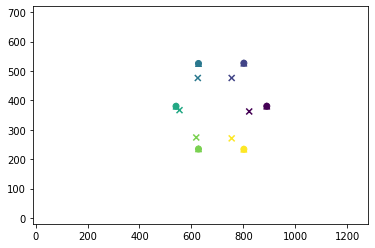

tensor(-305.6941, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.8617, 0.2035, 3.2846, 0.0000, 0.0000, 0.0302]], device='cuda:0',
       grad_fn=<AddBackward0>)


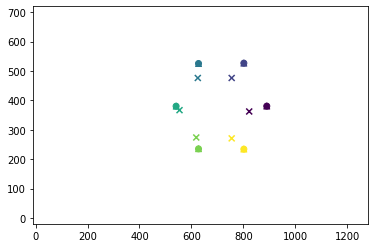

tensor(-304.9566, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.8508, 0.2061, 3.2949, 0.0000, 0.0000, 0.0333]], device='cuda:0',
       grad_fn=<AddBackward0>)


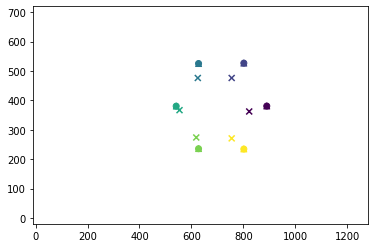

tensor(-304.2288, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.8398, 0.2086, 3.3052, 0.0000, 0.0000, 0.0364]], device='cuda:0',
       grad_fn=<AddBackward0>)


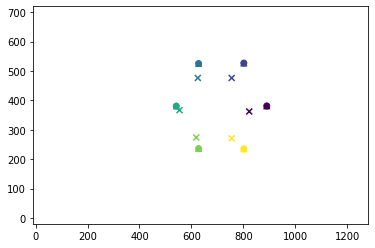

tensor(-303.5101, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.8287, 0.2112, 3.3157, 0.0000, 0.0000, 0.0396]], device='cuda:0',
       grad_fn=<AddBackward0>)


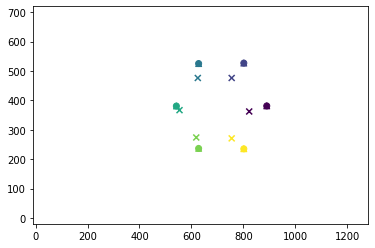

tensor(-302.8007, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.8176, 0.2136, 3.3262, 0.0000, 0.0000, 0.0427]], device='cuda:0',
       grad_fn=<AddBackward0>)


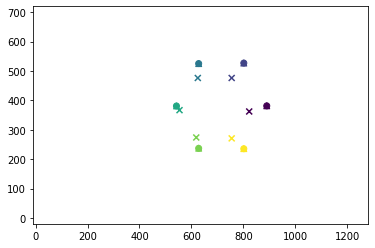

tensor(-302.1013, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.8064, 0.2160, 3.3368, 0.0000, 0.0000, 0.0460]], device='cuda:0',
       grad_fn=<AddBackward0>)


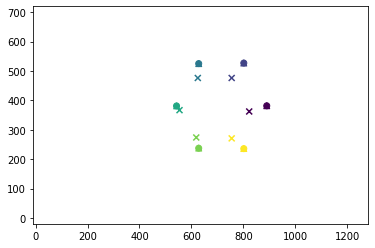

tensor(-301.4114, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.7952, 0.2184, 3.3474, 0.0000, 0.0000, 0.0492]], device='cuda:0',
       grad_fn=<AddBackward0>)


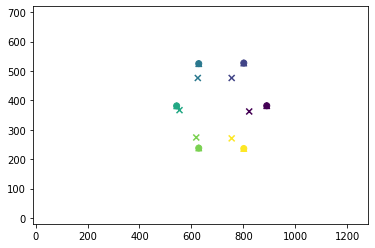

tensor(-300.7319, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.7838, 0.2208, 3.3582, 0.0000, 0.0000, 0.0524]], device='cuda:0',
       grad_fn=<AddBackward0>)


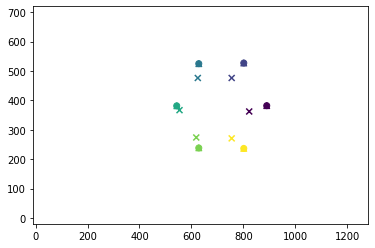

tensor(-300.0629, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.7724, 0.2231, 3.3690, 0.0000, 0.0000, 0.0557]], device='cuda:0',
       grad_fn=<AddBackward0>)


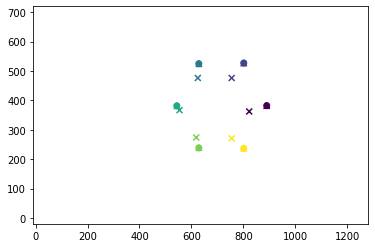

tensor(-299.4330, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.7609, 0.2253, 3.3799, 0.0000, 0.0000, 0.0591]], device='cuda:0',
       grad_fn=<AddBackward0>)


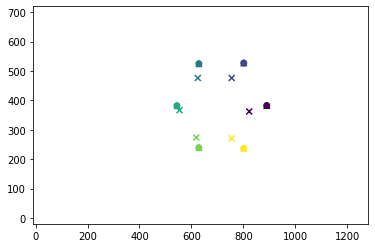

tensor(-298.8798, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.7493, 0.2275, 3.3908, 0.0000, 0.0000, 0.0625]], device='cuda:0',
       grad_fn=<AddBackward0>)


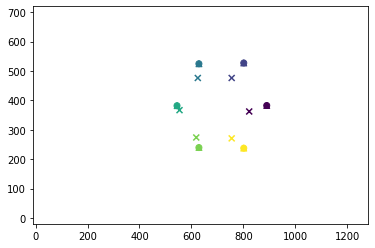

tensor(-298.3691, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.7376, 0.2295, 3.4017, 0.0000, 0.0000, 0.0661]], device='cuda:0',
       grad_fn=<AddBackward0>)


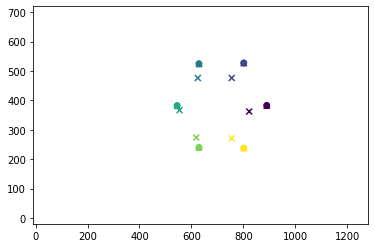

tensor(-297.8876, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.7257, 0.2315, 3.4126, 0.0000, 0.0000, 0.0696]], device='cuda:0',
       grad_fn=<AddBackward0>)


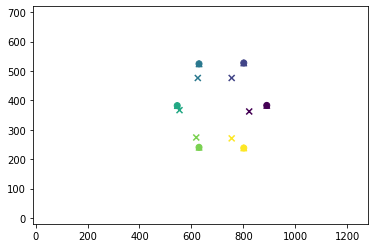

tensor(-297.4308, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.7137, 0.2334, 3.4236, 0.0000, 0.0000, 0.0733]], device='cuda:0',
       grad_fn=<AddBackward0>)


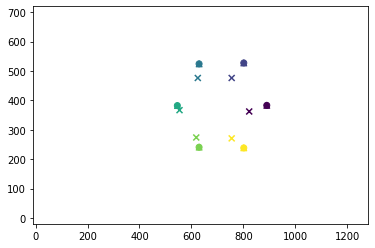

tensor(-296.9966, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.7015, 0.2353, 3.4346, 0.0000, 0.0000, 0.0769]], device='cuda:0',
       grad_fn=<AddBackward0>)


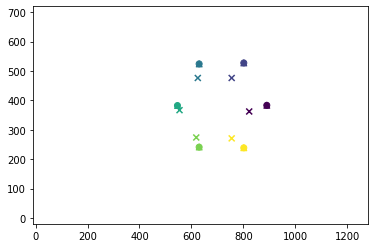

tensor(-296.5849, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.6892, 0.2370, 3.4457, 0.0000, 0.0000, 0.0807]], device='cuda:0',
       grad_fn=<AddBackward0>)


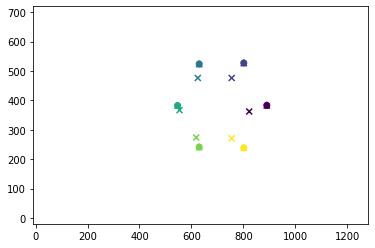

tensor(-296.1956, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.6768, 0.2387, 3.4568, 0.0000, 0.0000, 0.0844]], device='cuda:0',
       grad_fn=<AddBackward0>)


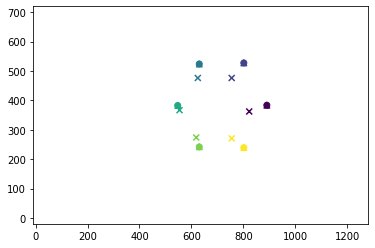

tensor(-295.8527, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.6642, 0.2403, 3.4679, 0.0000, 0.0000, 0.0883]], device='cuda:0',
       grad_fn=<AddBackward0>)


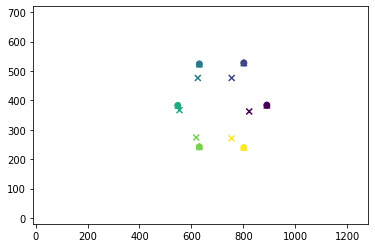

tensor(-295.6132, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.6516, 0.2419, 3.4789, 0.0000, 0.0000, 0.0922]], device='cuda:0',
       grad_fn=<AddBackward0>)


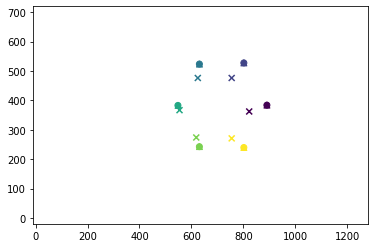

tensor(-295.4341, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.6390, 0.2434, 3.4899, 0.0000, 0.0000, 0.0962]], device='cuda:0',
       grad_fn=<AddBackward0>)


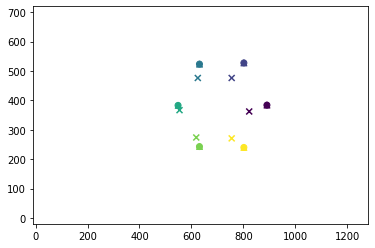

tensor(-295.2979, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.6263, 0.2448, 3.5009, 0.0000, 0.0000, 0.1002]], device='cuda:0',
       grad_fn=<AddBackward0>)


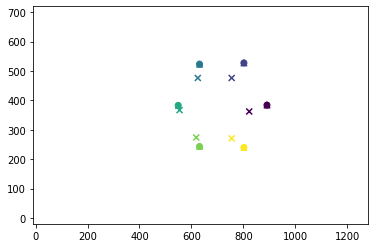

tensor(-295.1972, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.6135, 0.2462, 3.5118, 0.0000, 0.0000, 0.1042]], device='cuda:0',
       grad_fn=<AddBackward0>)


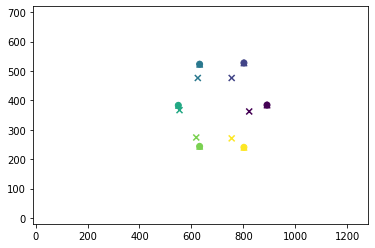

tensor(-295.1298, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.6007, 0.2475, 3.5227, 0.0000, 0.0000, 0.1082]], device='cuda:0',
       grad_fn=<AddBackward0>)


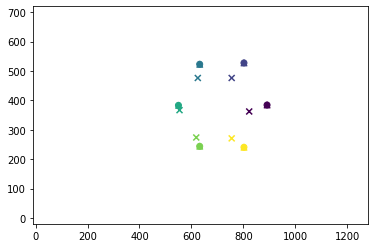

tensor(-295.0942, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.5878, 0.2488, 3.5336, 0.0000, 0.0000, 0.1123]], device='cuda:0',
       grad_fn=<AddBackward0>)


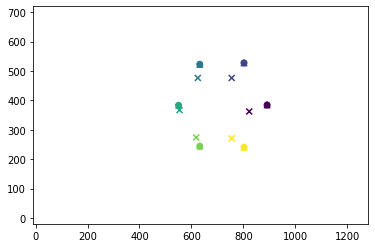

tensor(-294.9673, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.5748, 0.2500, 3.5444, 0.0000, 0.0000, 0.1163]], device='cuda:0',
       grad_fn=<AddBackward0>)


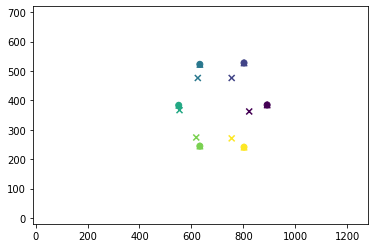

tensor(-294.7937, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.5618, 0.2511, 3.5552, 0.0000, 0.0000, 0.1202]], device='cuda:0',
       grad_fn=<AddBackward0>)


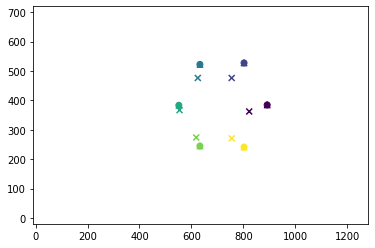

tensor(-294.6100, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.5487, 0.2521, 3.5660, 0.0000, 0.0000, 0.1241]], device='cuda:0',
       grad_fn=<AddBackward0>)


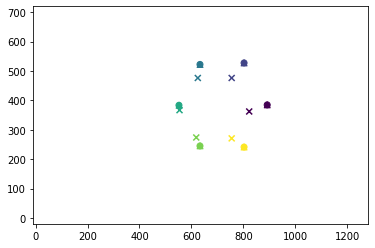

tensor(-294.3210, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.5356, 0.2531, 3.5766, 0.0000, 0.0000, 0.1280]], device='cuda:0',
       grad_fn=<AddBackward0>)


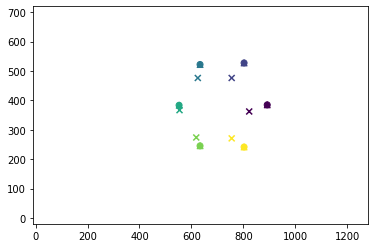

tensor(-293.8511, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.5225, 0.2541, 3.5872, 0.0000, 0.0000, 0.1316]], device='cuda:0',
       grad_fn=<AddBackward0>)


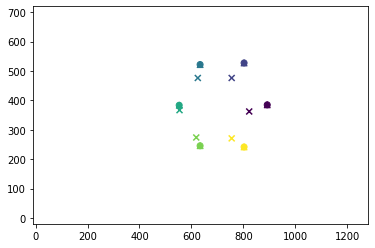

tensor(-293.3102, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.5092, 0.2550, 3.5976, 0.0000, 0.0000, 0.1352]], device='cuda:0',
       grad_fn=<AddBackward0>)


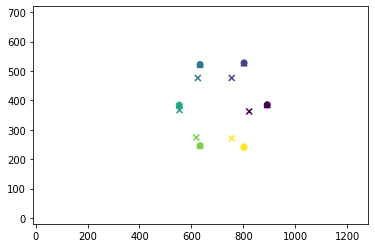

tensor(-292.7476, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.4960, 0.2560, 3.6078, 0.0000, 0.0000, 0.1387]], device='cuda:0',
       grad_fn=<AddBackward0>)


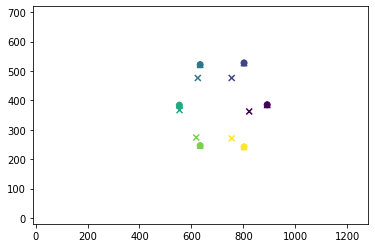

tensor(-292.1852, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.4828, 0.2569, 3.6179, 0.0000, 0.0000, 0.1422]], device='cuda:0',
       grad_fn=<AddBackward0>)


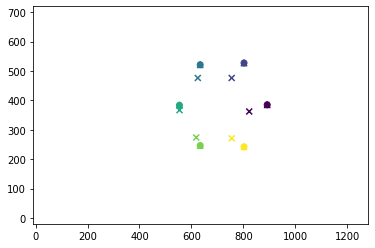

tensor(-291.6328, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.4695, 0.2578, 3.6279, 0.0000, 0.0000, 0.1457]], device='cuda:0',
       grad_fn=<AddBackward0>)


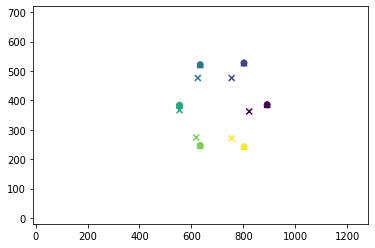

tensor(-291.0945, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.4562, 0.2587, 3.6377, 0.0000, 0.0000, 0.1492]], device='cuda:0',
       grad_fn=<AddBackward0>)


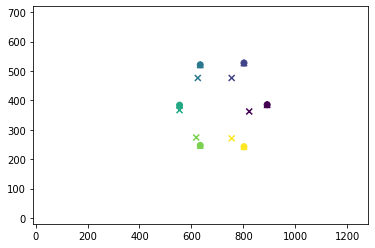

tensor(-290.5717, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.4430, 0.2595, 3.6473, 0.0000, 0.0000, 0.1527]], device='cuda:0',
       grad_fn=<AddBackward0>)


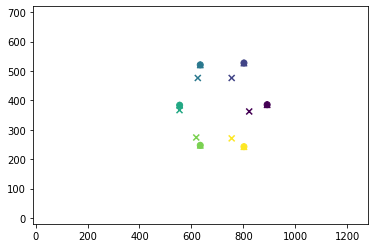

tensor(-290.0742, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.4296, 0.2604, 3.6568, 0.0000, 0.0000, 0.1563]], device='cuda:0',
       grad_fn=<AddBackward0>)


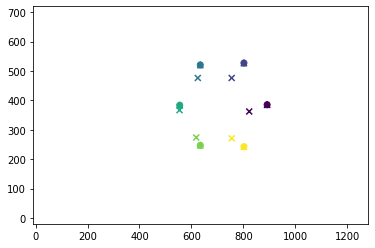

tensor(-289.5972, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.4163, 0.2612, 3.6661, 0.0000, 0.0000, 0.1598]], device='cuda:0',
       grad_fn=<AddBackward0>)


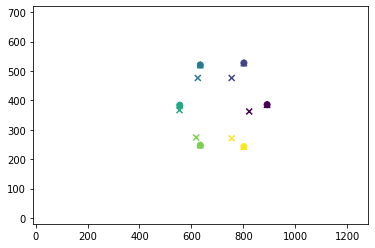

tensor(-289.1385, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.4029, 0.2619, 3.6752, 0.0000, 0.0000, 0.1633]], device='cuda:0',
       grad_fn=<AddBackward0>)


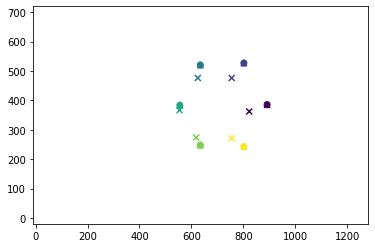

tensor(-288.6960, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.3895, 0.2627, 3.6842, 0.0000, 0.0000, 0.1668]], device='cuda:0',
       grad_fn=<AddBackward0>)


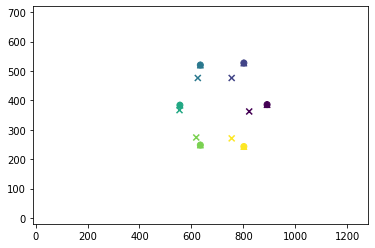

tensor(-288.2695, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.3760, 0.2634, 3.6930, 0.0000, 0.0000, 0.1703]], device='cuda:0',
       grad_fn=<AddBackward0>)


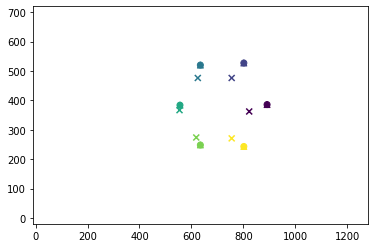

tensor(-287.8582, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.3625, 0.2640, 3.7016, 0.0000, 0.0000, 0.1738]], device='cuda:0',
       grad_fn=<AddBackward0>)


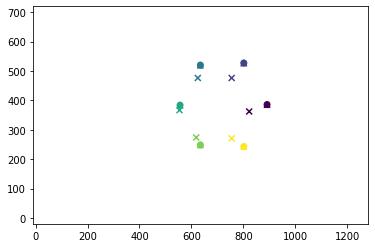

tensor(-287.4619, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.3490, 0.2647, 3.7100, 0.0000, 0.0000, 0.1773]], device='cuda:0',
       grad_fn=<AddBackward0>)


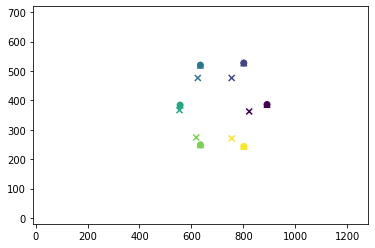

tensor(-287.0792, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.3354, 0.2653, 3.7183, 0.0000, 0.0000, 0.1808]], device='cuda:0',
       grad_fn=<AddBackward0>)


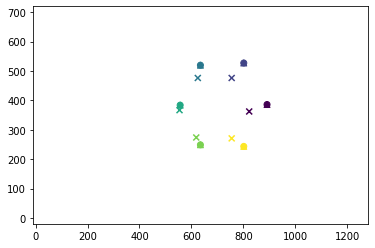

tensor(-286.7105, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.3218, 0.2658, 3.7265, 0.0000, 0.0000, 0.1844]], device='cuda:0',
       grad_fn=<AddBackward0>)


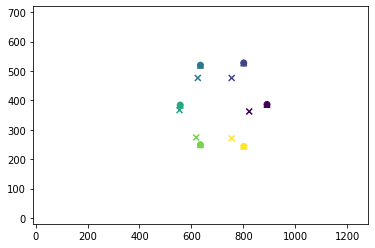

tensor(-286.3555, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.3082, 0.2664, 3.7344, 0.0000, 0.0000, 0.1879]], device='cuda:0',
       grad_fn=<AddBackward0>)


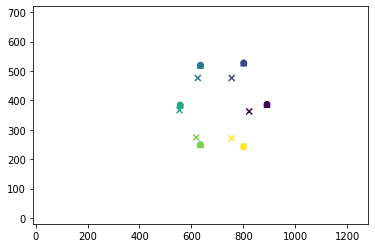

tensor(-286.0129, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.2946, 0.2669, 3.7422, 0.0000, 0.0000, 0.1914]], device='cuda:0',
       grad_fn=<AddBackward0>)


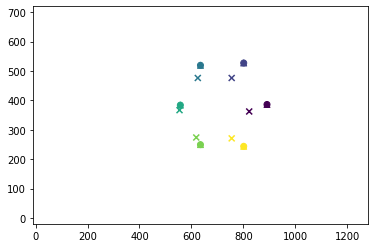

tensor(-285.6833, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.2809, 0.2674, 3.7499, 0.0000, 0.0000, 0.1949]], device='cuda:0',
       grad_fn=<AddBackward0>)


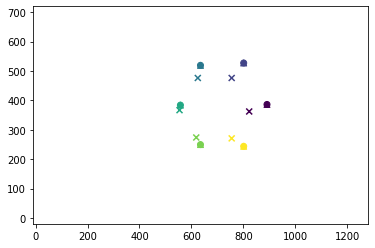

tensor(-285.3661, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.2672, 0.2679, 3.7573, 0.0000, 0.0000, 0.1984]], device='cuda:0',
       grad_fn=<AddBackward0>)


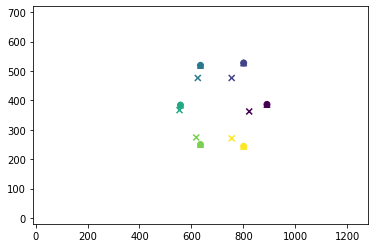

tensor(-285.0603, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.2535, 0.2683, 3.7647, 0.0000, 0.0000, 0.2019]], device='cuda:0',
       grad_fn=<AddBackward0>)


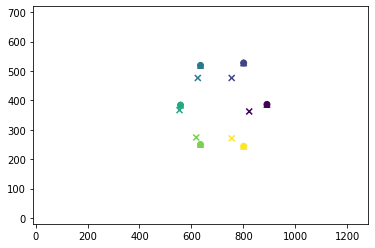

tensor(-284.7661, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.2397, 0.2687, 3.7718, 0.0000, 0.0000, 0.2054]], device='cuda:0',
       grad_fn=<AddBackward0>)


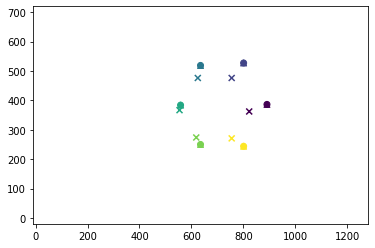

tensor(-284.4833, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.2259, 0.2691, 3.7788, 0.0000, 0.0000, 0.2089]], device='cuda:0',
       grad_fn=<AddBackward0>)


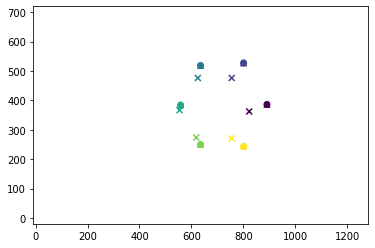

tensor(-284.2115, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.2121, 0.2695, 3.7857, 0.0000, 0.0000, 0.2125]], device='cuda:0',
       grad_fn=<AddBackward0>)


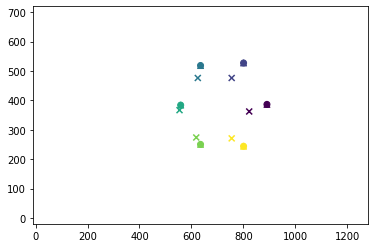

tensor(-283.9498, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.1983, 0.2698, 3.7924, 0.0000, 0.0000, 0.2160]], device='cuda:0',
       grad_fn=<AddBackward0>)


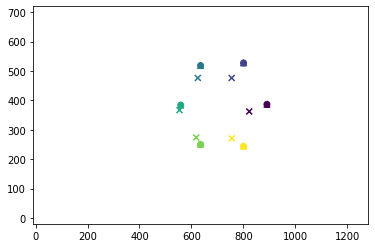

tensor(-283.6989, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.1844, 0.2702, 3.7989, 0.0000, 0.0000, 0.2195]], device='cuda:0',
       grad_fn=<AddBackward0>)


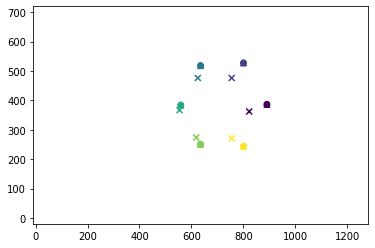

tensor(-283.4579, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.1706, 0.2705, 3.8053, 0.0000, 0.0000, 0.2230]], device='cuda:0',
       grad_fn=<AddBackward0>)


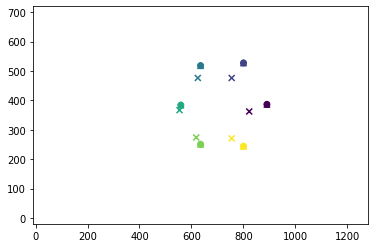

tensor(-283.2262, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.1567, 0.2707, 3.8116, 0.0000, 0.0000, 0.2265]], device='cuda:0',
       grad_fn=<AddBackward0>)


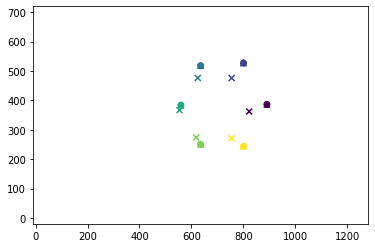

tensor(-283.0046, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.1427, 0.2710, 3.8177, 0.0000, 0.0000, 0.2300]], device='cuda:0',
       grad_fn=<AddBackward0>)


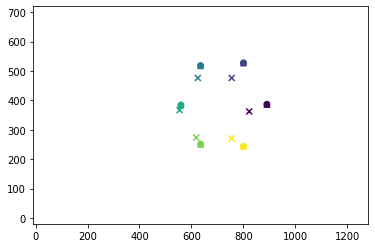

tensor(-282.8756, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.1288, 0.2713, 3.8237, 0.0000, 0.0000, 0.2335]], device='cuda:0',
       grad_fn=<AddBackward0>)


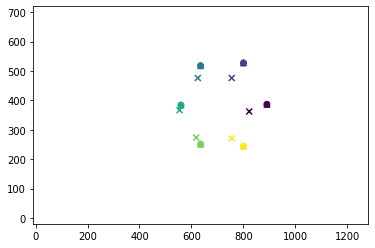

tensor(-282.8049, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.1148, 0.2716, 3.8297, 0.0000, 0.0000, 0.2371]], device='cuda:0',
       grad_fn=<AddBackward0>)


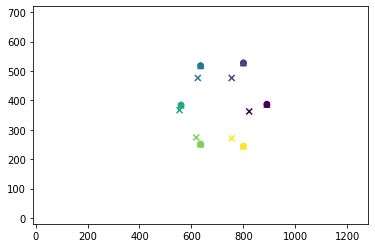

tensor(-282.7635, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.1008, 0.2720, 3.8357, 0.0000, 0.0000, 0.2408]], device='cuda:0',
       grad_fn=<AddBackward0>)


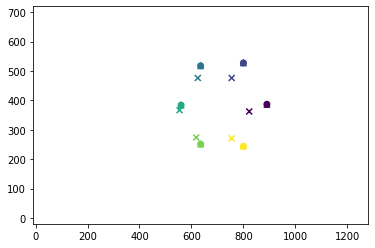

tensor(-282.7388, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.0868, 0.2724, 3.8417, 0.0000, 0.0000, 0.2444]], device='cuda:0',
       grad_fn=<AddBackward0>)


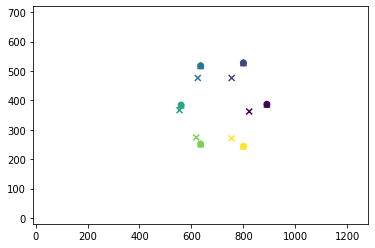

tensor(-282.7242, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.0727, 0.2728, 3.8476, 0.0000, 0.0000, 0.2480]], device='cuda:0',
       grad_fn=<AddBackward0>)


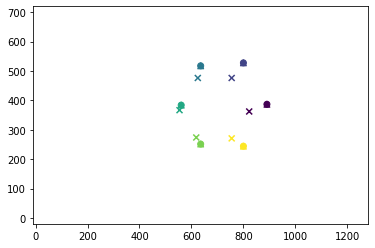

tensor(-282.7173, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.0586, 0.2732, 3.8536, 0.0000, 0.0000, 0.2517]], device='cuda:0',
       grad_fn=<AddBackward0>)


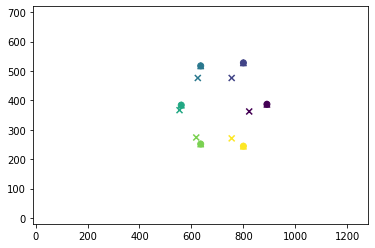

tensor(-282.7171, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.0445, 0.2737, 3.8595, 0.0000, 0.0000, 0.2554]], device='cuda:0',
       grad_fn=<AddBackward0>)


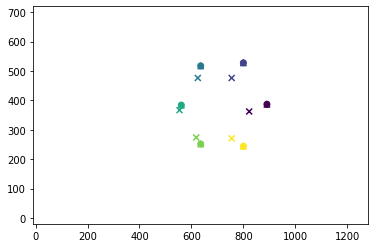

tensor(-282.7228, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.0303, 0.2743, 3.8653, 0.0000, 0.0000, 0.2590]], device='cuda:0',
       grad_fn=<AddBackward0>)


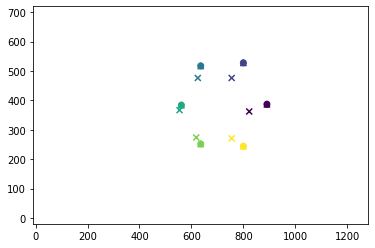

tensor(-282.7337, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[0.0161, 0.2748, 3.8712, 0.0000, 0.0000, 0.2627]], device='cuda:0',
       grad_fn=<AddBackward0>)


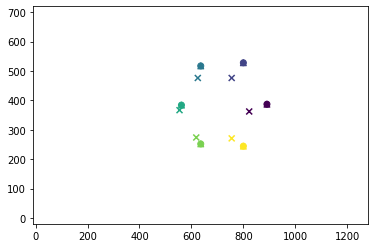

tensor(-282.8408, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[1.8466e-03, 2.7544e-01, 3.8770e+00, 0.0000e+00, 0.0000e+00, 2.6640e-01]],
       device='cuda:0', grad_fn=<AddBackward0>)


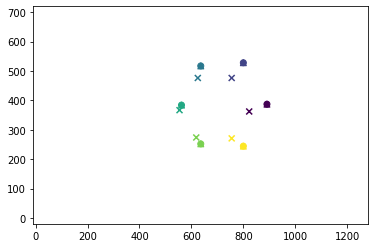

tensor(-283.0428, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.0124,  0.2761,  3.8828,  0.0000,  0.0000,  0.2702]],
       device='cuda:0', grad_fn=<AddBackward0>)


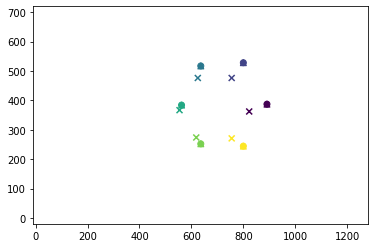

tensor(-283.0741, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.0266,  0.2769,  3.8885,  0.0000,  0.0000,  0.2738]],
       device='cuda:0', grad_fn=<AddBackward0>)


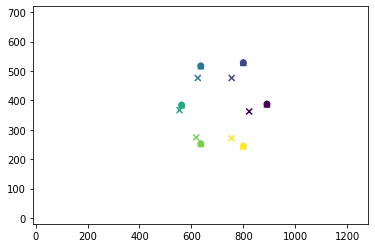

tensor(-282.9379, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.0408,  0.2777,  3.8942,  0.0000,  0.0000,  0.2773]],
       device='cuda:0', grad_fn=<AddBackward0>)


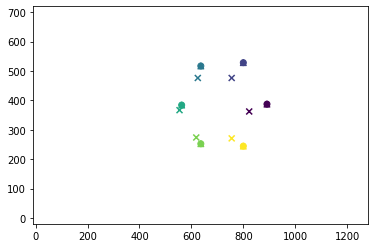

tensor(-282.7600, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.0549,  0.2785,  3.8998,  0.0000,  0.0000,  0.2808]],
       device='cuda:0', grad_fn=<AddBackward0>)


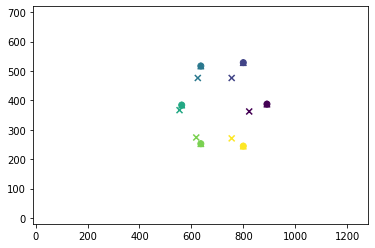

tensor(-282.5277, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.0690,  0.2794,  3.9054,  0.0000,  0.0000,  0.2842]],
       device='cuda:0', grad_fn=<AddBackward0>)


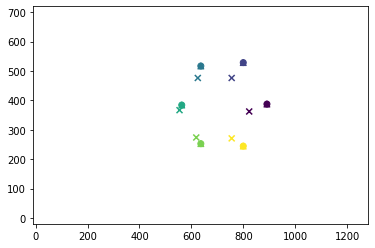

tensor(-282.2213, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.0830,  0.2802,  3.9110,  0.0000,  0.0000,  0.2875]],
       device='cuda:0', grad_fn=<AddBackward0>)


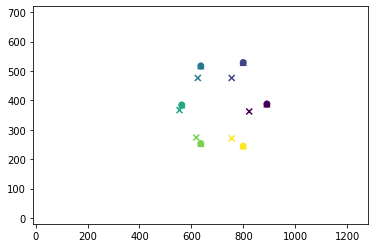

tensor(-281.5513, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.0970,  0.2811,  3.9165,  0.0000,  0.0000,  0.2906]],
       device='cuda:0', grad_fn=<AddBackward0>)


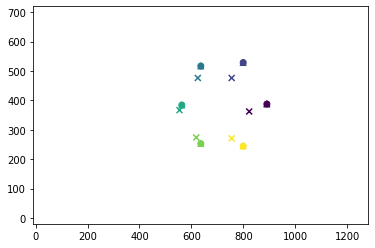

tensor(-280.6719, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.1109,  0.2819,  3.9220,  0.0000,  0.0000,  0.2935]],
       device='cuda:0', grad_fn=<AddBackward0>)


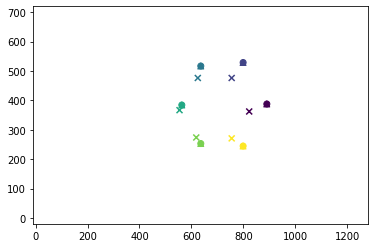

tensor(-279.6740, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.1248,  0.2827,  3.9275,  0.0000,  0.0000,  0.2963]],
       device='cuda:0', grad_fn=<AddBackward0>)


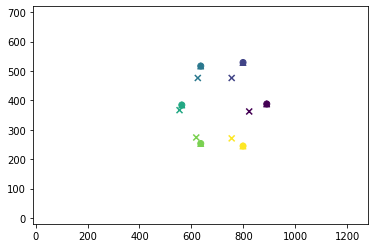

tensor(-278.6122, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.1385,  0.2835,  3.9328,  0.0000,  0.0000,  0.2990]],
       device='cuda:0', grad_fn=<AddBackward0>)


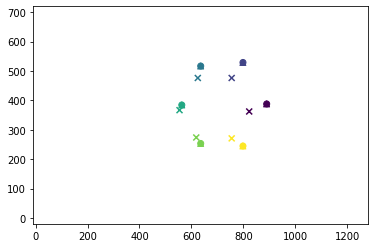

tensor(-277.5180, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.1522,  0.2842,  3.9381,  0.0000,  0.0000,  0.3017]],
       device='cuda:0', grad_fn=<AddBackward0>)


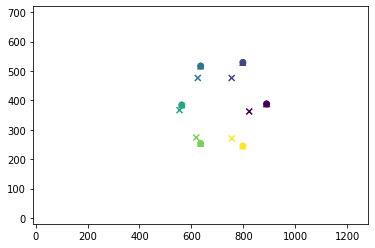

tensor(-276.4095, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.1658,  0.2849,  3.9434,  0.0000,  0.0000,  0.3044]],
       device='cuda:0', grad_fn=<AddBackward0>)


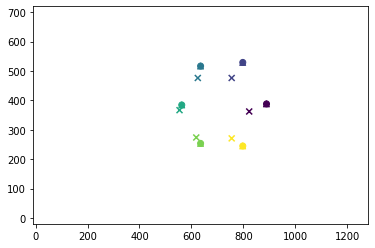

tensor(-275.2983, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.1793,  0.2856,  3.9486,  0.0000,  0.0000,  0.3070]],
       device='cuda:0', grad_fn=<AddBackward0>)


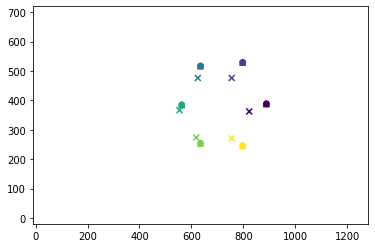

tensor(-274.1188, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.1928,  0.2863,  3.9536,  0.0000,  0.0000,  0.3095]],
       device='cuda:0', grad_fn=<AddBackward0>)


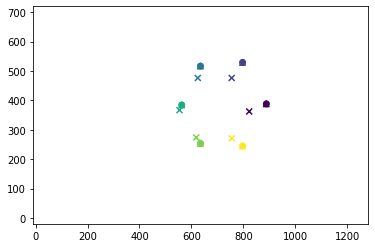

tensor(-272.7880, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.2061,  0.2869,  3.9586,  0.0000,  0.0000,  0.3119]],
       device='cuda:0', grad_fn=<AddBackward0>)


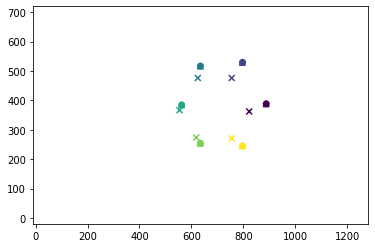

tensor(-271.3160, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.2193,  0.2875,  3.9634,  0.0000,  0.0000,  0.3142]],
       device='cuda:0', grad_fn=<AddBackward0>)


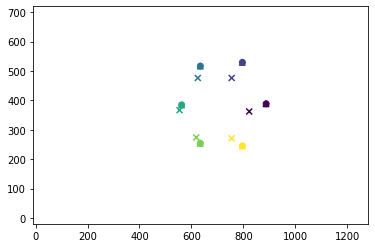

tensor(-269.7615, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.2324,  0.2880,  3.9680,  0.0000,  0.0000,  0.3163]],
       device='cuda:0', grad_fn=<AddBackward0>)


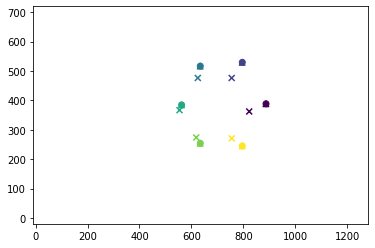

tensor(-268.0851, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.2453,  0.2884,  3.9726,  0.0000,  0.0000,  0.3183]],
       device='cuda:0', grad_fn=<AddBackward0>)


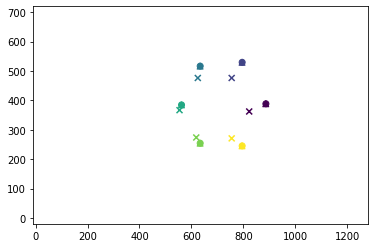

tensor(-266.3442, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.2581,  0.2888,  3.9770,  0.0000,  0.0000,  0.3203]],
       device='cuda:0', grad_fn=<AddBackward0>)


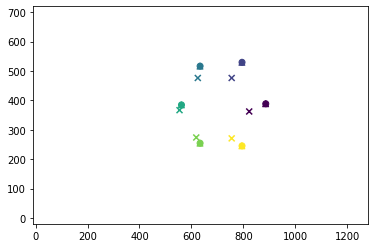

tensor(-264.5761, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.2708,  0.2891,  3.9813,  0.0000,  0.0000,  0.3221]],
       device='cuda:0', grad_fn=<AddBackward0>)


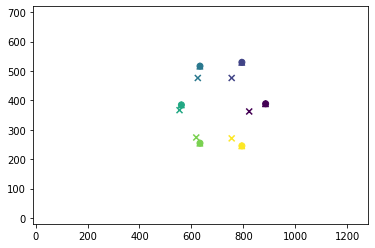

tensor(-262.8046, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.2833,  0.2893,  3.9855,  0.0000,  0.0000,  0.3239]],
       device='cuda:0', grad_fn=<AddBackward0>)


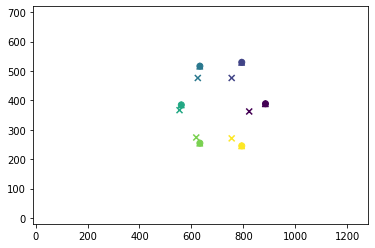

tensor(-261.0439, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.2956,  0.2894,  3.9896,  0.0000,  0.0000,  0.3257]],
       device='cuda:0', grad_fn=<AddBackward0>)


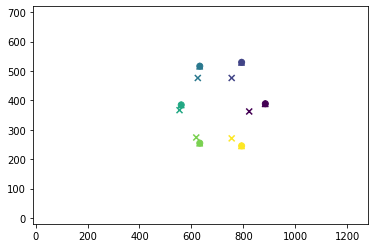

tensor(-259.3040, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.3078,  0.2895,  3.9936,  0.0000,  0.0000,  0.3274]],
       device='cuda:0', grad_fn=<AddBackward0>)


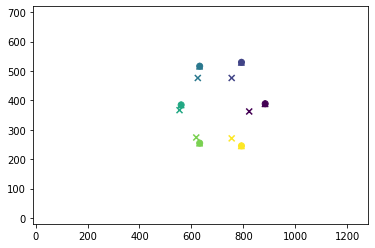

tensor(-257.5905, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.3199,  0.2895,  3.9975,  0.0000,  0.0000,  0.3291]],
       device='cuda:0', grad_fn=<AddBackward0>)


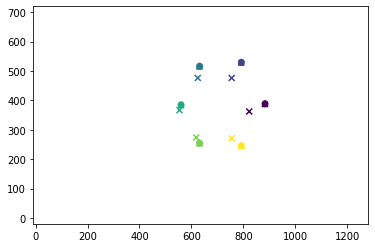

tensor(-255.9070, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.3318,  0.2895,  4.0013,  0.0000,  0.0000,  0.3308]],
       device='cuda:0', grad_fn=<AddBackward0>)


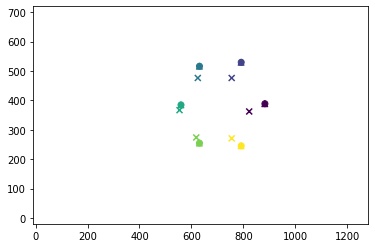

tensor(-254.2552, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.3436,  0.2894,  4.0050,  0.0000,  0.0000,  0.3324]],
       device='cuda:0', grad_fn=<AddBackward0>)


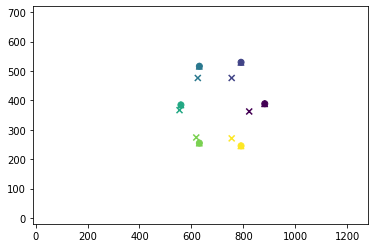

tensor(-252.6367, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.3552,  0.2893,  4.0086,  0.0000,  0.0000,  0.3341]],
       device='cuda:0', grad_fn=<AddBackward0>)


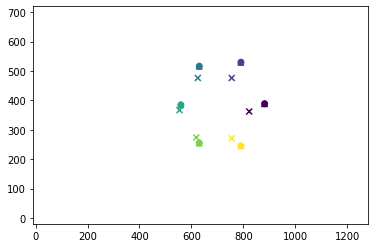

tensor(-251.0522, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.3667,  0.2890,  4.0121,  0.0000,  0.0000,  0.3357]],
       device='cuda:0', grad_fn=<AddBackward0>)


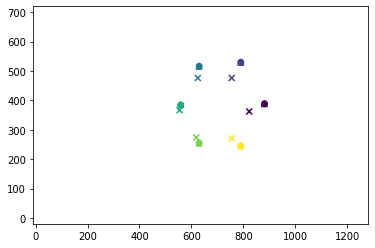

tensor(-249.5013, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.3780,  0.2888,  4.0155,  0.0000,  0.0000,  0.3373]],
       device='cuda:0', grad_fn=<AddBackward0>)


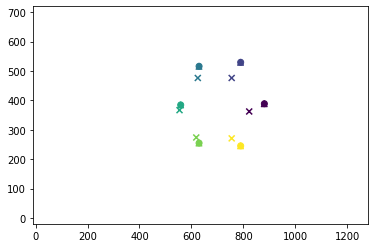

tensor(-247.9846, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.3893,  0.2885,  4.0187,  0.0000,  0.0000,  0.3388]],
       device='cuda:0', grad_fn=<AddBackward0>)


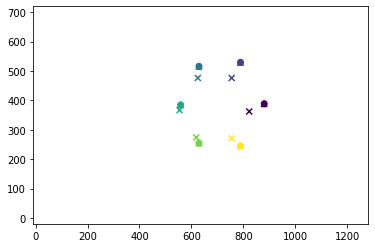

tensor(-246.5015, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.4003,  0.2881,  4.0220,  0.0000,  0.0000,  0.3404]],
       device='cuda:0', grad_fn=<AddBackward0>)


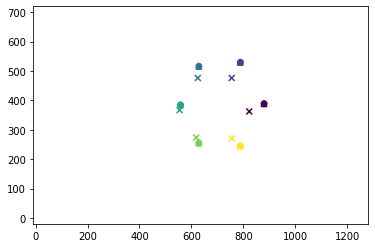

tensor(-245.1721, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.4113,  0.2878,  4.0251,  0.0000,  0.0000,  0.3420]],
       device='cuda:0', grad_fn=<AddBackward0>)


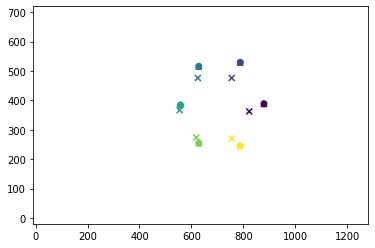

tensor(-243.9755, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.4222,  0.2874,  4.0282,  0.0000,  0.0000,  0.3437]],
       device='cuda:0', grad_fn=<AddBackward0>)


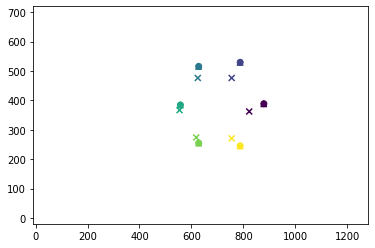

tensor(-242.8684, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.4329,  0.2871,  4.0313,  0.0000,  0.0000,  0.3455]],
       device='cuda:0', grad_fn=<AddBackward0>)


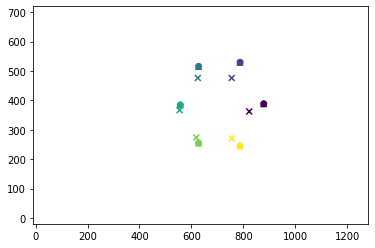

tensor(-241.8265, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.4436,  0.2869,  4.0343,  0.0000,  0.0000,  0.3473]],
       device='cuda:0', grad_fn=<AddBackward0>)


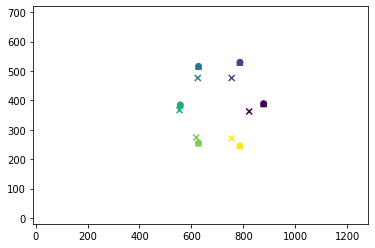

tensor(-240.8314, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.4542,  0.2866,  4.0373,  0.0000,  0.0000,  0.3491]],
       device='cuda:0', grad_fn=<AddBackward0>)


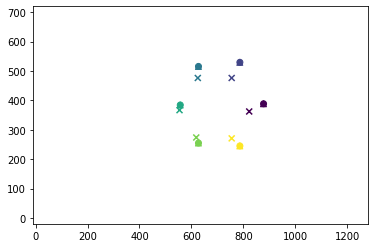

tensor(-239.8703, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.4648,  0.2863,  4.0403,  0.0000,  0.0000,  0.3509]],
       device='cuda:0', grad_fn=<AddBackward0>)


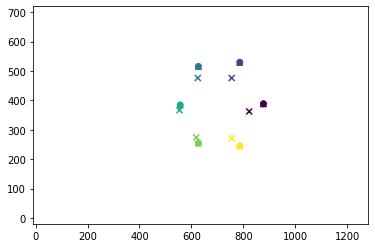

tensor(-238.9358, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.4753,  0.2861,  4.0433,  0.0000,  0.0000,  0.3527]],
       device='cuda:0', grad_fn=<AddBackward0>)


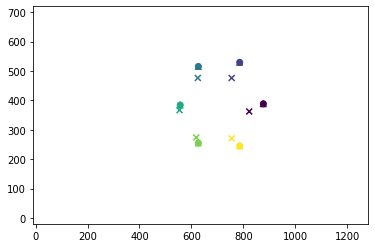

tensor(-238.1080, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.4857,  0.2859,  4.0462,  0.0000,  0.0000,  0.3546]],
       device='cuda:0', grad_fn=<AddBackward0>)


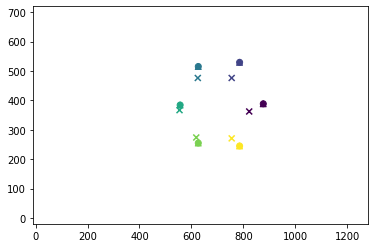

tensor(-237.3900, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.4960,  0.2857,  4.0490,  0.0000,  0.0000,  0.3565]],
       device='cuda:0', grad_fn=<AddBackward0>)


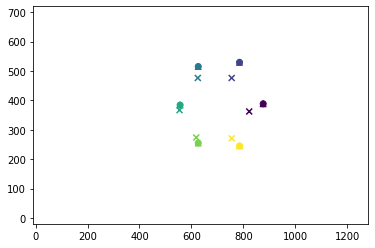

tensor(-236.7400, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.5063,  0.2855,  4.0519,  0.0000,  0.0000,  0.3585]],
       device='cuda:0', grad_fn=<AddBackward0>)


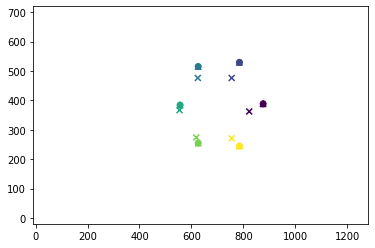

tensor(-236.1341, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.5165,  0.2854,  4.0546,  0.0000,  0.0000,  0.3605]],
       device='cuda:0', grad_fn=<AddBackward0>)


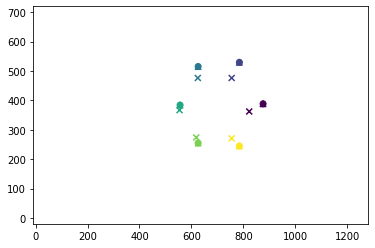

tensor(-235.5576, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.5266,  0.2853,  4.0574,  0.0000,  0.0000,  0.3625]],
       device='cuda:0', grad_fn=<AddBackward0>)


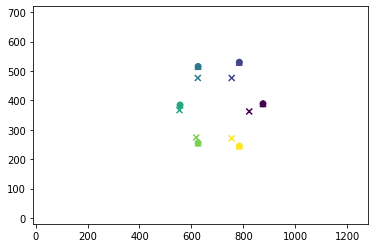

tensor(-235.0023, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.5366,  0.2852,  4.0601,  0.0000,  0.0000,  0.3645]],
       device='cuda:0', grad_fn=<AddBackward0>)


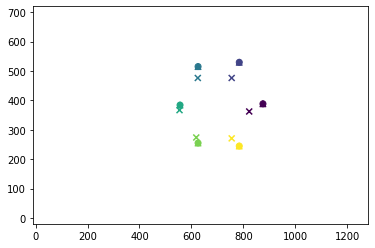

tensor(-234.4636, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.5465,  0.2851,  4.0628,  0.0000,  0.0000,  0.3665]],
       device='cuda:0', grad_fn=<AddBackward0>)


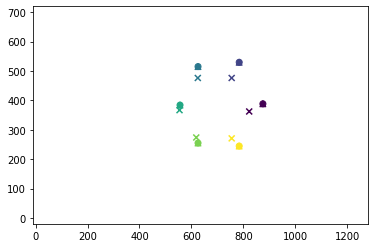

tensor(-233.9378, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.5564,  0.2851,  4.0654,  0.0000,  0.0000,  0.3685]],
       device='cuda:0', grad_fn=<AddBackward0>)


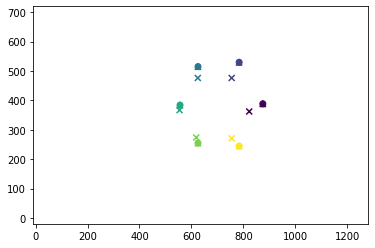

tensor(-233.4236, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.5663,  0.2850,  4.0681,  0.0000,  0.0000,  0.3704]],
       device='cuda:0', grad_fn=<AddBackward0>)


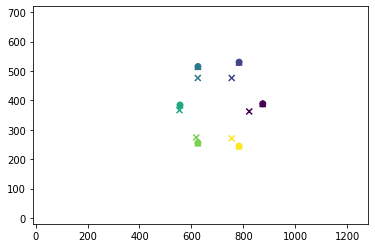

tensor(-232.9196, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.5760,  0.2850,  4.0706,  0.0000,  0.0000,  0.3724]],
       device='cuda:0', grad_fn=<AddBackward0>)


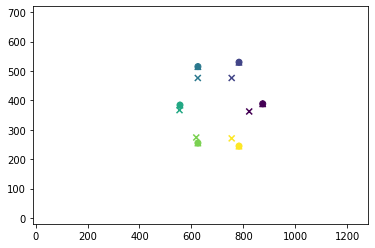

tensor(-232.4258, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.5857,  0.2850,  4.0732,  0.0000,  0.0000,  0.3743]],
       device='cuda:0', grad_fn=<AddBackward0>)


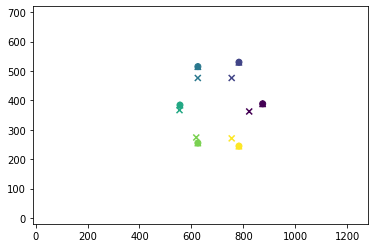

tensor(-231.9412, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.5953,  0.2851,  4.0757,  0.0000,  0.0000,  0.3762]],
       device='cuda:0', grad_fn=<AddBackward0>)


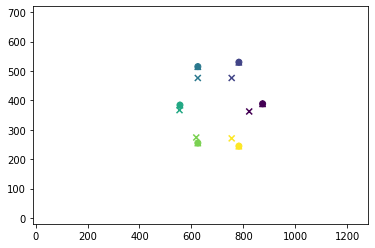

tensor(-231.4656, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.6049,  0.2851,  4.0782,  0.0000,  0.0000,  0.3782]],
       device='cuda:0', grad_fn=<AddBackward0>)


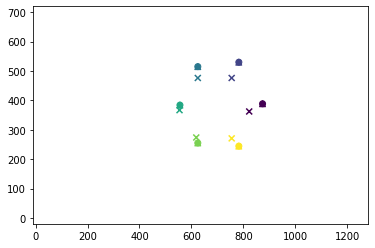

tensor(-230.9990, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.6144,  0.2852,  4.0806,  0.0000,  0.0000,  0.3800]],
       device='cuda:0', grad_fn=<AddBackward0>)


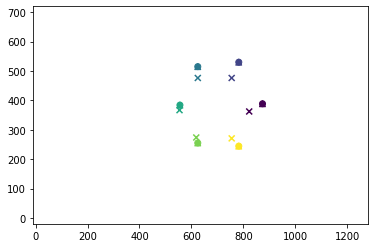

tensor(-230.5415, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.6238,  0.2853,  4.0830,  0.0000,  0.0000,  0.3819]],
       device='cuda:0', grad_fn=<AddBackward0>)


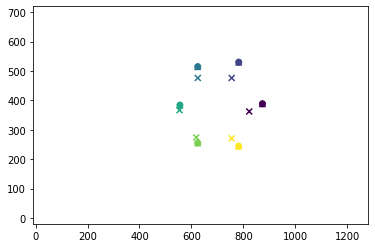

tensor(-230.0926, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.6332,  0.2854,  4.0854,  0.0000,  0.0000,  0.3838]],
       device='cuda:0', grad_fn=<AddBackward0>)


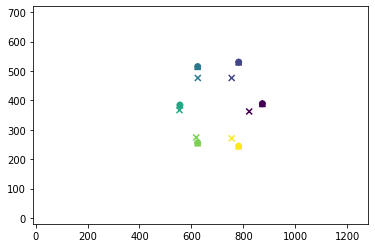

tensor(-229.6524, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.6425,  0.2855,  4.0877,  0.0000,  0.0000,  0.3856]],
       device='cuda:0', grad_fn=<AddBackward0>)


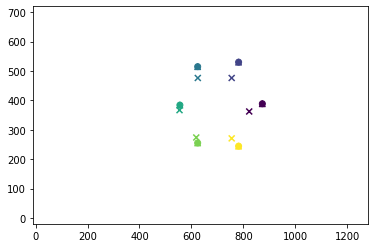

tensor(-229.2210, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.6517,  0.2857,  4.0901,  0.0000,  0.0000,  0.3875]],
       device='cuda:0', grad_fn=<AddBackward0>)


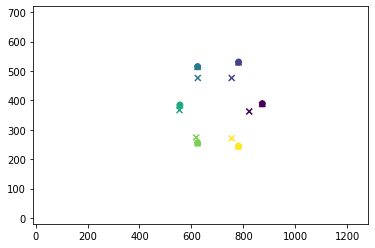

tensor(-228.7981, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.6608,  0.2858,  4.0923,  0.0000,  0.0000,  0.3893]],
       device='cuda:0', grad_fn=<AddBackward0>)


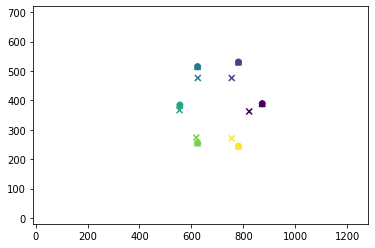

tensor(-228.3838, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.6699,  0.2860,  4.0946,  0.0000,  0.0000,  0.3911]],
       device='cuda:0', grad_fn=<AddBackward0>)


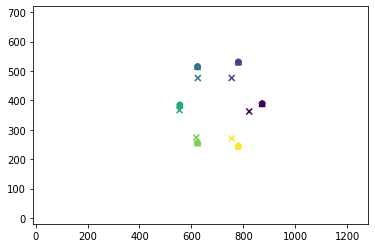

tensor(-227.9654, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.6789,  0.2862,  4.0968,  0.0000,  0.0000,  0.3929]],
       device='cuda:0', grad_fn=<AddBackward0>)


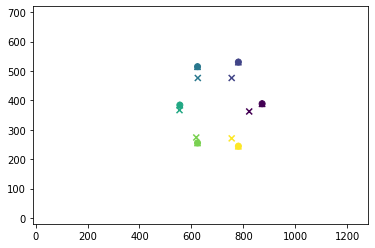

tensor(-227.5489, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.6879,  0.2864,  4.0989,  0.0000,  0.0000,  0.3946]],
       device='cuda:0', grad_fn=<AddBackward0>)


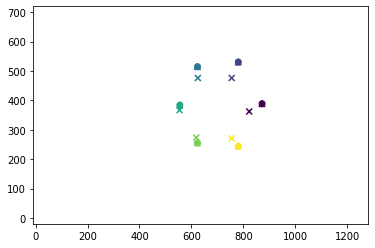

tensor(-227.1374, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.6967,  0.2866,  4.1011,  0.0000,  0.0000,  0.3963]],
       device='cuda:0', grad_fn=<AddBackward0>)


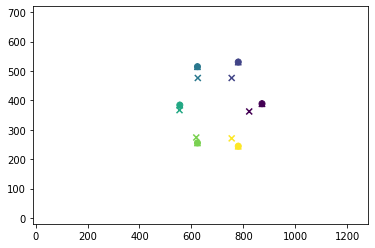

tensor(-226.7328, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.7054,  0.2868,  4.1032,  0.0000,  0.0000,  0.3980]],
       device='cuda:0', grad_fn=<AddBackward0>)


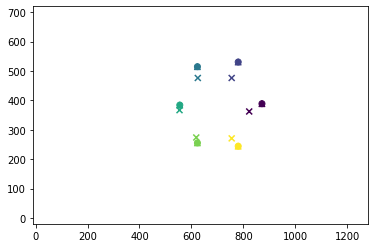

tensor(-226.3308, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.7141,  0.2870,  4.1052,  0.0000,  0.0000,  0.3997]],
       device='cuda:0', grad_fn=<AddBackward0>)


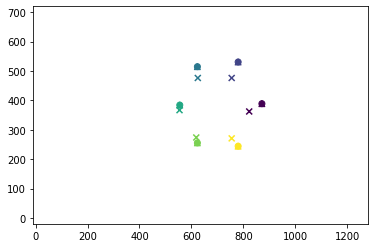

tensor(-225.8363, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.7227,  0.2872,  4.1072,  0.0000,  0.0000,  0.4012]],
       device='cuda:0', grad_fn=<AddBackward0>)


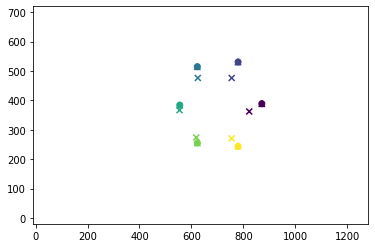

tensor(-225.2928, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.7313,  0.2875,  4.1092,  0.0000,  0.0000,  0.4027]],
       device='cuda:0', grad_fn=<AddBackward0>)


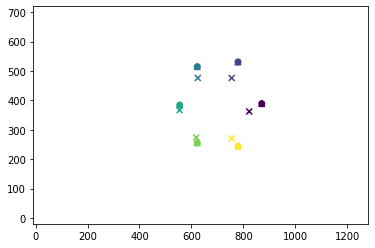

tensor(-224.7266, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.7398,  0.2877,  4.1111,  0.0000,  0.0000,  0.4041]],
       device='cuda:0', grad_fn=<AddBackward0>)


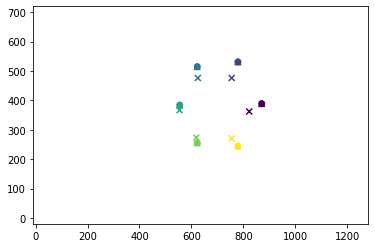

tensor(-224.1534, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.7482,  0.2880,  4.1130,  0.0000,  0.0000,  0.4055]],
       device='cuda:0', grad_fn=<AddBackward0>)


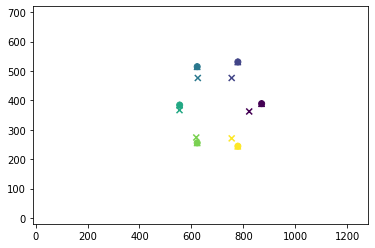

tensor(-223.5839, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.7566,  0.2883,  4.1148,  0.0000,  0.0000,  0.4068]],
       device='cuda:0', grad_fn=<AddBackward0>)


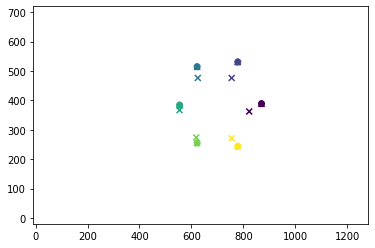

tensor(-223.0229, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.7649,  0.2885,  4.1165,  0.0000,  0.0000,  0.4081]],
       device='cuda:0', grad_fn=<AddBackward0>)


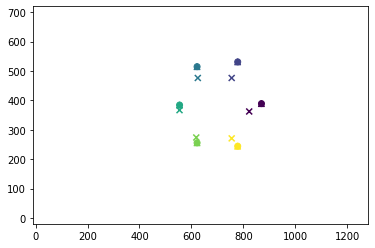

tensor(-222.4746, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.7731,  0.2888,  4.1182,  0.0000,  0.0000,  0.4094]],
       device='cuda:0', grad_fn=<AddBackward0>)


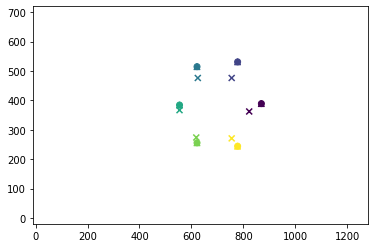

tensor(-221.9407, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.7813,  0.2891,  4.1199,  0.0000,  0.0000,  0.4107]],
       device='cuda:0', grad_fn=<AddBackward0>)


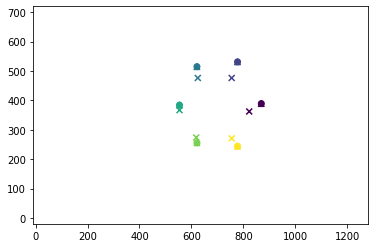

tensor(-221.4225, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.7894,  0.2894,  4.1215,  0.0000,  0.0000,  0.4120]],
       device='cuda:0', grad_fn=<AddBackward0>)


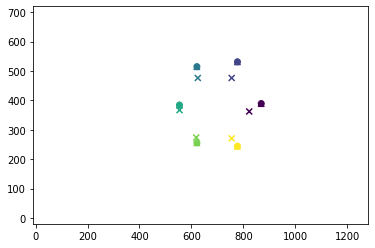

tensor(-220.9001, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.7974,  0.2897,  4.1230,  0.0000,  0.0000,  0.4132]],
       device='cuda:0', grad_fn=<AddBackward0>)


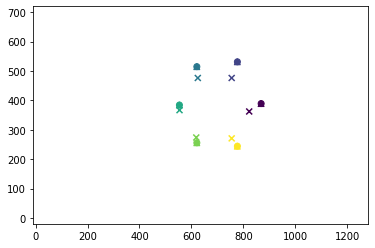

tensor(-220.3697, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.8053,  0.2900,  4.1246,  0.0000,  0.0000,  0.4144]],
       device='cuda:0', grad_fn=<AddBackward0>)


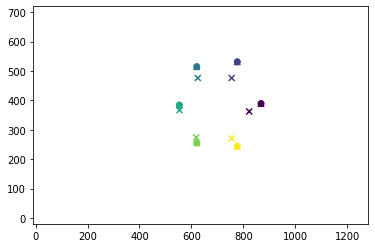

tensor(-219.8414, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.8132,  0.2904,  4.1261,  0.0000,  0.0000,  0.4155]],
       device='cuda:0', grad_fn=<AddBackward0>)


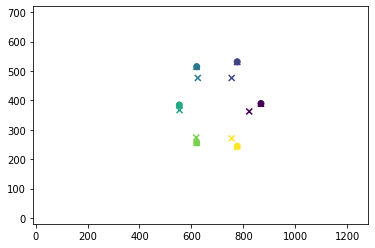

tensor(-219.3676, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.8210,  0.2907,  4.1276,  0.0000,  0.0000,  0.4167]],
       device='cuda:0', grad_fn=<AddBackward0>)


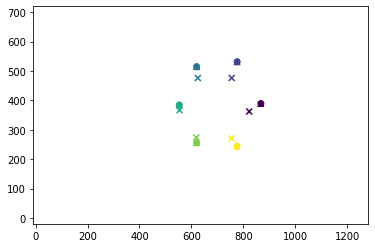

tensor(-218.9446, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.8287,  0.2910,  4.1290,  0.0000,  0.0000,  0.4179]],
       device='cuda:0', grad_fn=<AddBackward0>)


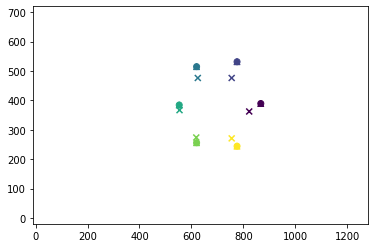

tensor(-218.5580, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.8363,  0.2914,  4.1304,  0.0000,  0.0000,  0.4191]],
       device='cuda:0', grad_fn=<AddBackward0>)


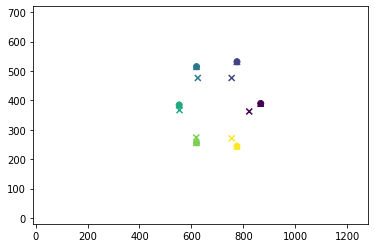

tensor(-218.1984, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.8438,  0.2918,  4.1317,  0.0000,  0.0000,  0.4203]],
       device='cuda:0', grad_fn=<AddBackward0>)


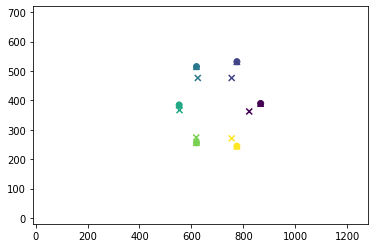

tensor(-217.8602, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.8512,  0.2921,  4.1330,  0.0000,  0.0000,  0.4215]],
       device='cuda:0', grad_fn=<AddBackward0>)


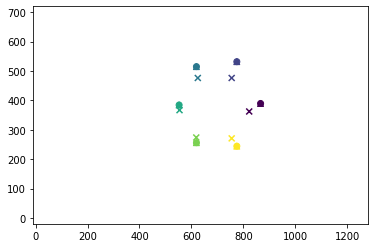

tensor(-217.5401, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.8585,  0.2925,  4.1342,  0.0000,  0.0000,  0.4227]],
       device='cuda:0', grad_fn=<AddBackward0>)


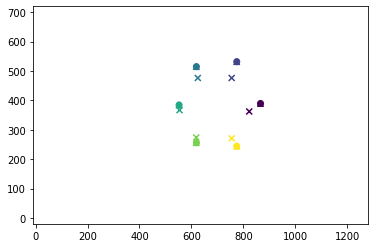

tensor(-217.2358, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.8658,  0.2929,  4.1354,  0.0000,  0.0000,  0.4239]],
       device='cuda:0', grad_fn=<AddBackward0>)


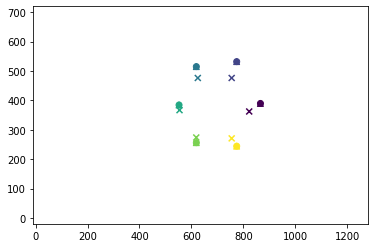

tensor(-216.9458, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.8730,  0.2933,  4.1365,  0.0000,  0.0000,  0.4251]],
       device='cuda:0', grad_fn=<AddBackward0>)


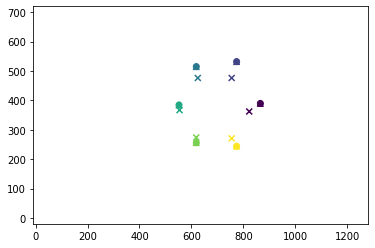

tensor(-216.6695, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.8801,  0.2937,  4.1377,  0.0000,  0.0000,  0.4262]],
       device='cuda:0', grad_fn=<AddBackward0>)


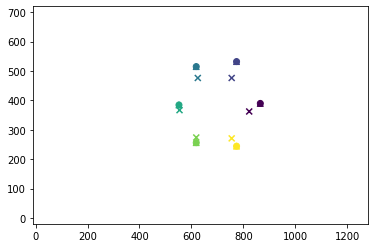

tensor(-216.4057, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.8871,  0.2941,  4.1387,  0.0000,  0.0000,  0.4274]],
       device='cuda:0', grad_fn=<AddBackward0>)


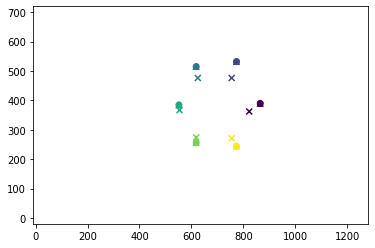

tensor(-216.1546, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.8940,  0.2945,  4.1398,  0.0000,  0.0000,  0.4285]],
       device='cuda:0', grad_fn=<AddBackward0>)


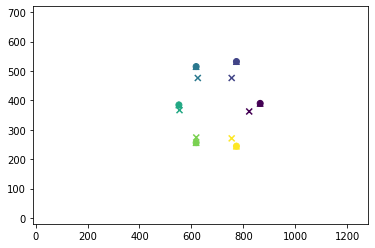

tensor(-215.9158, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.9009,  0.2950,  4.1407,  0.0000,  0.0000,  0.4296]],
       device='cuda:0', grad_fn=<AddBackward0>)


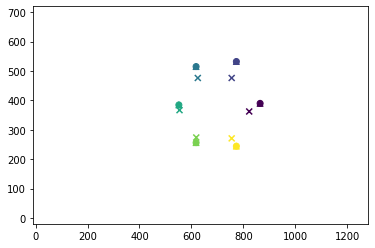

tensor(-215.6888, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.9077,  0.2954,  4.1417,  0.0000,  0.0000,  0.4307]],
       device='cuda:0', grad_fn=<AddBackward0>)


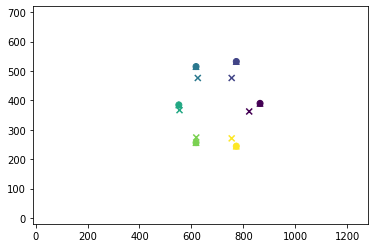

tensor(-215.4738, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.9144,  0.2959,  4.1426,  0.0000,  0.0000,  0.4318]],
       device='cuda:0', grad_fn=<AddBackward0>)


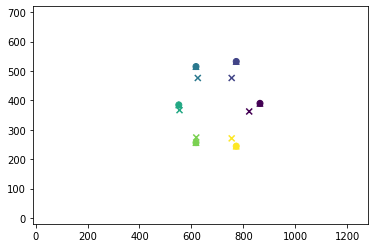

tensor(-215.2702, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.9210,  0.2963,  4.1435,  0.0000,  0.0000,  0.4328]],
       device='cuda:0', grad_fn=<AddBackward0>)


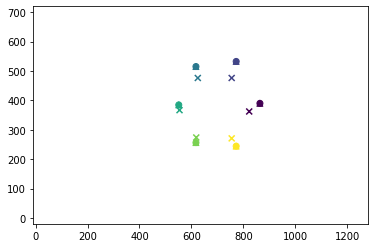

tensor(-215.0789, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.9276,  0.2968,  4.1443,  0.0000,  0.0000,  0.4339]],
       device='cuda:0', grad_fn=<AddBackward0>)


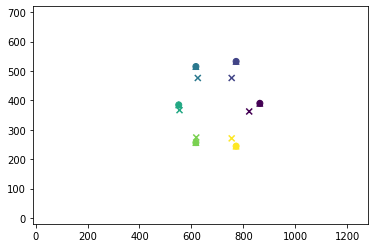

tensor(-214.8997, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.9341,  0.2972,  4.1451,  0.0000,  0.0000,  0.4349]],
       device='cuda:0', grad_fn=<AddBackward0>)


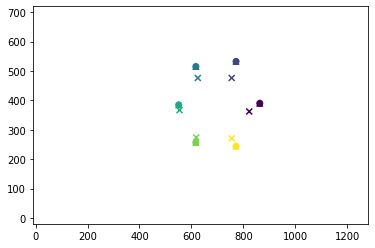

tensor(-214.7317, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.9405,  0.2977,  4.1459,  0.0000,  0.0000,  0.4359]],
       device='cuda:0', grad_fn=<AddBackward0>)


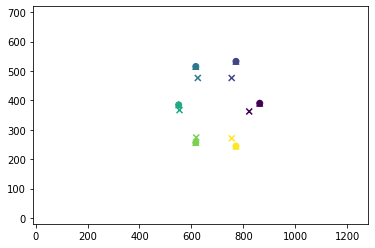

tensor(-214.5745, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.9468,  0.2982,  4.1467,  0.0000,  0.0000,  0.4369]],
       device='cuda:0', grad_fn=<AddBackward0>)


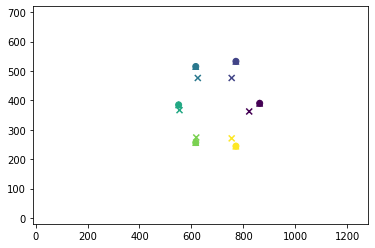

tensor(-214.4274, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.9531,  0.2987,  4.1474,  0.0000,  0.0000,  0.4379]],
       device='cuda:0', grad_fn=<AddBackward0>)


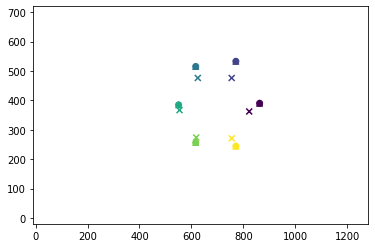

tensor(-214.2906, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.9593,  0.2991,  4.1480,  0.0000,  0.0000,  0.4389]],
       device='cuda:0', grad_fn=<AddBackward0>)


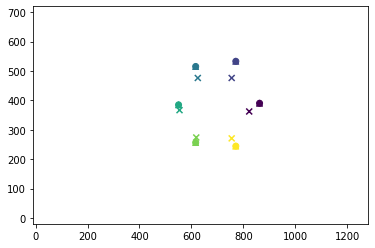

tensor(-214.1637, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.9654,  0.2996,  4.1487,  0.0000,  0.0000,  0.4399]],
       device='cuda:0', grad_fn=<AddBackward0>)


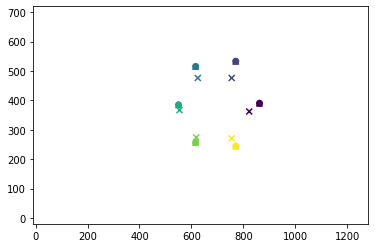

tensor(-214.0461, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.9714,  0.3001,  4.1493,  0.0000,  0.0000,  0.4408]],
       device='cuda:0', grad_fn=<AddBackward0>)


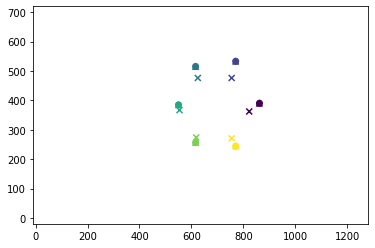

tensor(-213.9382, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.9774,  0.3006,  4.1499,  0.0000,  0.0000,  0.4418]],
       device='cuda:0', grad_fn=<AddBackward0>)


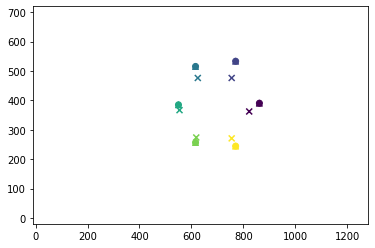

tensor(-213.8394, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.9833,  0.3011,  4.1505,  0.0000,  0.0000,  0.4427]],
       device='cuda:0', grad_fn=<AddBackward0>)


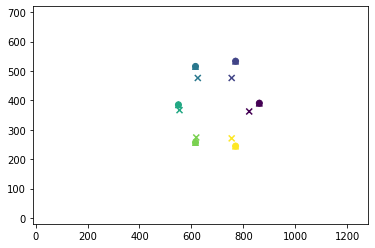

tensor(-213.7498, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.9891,  0.3016,  4.1510,  0.0000,  0.0000,  0.4436]],
       device='cuda:0', grad_fn=<AddBackward0>)


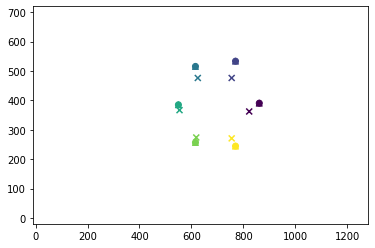

tensor(-213.6692, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-0.9949,  0.3022,  4.1515,  0.0000,  0.0000,  0.4445]],
       device='cuda:0', grad_fn=<AddBackward0>)


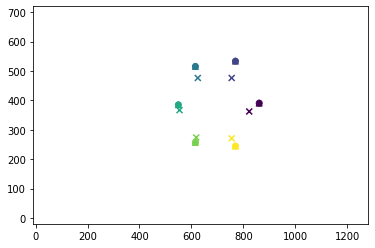

tensor(-213.5975, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.0006,  0.3027,  4.1520,  0.0000,  0.0000,  0.4454]],
       device='cuda:0', grad_fn=<AddBackward0>)


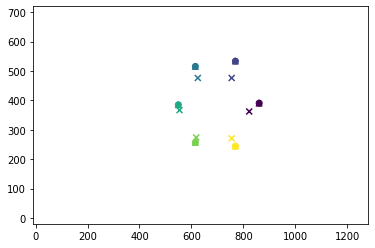

tensor(-213.5345, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.0062,  0.3032,  4.1524,  0.0000,  0.0000,  0.4463]],
       device='cuda:0', grad_fn=<AddBackward0>)


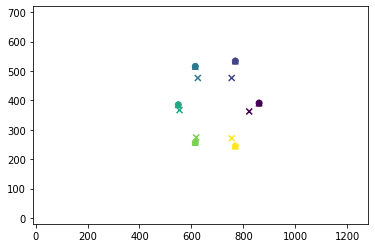

tensor(-213.4241, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.0118,  0.3037,  4.1528,  0.0000,  0.0000,  0.4470]],
       device='cuda:0', grad_fn=<AddBackward0>)


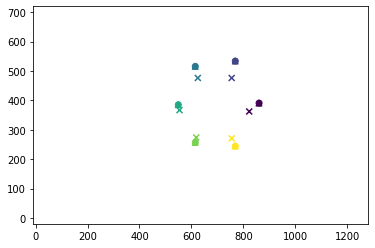

tensor(-213.2890, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.0174,  0.3043,  4.1532,  0.0000,  0.0000,  0.4476]],
       device='cuda:0', grad_fn=<AddBackward0>)


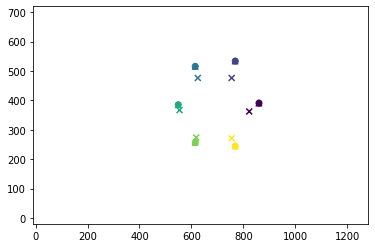

tensor(-213.1478, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.0229,  0.3048,  4.1535,  0.0000,  0.0000,  0.4481]],
       device='cuda:0', grad_fn=<AddBackward0>)


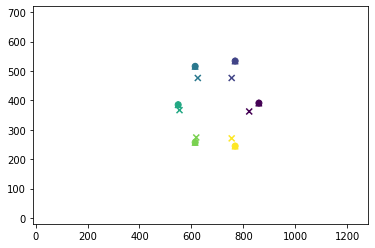

tensor(-213.0126, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.0283,  0.3054,  4.1537,  0.0000,  0.0000,  0.4486]],
       device='cuda:0', grad_fn=<AddBackward0>)


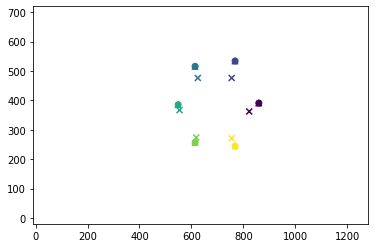

tensor(-212.9185, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.0337,  0.3059,  4.1539,  0.0000,  0.0000,  0.4492]],
       device='cuda:0', grad_fn=<AddBackward0>)


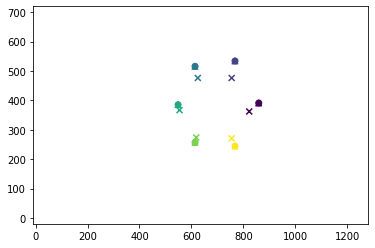

tensor(-212.8574, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.0390,  0.3065,  4.1540,  0.0000,  0.0000,  0.4497]],
       device='cuda:0', grad_fn=<AddBackward0>)


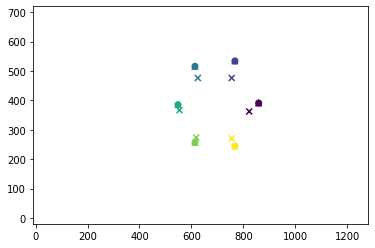

tensor(-212.8230, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.0443,  0.3070,  4.1540,  0.0000,  0.0000,  0.4503]],
       device='cuda:0', grad_fn=<AddBackward0>)


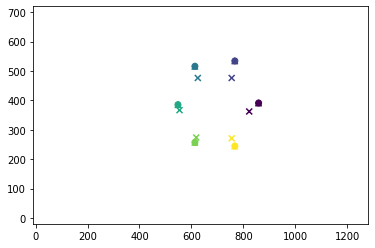

tensor(-212.8089, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.0494,  0.3075,  4.1540,  0.0000,  0.0000,  0.4509]],
       device='cuda:0', grad_fn=<AddBackward0>)


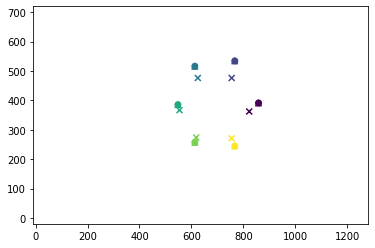

tensor(-212.8116, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.0545,  0.3081,  4.1540,  0.0000,  0.0000,  0.4516]],
       device='cuda:0', grad_fn=<AddBackward0>)


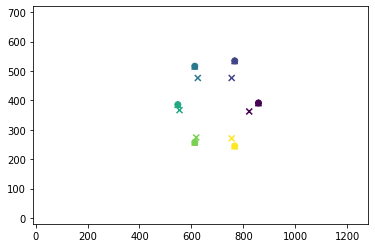

tensor(-212.8292, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.0596,  0.3086,  4.1540,  0.0000,  0.0000,  0.4522]],
       device='cuda:0', grad_fn=<AddBackward0>)


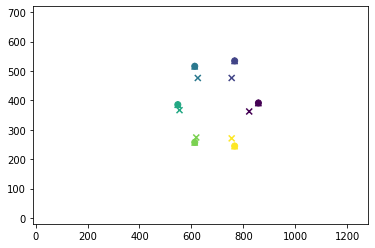

tensor(-212.8601, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.0646,  0.3091,  4.1539,  0.0000,  0.0000,  0.4528]],
       device='cuda:0', grad_fn=<AddBackward0>)


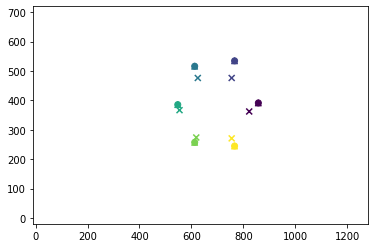

tensor(-212.9027, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.0695,  0.3097,  4.1537,  0.0000,  0.0000,  0.4534]],
       device='cuda:0', grad_fn=<AddBackward0>)


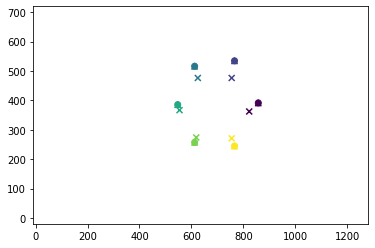

tensor(-212.9570, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.0744,  0.3102,  4.1535,  0.0000,  0.0000,  0.4540]],
       device='cuda:0', grad_fn=<AddBackward0>)


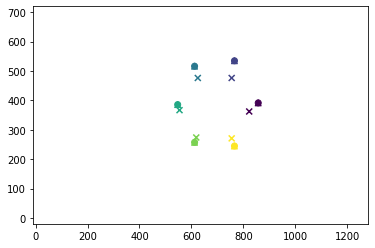

tensor(-213.0222, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.0792,  0.3107,  4.1533,  0.0000,  0.0000,  0.4546]],
       device='cuda:0', grad_fn=<AddBackward0>)


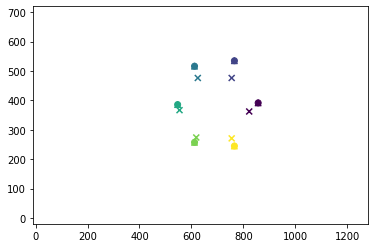

tensor(-213.0979, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.0840,  0.3112,  4.1531,  0.0000,  0.0000,  0.4551]],
       device='cuda:0', grad_fn=<AddBackward0>)


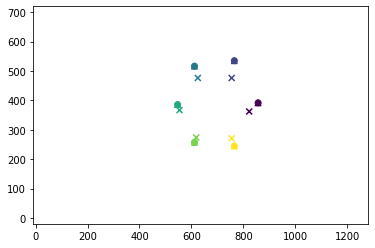

tensor(-213.1837, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.0887,  0.3118,  4.1528,  0.0000,  0.0000,  0.4557]],
       device='cuda:0', grad_fn=<AddBackward0>)


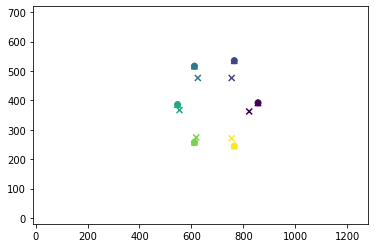

tensor(-213.2794, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.0934,  0.3123,  4.1525,  0.0000,  0.0000,  0.4563]],
       device='cuda:0', grad_fn=<AddBackward0>)


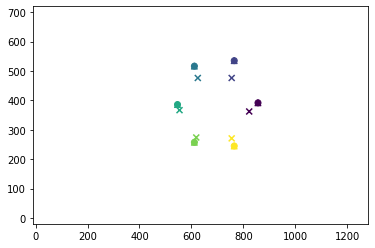

tensor(-213.3849, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.0980,  0.3128,  4.1521,  0.0000,  0.0000,  0.4568]],
       device='cuda:0', grad_fn=<AddBackward0>)


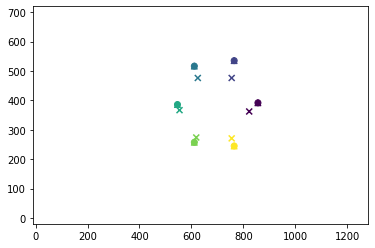

tensor(-213.4996, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.1026,  0.3133,  4.1517,  0.0000,  0.0000,  0.4574]],
       device='cuda:0', grad_fn=<AddBackward0>)


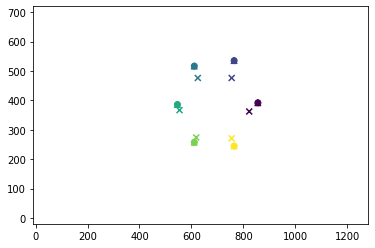

tensor(-213.6233, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.1071,  0.3138,  4.1513,  0.0000,  0.0000,  0.4579]],
       device='cuda:0', grad_fn=<AddBackward0>)


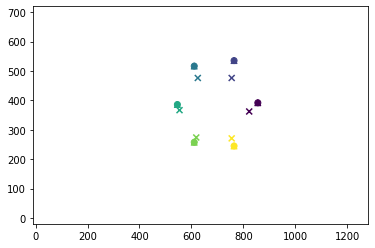

tensor(-213.7560, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.1115,  0.3143,  4.1508,  0.0000,  0.0000,  0.4584]],
       device='cuda:0', grad_fn=<AddBackward0>)


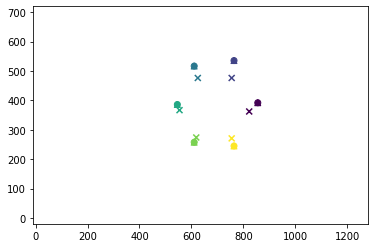

tensor(-213.8974, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.1159,  0.3148,  4.1503,  0.0000,  0.0000,  0.4589]],
       device='cuda:0', grad_fn=<AddBackward0>)


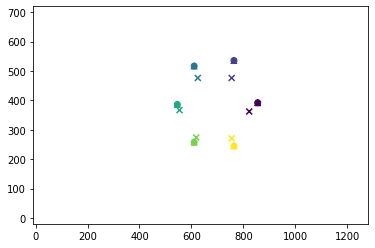

tensor(-214.0518, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.1203,  0.3153,  4.1498,  0.0000,  0.0000,  0.4595]],
       device='cuda:0', grad_fn=<AddBackward0>)


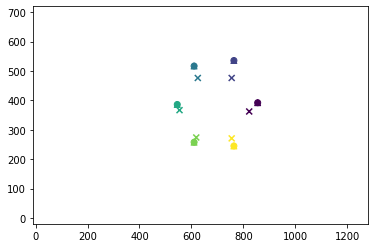

tensor(-214.2187, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.1245,  0.3158,  4.1493,  0.0000,  0.0000,  0.4601]],
       device='cuda:0', grad_fn=<AddBackward0>)


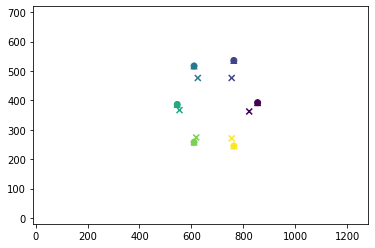

tensor(-214.3934, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.1288,  0.3163,  4.1488,  0.0000,  0.0000,  0.4607]],
       device='cuda:0', grad_fn=<AddBackward0>)


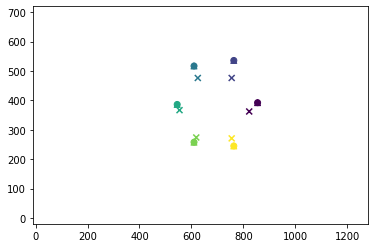

tensor(-214.5744, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.1330,  0.3168,  4.1482,  0.0000,  0.0000,  0.4613]],
       device='cuda:0', grad_fn=<AddBackward0>)


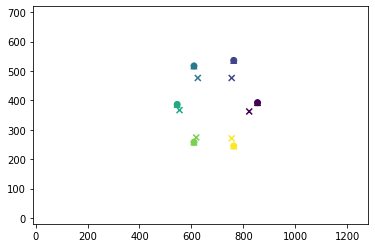

tensor(-214.7603, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.1371,  0.3173,  4.1477,  0.0000,  0.0000,  0.4619]],
       device='cuda:0', grad_fn=<AddBackward0>)


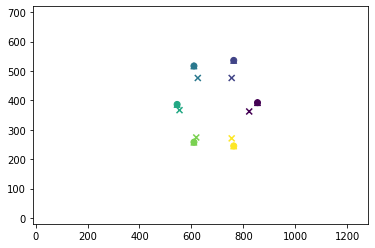

tensor(-214.9502, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.1412,  0.3178,  4.1471,  0.0000,  0.0000,  0.4625]],
       device='cuda:0', grad_fn=<AddBackward0>)


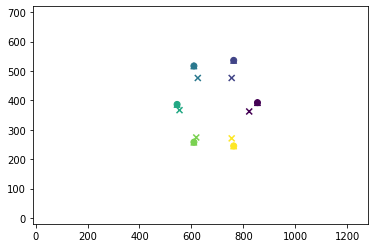

tensor(-215.1436, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.1452,  0.3183,  4.1465,  0.0000,  0.0000,  0.4631]],
       device='cuda:0', grad_fn=<AddBackward0>)


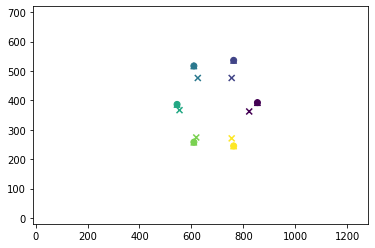

tensor(-215.3405, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.1493,  0.3188,  4.1459,  0.0000,  0.0000,  0.4637]],
       device='cuda:0', grad_fn=<AddBackward0>)


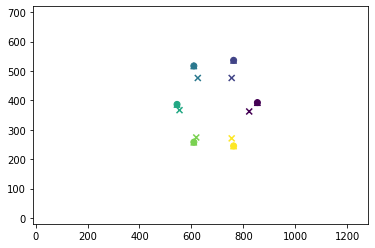

tensor(-215.5404, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.1532,  0.3193,  4.1453,  0.0000,  0.0000,  0.4643]],
       device='cuda:0', grad_fn=<AddBackward0>)


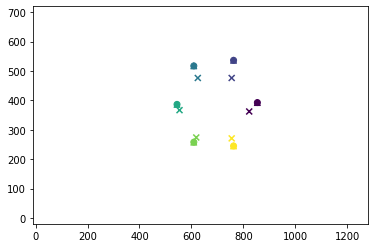

tensor(-215.7432, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.1571,  0.3197,  4.1447,  0.0000,  0.0000,  0.4648]],
       device='cuda:0', grad_fn=<AddBackward0>)


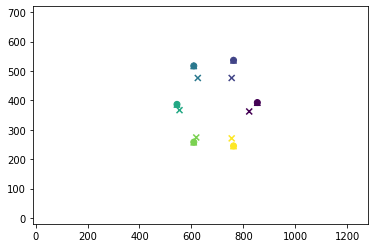

tensor(-215.9488, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.1610,  0.3202,  4.1440,  0.0000,  0.0000,  0.4654]],
       device='cuda:0', grad_fn=<AddBackward0>)


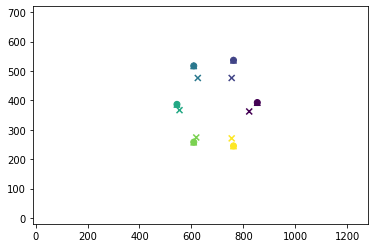

tensor(-216.1572, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.1649,  0.3207,  4.1434,  0.0000,  0.0000,  0.4660]],
       device='cuda:0', grad_fn=<AddBackward0>)


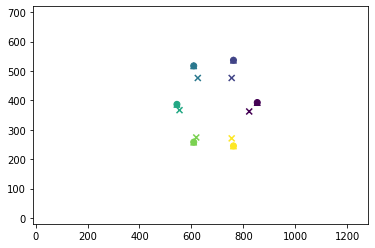

tensor(-216.3680, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.1687,  0.3211,  4.1427,  0.0000,  0.0000,  0.4665]],
       device='cuda:0', grad_fn=<AddBackward0>)


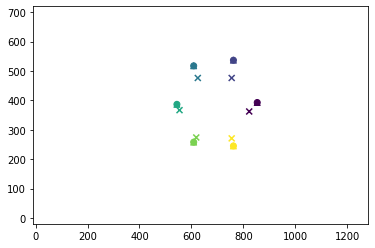

tensor(-216.5813, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.1724,  0.3216,  4.1421,  0.0000,  0.0000,  0.4671]],
       device='cuda:0', grad_fn=<AddBackward0>)


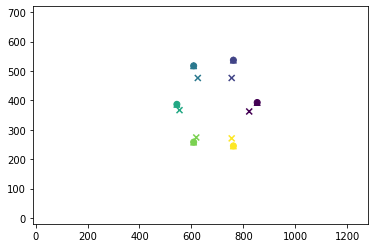

tensor(-216.7971, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.1762,  0.3221,  4.1414,  0.0000,  0.0000,  0.4676]],
       device='cuda:0', grad_fn=<AddBackward0>)


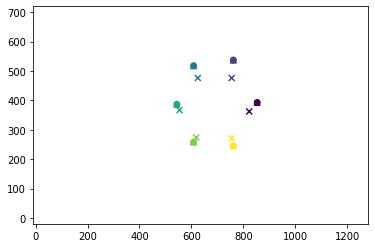

tensor(-217.0153, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.1799,  0.3225,  4.1407,  0.0000,  0.0000,  0.4682]],
       device='cuda:0', grad_fn=<AddBackward0>)


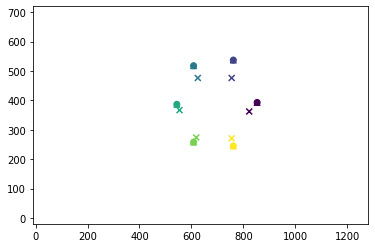

tensor(-217.2355, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.1835,  0.3230,  4.1400,  0.0000,  0.0000,  0.4687]],
       device='cuda:0', grad_fn=<AddBackward0>)


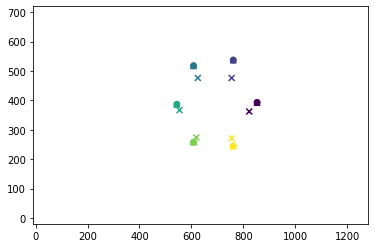

tensor(-217.4578, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.1871,  0.3234,  4.1393,  0.0000,  0.0000,  0.4693]],
       device='cuda:0', grad_fn=<AddBackward0>)


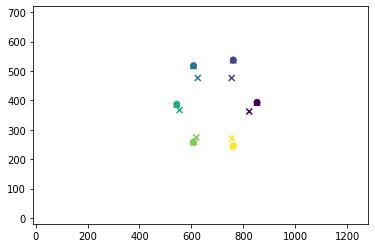

tensor(-217.6824, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.1907,  0.3239,  4.1386,  0.0000,  0.0000,  0.4698]],
       device='cuda:0', grad_fn=<AddBackward0>)


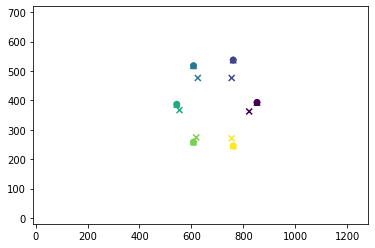

tensor(-217.9087, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.1942,  0.3244,  4.1379,  0.0000,  0.0000,  0.4703]],
       device='cuda:0', grad_fn=<AddBackward0>)


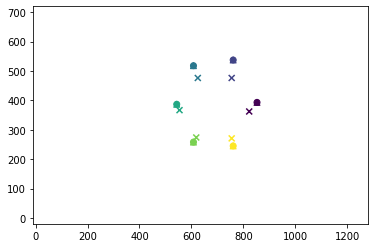

tensor(-218.1373, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.1977,  0.3248,  4.1372,  0.0000,  0.0000,  0.4708]],
       device='cuda:0', grad_fn=<AddBackward0>)


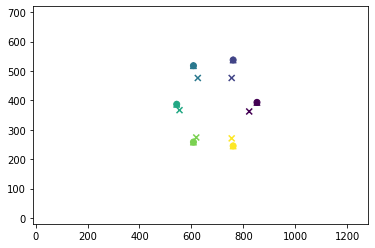

tensor(-218.3672, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2012,  0.3252,  4.1365,  0.0000,  0.0000,  0.4713]],
       device='cuda:0', grad_fn=<AddBackward0>)


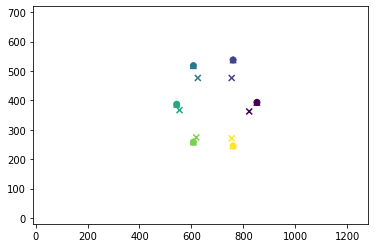

tensor(-218.5993, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2046,  0.3257,  4.1357,  0.0000,  0.0000,  0.4718]],
       device='cuda:0', grad_fn=<AddBackward0>)


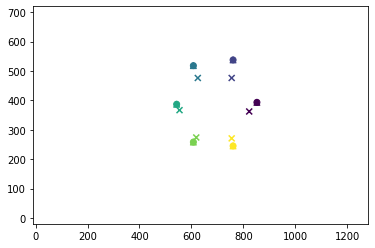

tensor(-218.8328, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2080,  0.3261,  4.1350,  0.0000,  0.0000,  0.4723]],
       device='cuda:0', grad_fn=<AddBackward0>)


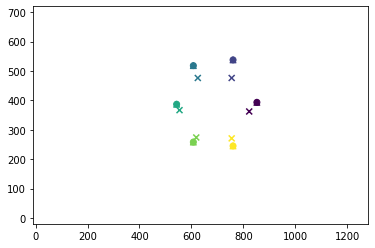

tensor(-219.0680, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2113,  0.3266,  4.1342,  0.0000,  0.0000,  0.4728]],
       device='cuda:0', grad_fn=<AddBackward0>)


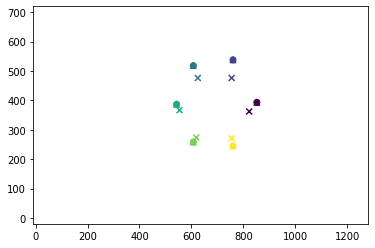

tensor(-219.3045, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2146,  0.3270,  4.1334,  0.0000,  0.0000,  0.4733]],
       device='cuda:0', grad_fn=<AddBackward0>)


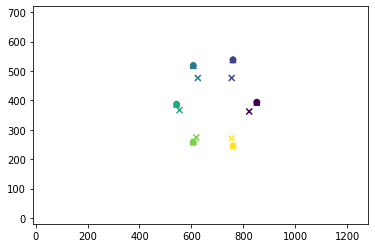

tensor(-219.5427, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2179,  0.3274,  4.1327,  0.0000,  0.0000,  0.4737]],
       device='cuda:0', grad_fn=<AddBackward0>)


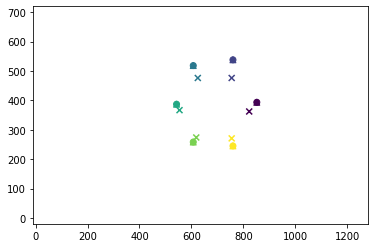

tensor(-219.7822, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2211,  0.3279,  4.1319,  0.0000,  0.0000,  0.4742]],
       device='cuda:0', grad_fn=<AddBackward0>)


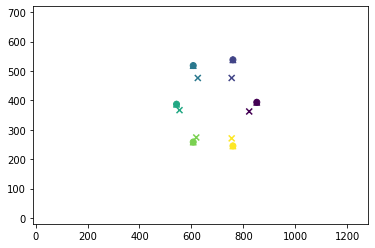

tensor(-220.0229, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2243,  0.3283,  4.1311,  0.0000,  0.0000,  0.4747]],
       device='cuda:0', grad_fn=<AddBackward0>)


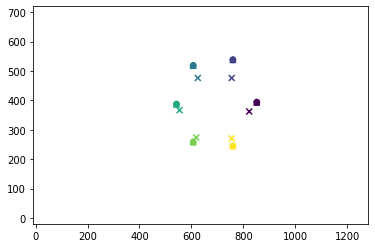

tensor(-220.2650, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2275,  0.3287,  4.1303,  0.0000,  0.0000,  0.4751]],
       device='cuda:0', grad_fn=<AddBackward0>)


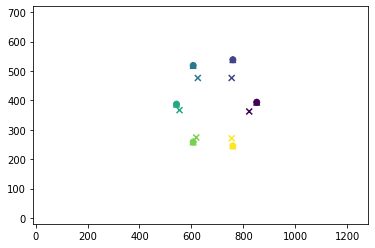

tensor(-220.5080, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2306,  0.3292,  4.1295,  0.0000,  0.0000,  0.4756]],
       device='cuda:0', grad_fn=<AddBackward0>)


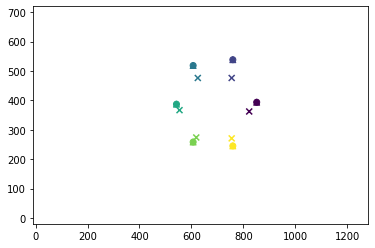

tensor(-220.7523, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2337,  0.3296,  4.1287,  0.0000,  0.0000,  0.4760]],
       device='cuda:0', grad_fn=<AddBackward0>)


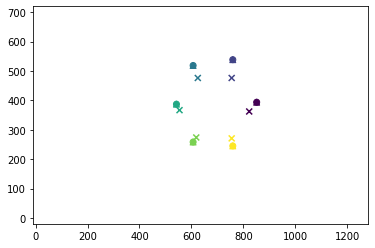

tensor(-220.9966, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2368,  0.3300,  4.1279,  0.0000,  0.0000,  0.4765]],
       device='cuda:0', grad_fn=<AddBackward0>)


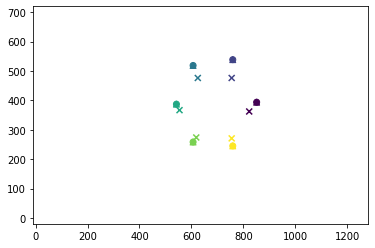

tensor(-221.2415, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2398,  0.3304,  4.1271,  0.0000,  0.0000,  0.4770]],
       device='cuda:0', grad_fn=<AddBackward0>)


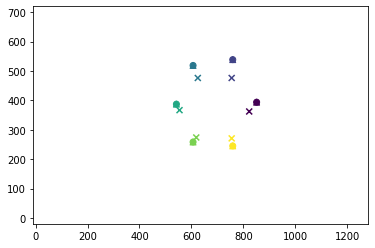

tensor(-221.4872, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2427,  0.3308,  4.1262,  0.0000,  0.0000,  0.4775]],
       device='cuda:0', grad_fn=<AddBackward0>)


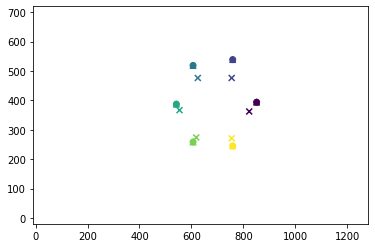

tensor(-221.7343, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2457,  0.3312,  4.1253,  0.0000,  0.0000,  0.4780]],
       device='cuda:0', grad_fn=<AddBackward0>)


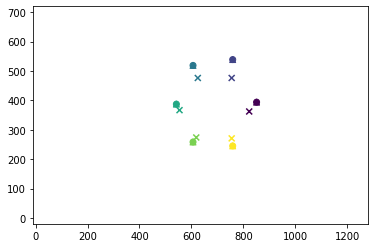

tensor(-221.9826, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2485,  0.3316,  4.1244,  0.0000,  0.0000,  0.4786]],
       device='cuda:0', grad_fn=<AddBackward0>)


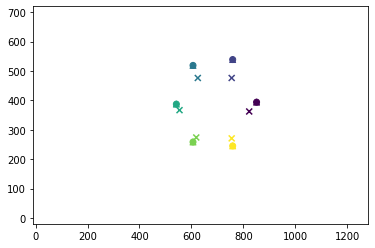

tensor(-222.2321, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2514,  0.3320,  4.1235,  0.0000,  0.0000,  0.4791]],
       device='cuda:0', grad_fn=<AddBackward0>)


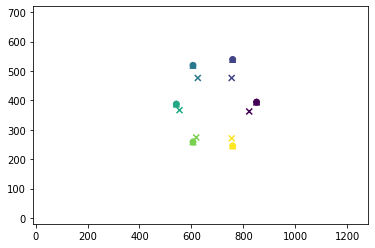

tensor(-222.4831, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2542,  0.3324,  4.1225,  0.0000,  0.0000,  0.4796]],
       device='cuda:0', grad_fn=<AddBackward0>)


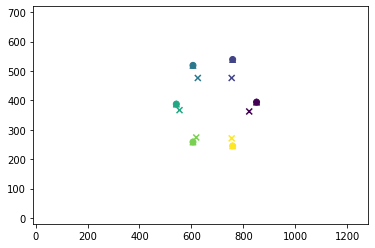

tensor(-222.7354, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2570,  0.3327,  4.1215,  0.0000,  0.0000,  0.4801]],
       device='cuda:0', grad_fn=<AddBackward0>)


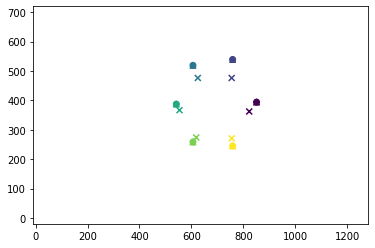

tensor(-222.9891, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2598,  0.3331,  4.1205,  0.0000,  0.0000,  0.4807]],
       device='cuda:0', grad_fn=<AddBackward0>)


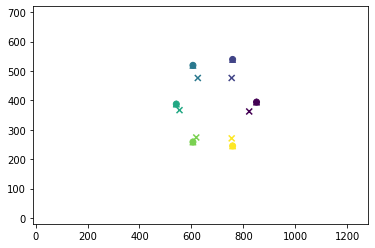

tensor(-223.2440, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2625,  0.3335,  4.1195,  0.0000,  0.0000,  0.4812]],
       device='cuda:0', grad_fn=<AddBackward0>)


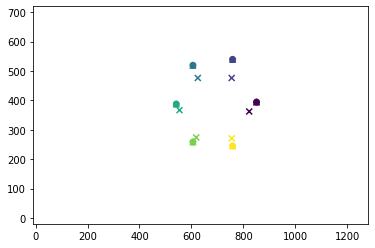

tensor(-223.5004, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2652,  0.3338,  4.1184,  0.0000,  0.0000,  0.4817]],
       device='cuda:0', grad_fn=<AddBackward0>)


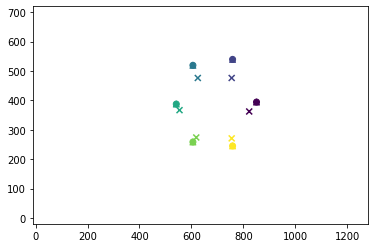

tensor(-223.7581, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2678,  0.3342,  4.1174,  0.0000,  0.0000,  0.4822]],
       device='cuda:0', grad_fn=<AddBackward0>)


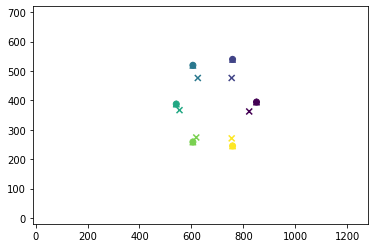

tensor(-224.0171, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2705,  0.3346,  4.1163,  0.0000,  0.0000,  0.4827]],
       device='cuda:0', grad_fn=<AddBackward0>)


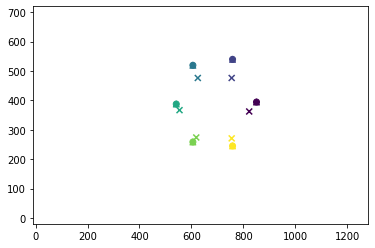

tensor(-224.2771, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2731,  0.3349,  4.1152,  0.0000,  0.0000,  0.4832]],
       device='cuda:0', grad_fn=<AddBackward0>)


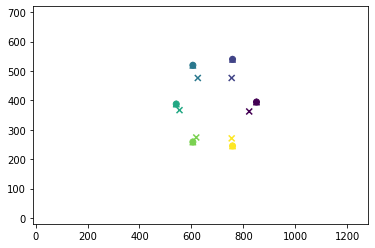

tensor(-224.5386, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2756,  0.3353,  4.1140,  0.0000,  0.0000,  0.4836]],
       device='cuda:0', grad_fn=<AddBackward0>)


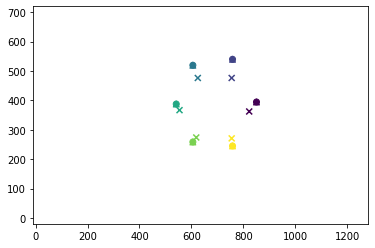

tensor(-224.8013, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2782,  0.3356,  4.1129,  0.0000,  0.0000,  0.4841]],
       device='cuda:0', grad_fn=<AddBackward0>)


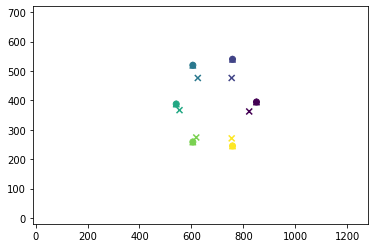

tensor(-225.0648, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2807,  0.3360,  4.1117,  0.0000,  0.0000,  0.4846]],
       device='cuda:0', grad_fn=<AddBackward0>)


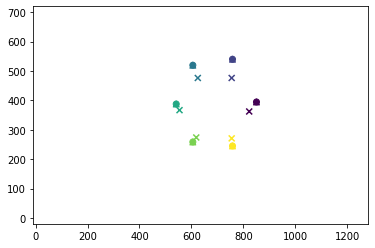

tensor(-225.3295, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2831,  0.3363,  4.1105,  0.0000,  0.0000,  0.4850]],
       device='cuda:0', grad_fn=<AddBackward0>)


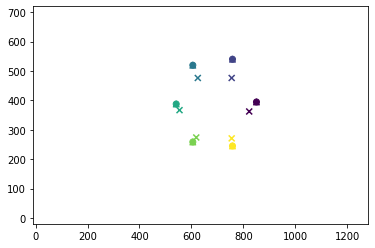

tensor(-225.5955, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2856,  0.3366,  4.1093,  0.0000,  0.0000,  0.4855]],
       device='cuda:0', grad_fn=<AddBackward0>)


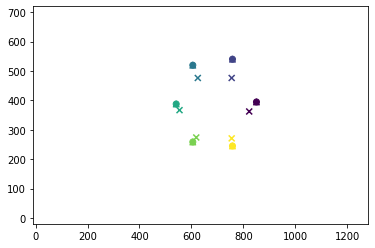

tensor(-225.8625, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2880,  0.3370,  4.1081,  0.0000,  0.0000,  0.4859]],
       device='cuda:0', grad_fn=<AddBackward0>)


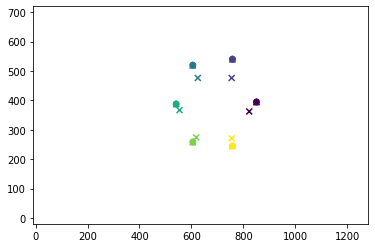

tensor(-226.1302, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2904,  0.3373,  4.1069,  0.0000,  0.0000,  0.4864]],
       device='cuda:0', grad_fn=<AddBackward0>)


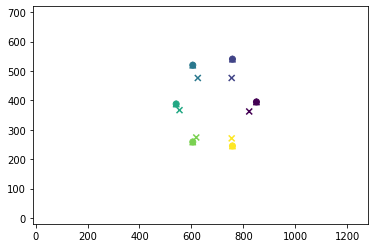

tensor(-226.3990, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2927,  0.3377,  4.1056,  0.0000,  0.0000,  0.4868]],
       device='cuda:0', grad_fn=<AddBackward0>)


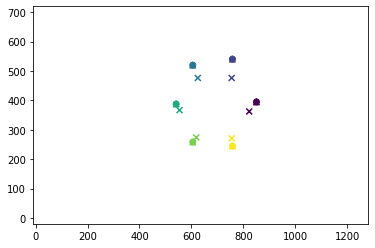

tensor(-226.6690, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2951,  0.3380,  4.1043,  0.0000,  0.0000,  0.4872]],
       device='cuda:0', grad_fn=<AddBackward0>)


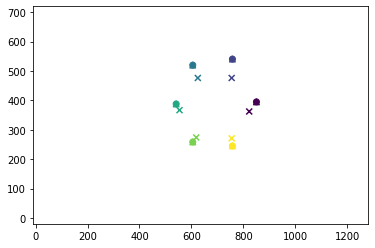

tensor(-226.9395, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2974,  0.3383,  4.1030,  0.0000,  0.0000,  0.4877]],
       device='cuda:0', grad_fn=<AddBackward0>)


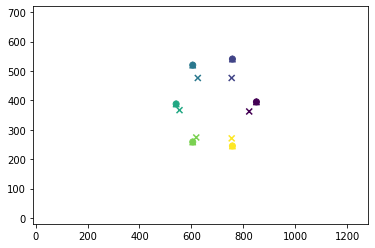

tensor(-227.2110, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.2996,  0.3386,  4.1017,  0.0000,  0.0000,  0.4881]],
       device='cuda:0', grad_fn=<AddBackward0>)


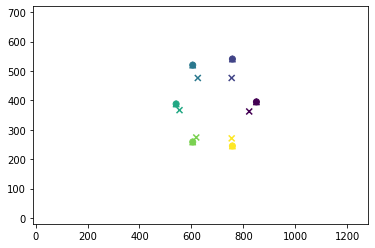

tensor(-227.4832, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3019,  0.3390,  4.1004,  0.0000,  0.0000,  0.4885]],
       device='cuda:0', grad_fn=<AddBackward0>)


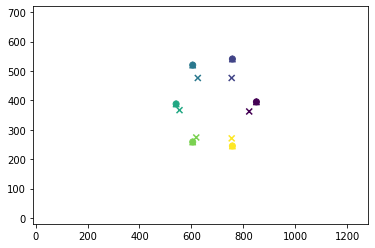

tensor(-227.7563, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3041,  0.3393,  4.0991,  0.0000,  0.0000,  0.4889]],
       device='cuda:0', grad_fn=<AddBackward0>)


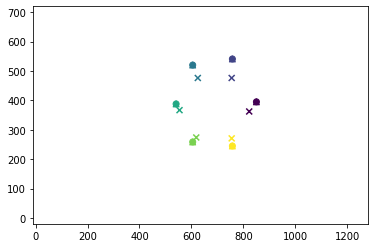

tensor(-228.0305, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3063,  0.3396,  4.0977,  0.0000,  0.0000,  0.4893]],
       device='cuda:0', grad_fn=<AddBackward0>)


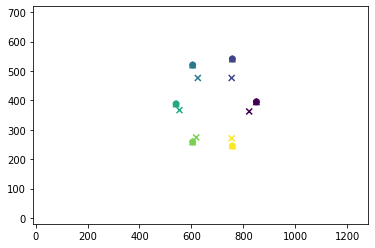

tensor(-228.3058, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3084,  0.3399,  4.0963,  0.0000,  0.0000,  0.4897]],
       device='cuda:0', grad_fn=<AddBackward0>)


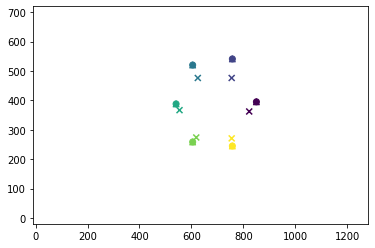

tensor(-228.5823, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3106,  0.3402,  4.0949,  0.0000,  0.0000,  0.4901]],
       device='cuda:0', grad_fn=<AddBackward0>)


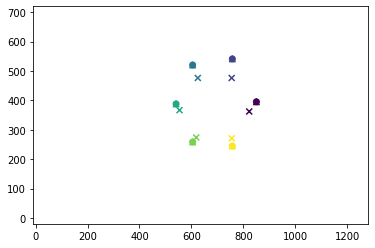

tensor(-228.8600, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3127,  0.3405,  4.0935,  0.0000,  0.0000,  0.4905]],
       device='cuda:0', grad_fn=<AddBackward0>)


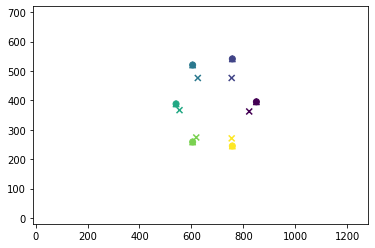

tensor(-229.1389, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3149,  0.3408,  4.0920,  0.0000,  0.0000,  0.4909]],
       device='cuda:0', grad_fn=<AddBackward0>)


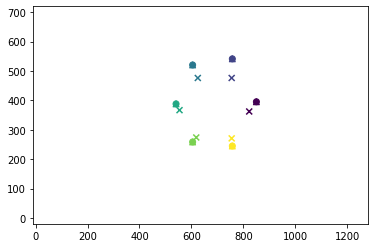

tensor(-229.4193, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3170,  0.3411,  4.0906,  0.0000,  0.0000,  0.4912]],
       device='cuda:0', grad_fn=<AddBackward0>)


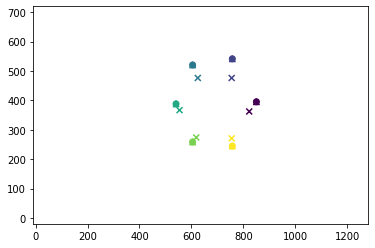

tensor(-229.7009, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3191,  0.3414,  4.0891,  0.0000,  0.0000,  0.4916]],
       device='cuda:0', grad_fn=<AddBackward0>)


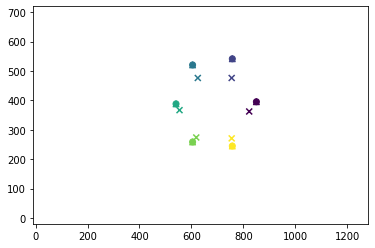

tensor(-229.9841, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3212,  0.3416,  4.0875,  0.0000,  0.0000,  0.4920]],
       device='cuda:0', grad_fn=<AddBackward0>)


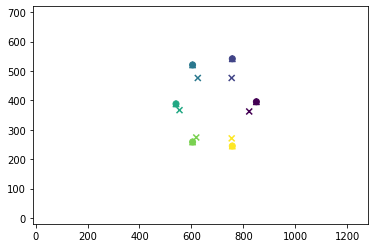

tensor(-230.2685, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3232,  0.3419,  4.0860,  0.0000,  0.0000,  0.4924]],
       device='cuda:0', grad_fn=<AddBackward0>)


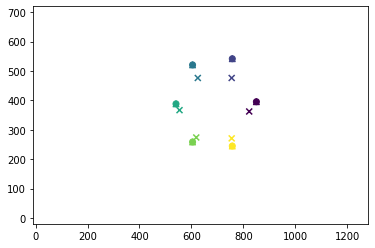

tensor(-230.5544, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3253,  0.3422,  4.0844,  0.0000,  0.0000,  0.4928]],
       device='cuda:0', grad_fn=<AddBackward0>)


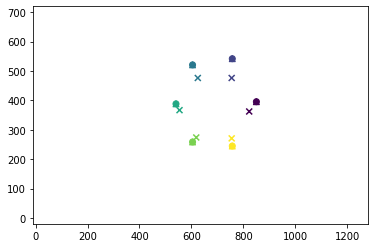

tensor(-230.8415, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3273,  0.3424,  4.0828,  0.0000,  0.0000,  0.4931]],
       device='cuda:0', grad_fn=<AddBackward0>)


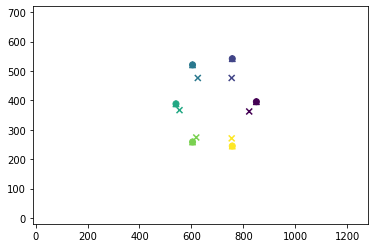

tensor(-231.1301, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3293,  0.3426,  4.0812,  0.0000,  0.0000,  0.4935]],
       device='cuda:0', grad_fn=<AddBackward0>)


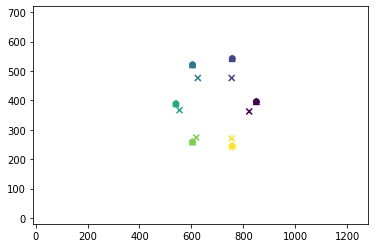

tensor(-231.4195, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3313,  0.3429,  4.0796,  0.0000,  0.0000,  0.4939]],
       device='cuda:0', grad_fn=<AddBackward0>)


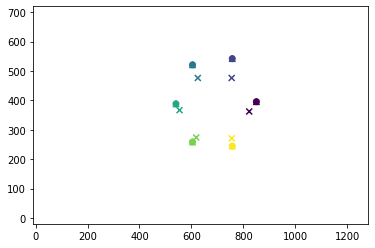

tensor(-231.7061, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3333,  0.3431,  4.0779,  0.0000,  0.0000,  0.4943]],
       device='cuda:0', grad_fn=<AddBackward0>)


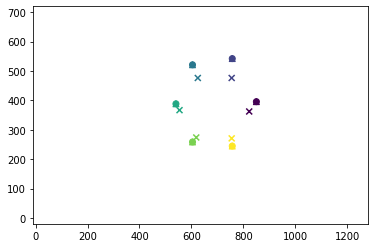

tensor(-231.9915, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3353,  0.3433,  4.0762,  0.0000,  0.0000,  0.4947]],
       device='cuda:0', grad_fn=<AddBackward0>)


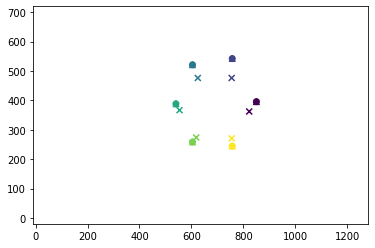

tensor(-232.2764, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3373,  0.3436,  4.0745,  0.0000,  0.0000,  0.4952]],
       device='cuda:0', grad_fn=<AddBackward0>)


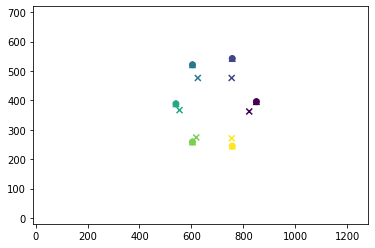

tensor(-232.5622, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3393,  0.3438,  4.0728,  0.0000,  0.0000,  0.4956]],
       device='cuda:0', grad_fn=<AddBackward0>)


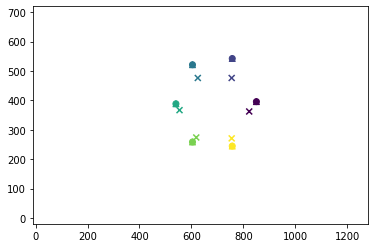

tensor(-232.8499, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3413,  0.3440,  4.0711,  0.0000,  0.0000,  0.4961]],
       device='cuda:0', grad_fn=<AddBackward0>)


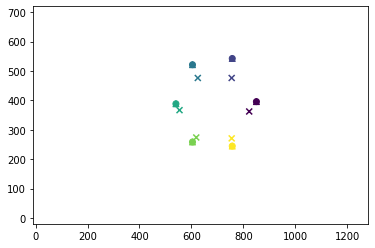

tensor(-233.1401, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3432,  0.3443,  4.0694,  0.0000,  0.0000,  0.4966]],
       device='cuda:0', grad_fn=<AddBackward0>)


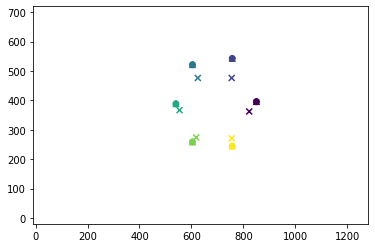

tensor(-233.4332, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3452,  0.3446,  4.0677,  0.0000,  0.0000,  0.4971]],
       device='cuda:0', grad_fn=<AddBackward0>)


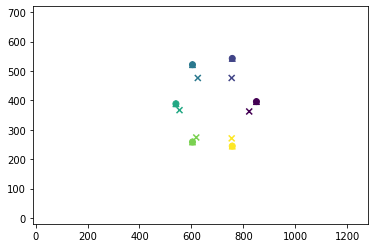

tensor(-233.7294, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3472,  0.3449,  4.0659,  0.0000,  0.0000,  0.4977]],
       device='cuda:0', grad_fn=<AddBackward0>)


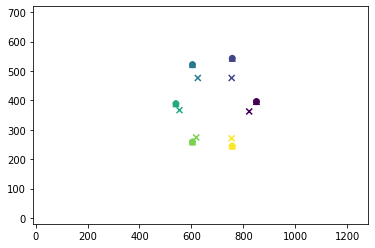

tensor(-234.0286, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3492,  0.3452,  4.0642,  0.0000,  0.0000,  0.4982]],
       device='cuda:0', grad_fn=<AddBackward0>)


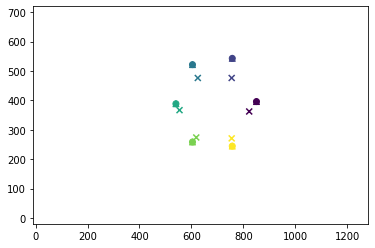

tensor(-234.3312, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3512,  0.3455,  4.0624,  0.0000,  0.0000,  0.4987]],
       device='cuda:0', grad_fn=<AddBackward0>)


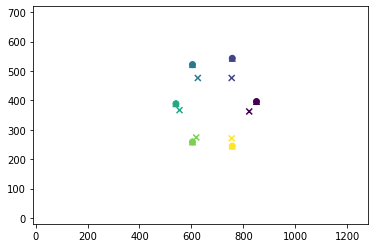

tensor(-234.6367, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3532,  0.3458,  4.0607,  0.0000,  0.0000,  0.4992]],
       device='cuda:0', grad_fn=<AddBackward0>)


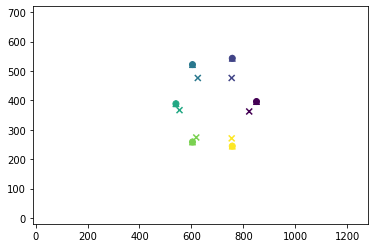

tensor(-234.9454, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3551,  0.3462,  4.0589,  0.0000,  0.0000,  0.4997]],
       device='cuda:0', grad_fn=<AddBackward0>)


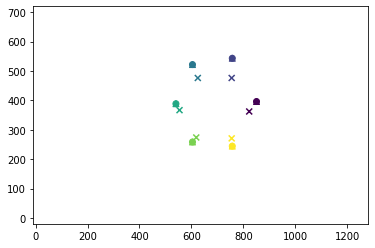

tensor(-235.2570, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3571,  0.3465,  4.0571,  0.0000,  0.0000,  0.5002]],
       device='cuda:0', grad_fn=<AddBackward0>)


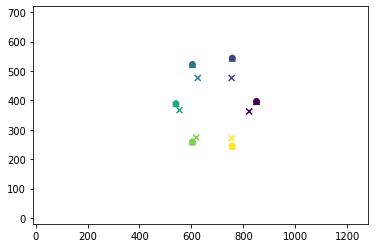

tensor(-235.5716, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3591,  0.3469,  4.0554,  0.0000,  0.0000,  0.5007]],
       device='cuda:0', grad_fn=<AddBackward0>)


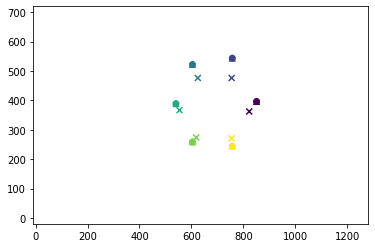

tensor(-235.8891, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3611,  0.3473,  4.0536,  0.0000,  0.0000,  0.5012]],
       device='cuda:0', grad_fn=<AddBackward0>)


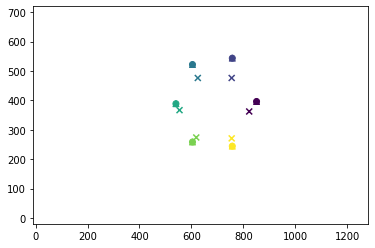

tensor(-236.2097, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3631,  0.3476,  4.0518,  0.0000,  0.0000,  0.5017]],
       device='cuda:0', grad_fn=<AddBackward0>)


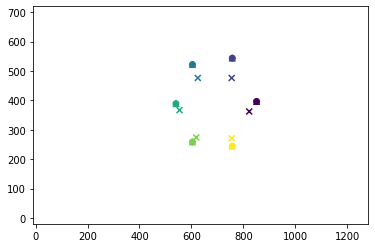

tensor(-236.5329, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3651,  0.3480,  4.0500,  0.0000,  0.0000,  0.5023]],
       device='cuda:0', grad_fn=<AddBackward0>)


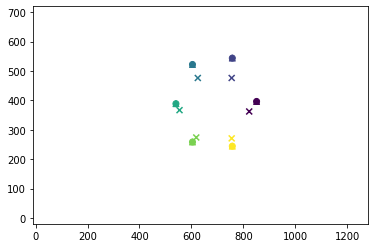

tensor(-236.8590, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3671,  0.3484,  4.0482,  0.0000,  0.0000,  0.5028]],
       device='cuda:0', grad_fn=<AddBackward0>)


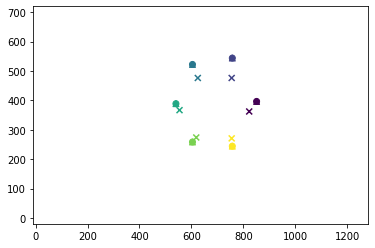

tensor(-237.1877, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3691,  0.3489,  4.0463,  0.0000,  0.0000,  0.5033]],
       device='cuda:0', grad_fn=<AddBackward0>)


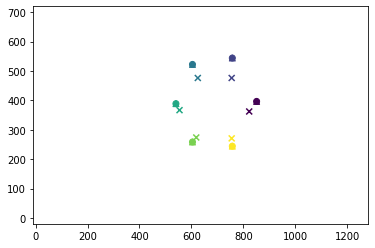

tensor(-237.5192, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3710,  0.3493,  4.0445,  0.0000,  0.0000,  0.5038]],
       device='cuda:0', grad_fn=<AddBackward0>)


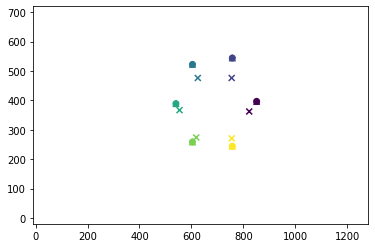

tensor(-237.8532, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3730,  0.3497,  4.0427,  0.0000,  0.0000,  0.5043]],
       device='cuda:0', grad_fn=<AddBackward0>)


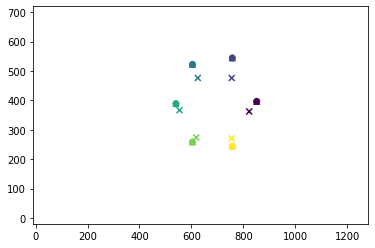

tensor(-238.1900, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3750,  0.3502,  4.0408,  0.0000,  0.0000,  0.5048]],
       device='cuda:0', grad_fn=<AddBackward0>)


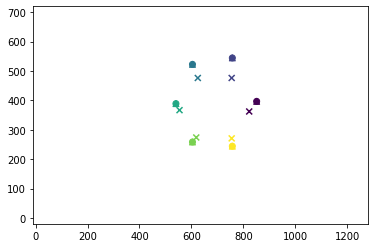

tensor(-238.5293, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3770,  0.3506,  4.0390,  0.0000,  0.0000,  0.5053]],
       device='cuda:0', grad_fn=<AddBackward0>)


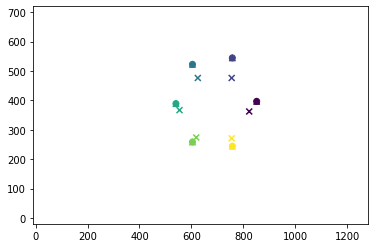

tensor(-238.8711, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3790,  0.3511,  4.0371,  0.0000,  0.0000,  0.5058]],
       device='cuda:0', grad_fn=<AddBackward0>)


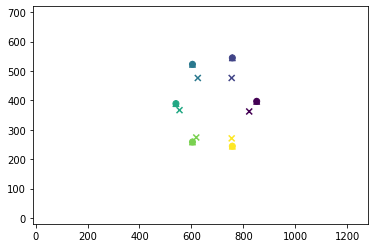

tensor(-239.2154, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3810,  0.3515,  4.0353,  0.0000,  0.0000,  0.5063]],
       device='cuda:0', grad_fn=<AddBackward0>)


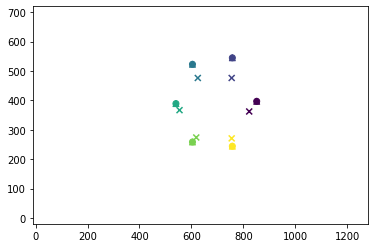

tensor(-239.5621, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3830,  0.3520,  4.0334,  0.0000,  0.0000,  0.5068]],
       device='cuda:0', grad_fn=<AddBackward0>)


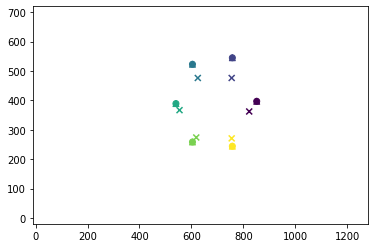

tensor(-239.9112, device='cuda:0', grad_fn=<NegBackward0>)
tensor([[-1.3850,  0.3525,  4.0315,  0.0000,  0.0000,  0.5073]],
       device='cuda:0', grad_fn=<AddBackward0>)


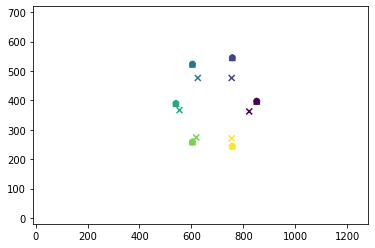

tensor([[-1.3850,  0.3525,  4.0315,  0.0000,  0.0000,  0.5073]],
       device='cuda:0', grad_fn=<AddBackward0>)


In [259]:
# initial_coords = torch.tensor([[-.5, 1.2, 0., .1, -.4, 0.]]).to(device)
initial_coords = torch.tensor([[2., -2, 0., 0., 0., 0.3]]).to(device)

initial_proj = camera_transition._project_points(initial_coords).squeeze().cpu()

# visualize_scatter(camera_transition.target_points.cpu(), initial_proj, initial_proj)

iters = 500
state = initial_coords
for i in range(iters):
    action = actor(state)
    # print(action)
    new_state, reward = camera_transition(state, action)
    print(reward)
    print(new_state)
    proj = camera_transition._project_points(state).squeeze().detach().cpu()
    new_proj = camera_transition._project_points(new_state).squeeze().detach().cpu()
    
    visualize_scatter(camera_transition.target_points.cpu(), proj, new_proj, i=i+1)
    state = new_state
print(state)

In [ ]:
critic(torch.tensor([0., 2.1, 2., 0.1, 0.1, 0.]).to(device))

tensor([2.1401], device='cuda:0', grad_fn=<MulBackward0>)

In [ ]:
import matplotlib.pyplot as plt
plt.scatter( np.array([
    [822.75,     362.25],
    [755.25,     476.25],
    [624.75,     476.25],
    [554.25,     366.75],
    [618.75,     273.75],
    [755.25,     270.75]])[:,0],
            np.array([
                [822.75,     362.25],
    [755.25,     476.25],
    [624.75,     476.25],
    [554.25,     366.75],
    [618.75,     273.75],
    [755.25,     270.75]])[:,1], c=range(6))

In [ ]:
torch.hstack([torch.Tensor(np.random.uniform(-.1, .1, (2,3)).astype(np.float64)), torch.Tensor(np.random.uniform(-.5, .5, (2,3)).astype(np.float64))])
# torch.Tensor([*np.random.uniform(-.1, .1, 3).astype(np.float64), *np.random.uniform(-.5, .5, 3).astype(np.float64)]*2)

In [ ]:
# camera_transition = CameraTransition(
#     device,
#     camera_mat,
#     target_points,
#     points_env,
#     100.
# )
camera_transition._project_points(torch.Tensor([[0,0,0,0,0,0]]))

In [ ]:
plt.scatter( np.array([
    [822.75,     362.25],
    [755.25,     476.25],
    [624.75,     476.25],
    [554.25,     366.75],
    [618.75,     273.75],
    [755.25,     270.75]])[:,0],
            np.array([
                [822.75,     362.25],
    [755.25,     476.25],
    [624.75,     476.25],
    [554.25,     366.75],
    [618.75,     273.75],
    [755.25,     270.75]])[:,1], c=range(6),marker='x')
plt.scatter( np.array([
    [945.6097, 362.7401],
         [787.3372, 627.8232],
         [470.7921, 627.8232],
         [312.5195, 362.7401],
         [470.7921,  97.6570],
         [787.3372,  97.6570]])[:,0],
            np.array([
                [945.6097, 362.7401],
         [787.3372, 627.8232],
         [470.7921, 627.8232],
         [312.5195, 362.7401],
         [470.7921,  97.6570],
         [787.3372,  97.6570]])[:,1], c=range(6))
plt.show()